# XGBoost
Created by Tianqi Chen to explore tree boosting. Was used on a Kaggle project and became best model. Since then, Python and R adapters added. Now has scikit-learn API. In 2015 won 17 of 29  Kaggle challenges.

Innovations:

* Scalability
* Handles sparse data
* Out of core learning
* Theoretically justified weighted quantile sketch for efficient candidate split proposal calculations

In [8]:
!pip install lime missingno pydotplus shap yellowbrick

  Using cached yellowbrick-1.3.post1-py3-none-any.whl (271 kB)


In [9]:
%matplotlib inline

from IPython.display import Image
import lime
import matplotlib.pyplot as plt
import missingno as mn
import numpy as np
import pandas as pd
import pydotplus
import seaborn as sns
import shap
from sklearn import base, metrics, model_selection, preprocessing, tree, utils
import xgboost
from yellowbrick import classifier, features, regressor
import yellowbrick.model_selection as ms


import io
import zipfile

%config Completer.use_jedi = False

In [13]:
# https://www.kaggle.com/kaggle/kaggle-survey-2018
with zipfile.ZipFile('kaggle-survey-2018.zip') as z:
    print(z.namelist())
    kag = pd.read_csv(z.open('multipleChoiceResponses.csv'), low_memory=False)
    kag_questions = kag.iloc[0]
    raw = kag.iloc[1:]

['freeFormResponses.csv', 'multipleChoiceResponses.csv', 'SurveySchema.csv']


In [14]:
raw

Time from Start to Finish (seconds)      Q1 Q1_OTHER_TEXT     Q2  \
1                                     710  Female            -1  45-49   
2                                     434    Male            -1  30-34   
3                                     718  Female            -1  30-34   
4                                     621    Male            -1  35-39   
5                                     731    Male            -1  22-24   
...                                   ...     ...           ...    ...   
23855                                 575    Male            -1  45-49   
23856                                 131  Female            -1  25-29   
23857                                 370    Male            -1  22-24   
23858                                  36    Male            -1  25-29   
23859                                 502    Male            -1  25-29   

                                                      Q3                 Q4  \
1                               United States of America    Doctoral degree   
2                                              Indonesia  Bachelor’s degree   
3                               United States of America    Master’s degree   
4                               United States of America    Master’s degree   
5                                                  India    Master’s degree   
...                                                  ...                ...   
23855                                             France    Doctoral degree   
23856                                             Turkey    Master’s degree   
23857                                             Turkey    Master’s degree   
23858  United Kingdom of Great Britain and Northern I...                NaN   
23859                                              Spain    Master’s degree   

                                                      Q5                 Q6  \
1                                                  Other         Consultant   
2                     Engineering (non-computer focused)              Other   
3          Computer science (software engineering, etc.)     Data Scientist   
4      Social sciences (anthropology, psychology, soc...       Not employed   
5                              Mathematics or statistics       Data Analyst   
...                                                  ...                ...   
23855      Computer science (software engineering, etc.)      Chief Officer   
23856                 Engineering (non-computer focused)                NaN   
23857      Computer science (software engineering, etc.)  Software Engineer   
23858                                                NaN                NaN   
23859                          Mathematics or statistics                NaN   

      Q6_OTHER_TEXT                         Q7  ... Q49_OTHER_TEXT Q50_Part_1  \
1                -1                      Other  ...             -1        NaN   
2                 0  Manufacturing/Fabrication  ...             -1        NaN   
3                -1             I am a student  ...             -1        NaN   
4                -1                        NaN  ...             -1        NaN   
5                -1             I am a student  ...             -1        NaN   
...             ...                        ...  ...            ...        ...   
23855            -1       Computers/Technology  ...             -1        NaN   
23856            -1                        NaN  ...             -1        NaN   
23857            -1       Computers/Technology  ...             -1        NaN   
23858            -1                        NaN  ...             -1        NaN   
23859            -1                        NaN  ...             -1        NaN   

               Q50_Part_2                             Q50_Part_3 Q50_Part_4  \
1                     NaN                                    NaN        NaN   
2                     NaN                                    NaN        NaN   
3      To

In [15]:
raw.dtypes

Time from Start to Finish (seconds)    object
Q1                                     object
Q1_OTHER_TEXT                          object
Q2                                     object
Q3                                     object
                                        ...  
Q50_Part_5                             object
Q50_Part_6                             object
Q50_Part_7                             object
Q50_Part_8                             object
Q50_OTHER_TEXT                         object
Length: 395, dtype: object

In [16]:
def tweak_kag(df):
    # What is your gender?
    q1 = pd.get_dummies(df[['Q1']], drop_first=True).iloc[:,:-2]
    # Age groups in years
    q2 = pd.to_numeric(df.Q2.str.slice(0,2)).rename('Q2_age')
    # Country
    q3 = pd.get_dummies(df[['Q3']], drop_first=True).loc[:,
        ['Q3_United States of America', 'Q3_India', 'Q3_China']]
    # Highest Education
    q4 = df.Q4.replace({'Master’s degree': 18,
 'Bachelor’s degree': 16,
 'Doctoral degree': 20,
 'Some college/university study without earning a bachelor’s degree': 13,
 'Professional degree': 19,
 'I prefer not to answer': None,
 'No formal education past high school': 12}).rename('Q4_edu')
    # Undergrad major
    q5 = df.Q5.replace({
        'Computer science (software engineering, etc.)': 'cs',
        'Engineering (non-computer focused)': 'eng',
        'Mathematics or statistics': 'stat'})
    q5[~q5.isin(['cs', 'eng', 'stat'])] = 'other'
    q5 = pd.get_dummies(q5, prefix='Q5', drop_first=True)
    # Title
    q6 = pd.get_dummies(df[['Q6']], drop_first=True).loc[:,
        ['Q6_Data Scientist', 'Q6_Software Engineer', 'Q6_Consultant',]]
    # Years experience
    q8 = pd.to_numeric(df.Q8.str.replace('+','')
                       .str.split('-', expand=True)
                       .iloc[:,0]
                       .rename('Q8_exp'))
    # Yearly compensation ($)
    q9 = pd.to_numeric(df.Q9.str.replace('+','')
                       .str.replace(',','')
                       .str.replace('500000', '500')
                       .str.replace('I do not wish to disclose my approximate yearly compensation','')
                       .str.split('-', expand=True)
                       .iloc[:,0]
                       .rename('Q9_salary')) * 1_000
    # Programming language
    q16 = pd.concat([df.Q16_Part_1.rename('Q16_Py').replace('Python', 1),
                     df.Q16_Part_2.rename('Q16_R').replace('R', 1),
                     df.Q16_Part_3.rename('Q16_SQL').replace('SQL', 1)
                    ], axis=1)
    return pd.concat([q1, q2, q3, q4, q5, q6, q8, q9, q16], axis=1)

kag = tweak_kag(raw)

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.


In [17]:
kag.dtypes

Q1_Male                          uint8
Q2_age                           int64
Q3_United States of America      uint8
Q3_India                         uint8
Q3_China                         uint8
Q4_edu                         float64
Q5_eng                           uint8
Q5_other                         uint8
Q5_stat                          uint8
Q6_Data Scientist                uint8
Q6_Software Engineer             uint8
Q6_Consultant                    uint8
Q8_exp                         float64
Q9_salary                      float64
Q16_Py                         float64
Q16_R                          float64
Q16_SQL                        float64
dtype: object

In [18]:
kag

Q1_Male  Q2_age  Q3_United States of America  Q3_India  Q3_China  \
1            0      45                            1         0         0   
2            1      30                            0         0         0   
3            0      30                            1         0         0   
4            1      35                            1         0         0   
5            1      22                            0         1         0   
...        ...     ...                          ...       ...       ...   
23855        1      45                            0         0         0   
23856        0      25                            0         0         0   
23857        1      22                            0         0         0   
23858        1      25                            0         0         0   
23859        1      25                            0         0         0   

       Q4_edu  Q5_eng  Q5_other  Q5_stat  Q6_Data Scientist  \
1        20.0       0         1        0                  0   
2        16.0       1         0        0                  0   
3        18.0       0         0        0                  1   
4        18.0       0         1        0                  0   
5        18.0       0         0        1                  0   
...       ...     ...       ...      ...                ...   
23855    20.0       0         0        0                  0   
23856    18.0       1         0        0                  0   
23857    18.0       0         0        0                  0   
23858     NaN       0         1        0                  0   
23859    18.0       0         0        1                  0   

       Q6_Software Engineer  Q6_Consultant  Q8_exp  Q9_salary  Q16_Py  Q16_R  \
1                         0              1     NaN        NaN     NaN    NaN   
2                         0              0     5.0    10000.0     NaN    NaN   
3                         0              0     0.0        0.0     NaN    1.0   
4                         0              0     NaN        NaN     1.0    1.0   
5                         0              0     0.0        0.0     NaN    NaN   
...                     ...            ...     ...        ...     ...    ...   
23855                     0              0     5.0   250000.0     1.0    1.0   
23856                     0              0     NaN        NaN     NaN    NaN   
23857                     1              0     0.0    10000.0     NaN    NaN   
23858                     0              0     NaN        NaN     NaN    NaN   
23859                     0              0     NaN        NaN     NaN    NaN   

       Q16_SQL  
1          NaN  
2          1.0  
3          NaN  
4          1.0  
5          1.0  
...        ...  
23855      1.0  
23856      NaN  
23857      NaN  
23858      NaN  
23859      NaN  

[23859 rows x 17 columns]

For classifiction we will predict job title (will start off with binary classification)

(For regression could predict salary)



In [19]:
X_cls = kag.drop(columns=['Q6_Data Scientist', 'Q6_Software Engineer', 'Q6_Consultant'])
y_cls = (kag
  [[x for x in kag.columns if 'Q6' in x]]
  .assign(Q6_other=lambda df:(~df.any(axis=1)).astype(int))
  .idxmax(axis=1)
  .str.replace('Q6_', ''))

X_cls_train, X_cls_test, y_cls_train, y_cls_test = model_selection.train_test_split(
    X_cls, y_cls, random_state=42, test_size=.3
)

In [20]:
X_cls

Q1_Male  Q2_age  Q3_United States of America  Q3_India  Q3_China  \
1            0      45                            1         0         0   
2            1      30                            0         0         0   
3            0      30                            1         0         0   
4            1      35                            1         0         0   
5            1      22                            0         1         0   
...        ...     ...                          ...       ...       ...   
23855        1      45                            0         0         0   
23856        0      25                            0         0         0   
23857        1      22                            0         0         0   
23858        1      25                            0         0         0   
23859        1      25                            0         0         0   

       Q4_edu  Q5_eng  Q5_other  Q5_stat  Q8_exp  Q9_salary  Q16_Py  Q16_R  \
1        20.0       0         1        0     NaN        NaN     NaN    NaN   
2        16.0       1         0        0     5.0    10000.0     NaN    NaN   
3        18.0       0         0        0     0.0        0.0     NaN    1.0   
4        18.0       0         1        0     NaN        NaN     1.0    1.0   
5        18.0       0         0        1     0.0        0.0     NaN    NaN   
...       ...     ...       ...      ...     ...        ...     ...    ...   
23855    20.0       0         0        0     5.0   250000.0     1.0    1.0   
23856    18.0       1         0        0     NaN        NaN     NaN    NaN   
23857    18.0       0         0        0     0.0    10000.0     NaN    NaN   
23858     NaN       0         1        0     NaN        NaN     NaN    NaN   
23859    18.0       0         0        1     NaN        NaN     NaN    NaN   

       Q16_SQL  
1          NaN  
2          1.0  
3          NaN  
4          1.0  
5          1.0  
...        ...  
23855      1.0  
23856      NaN  
23857      NaN  
23858      NaN  
23859      NaN  

[23859 rows x 14 columns]

In [21]:
y_cls

1               Consultant
2                    other
3           Data Scientist
4                    other
5                    other
               ...        
23855                other
23856                other
23857    Software Engineer
23858                other
23859                other
Length: 23859, dtype: object

In [22]:
y_cls.value_counts(dropna=False)

other                15807
Data Scientist        4137
Software Engineer     3130
Consultant             785
dtype: int64

In [23]:
# make data set w/ just DS, SW
# for balanced binary classification
bin_mask = y_cls.isin(['Data Scientist', 'Software Engineer'])
X_bin = X_cls[bin_mask]
y_bin = y_cls[bin_mask]
X_bin_train, X_bin_test, y_bin_train, y_bin_test = model_selection.train_test_split(
    X_bin, y_bin, random_state=42, test_size=.3,
    stratify=y_bin
)

In [24]:
y_bin.value_counts(dropna=False)

Data Scientist       4137
Software Engineer    3130
dtype: int64

In [52]:
x = 1 * 0.001 * 2 + 2 * (0.001) * (1 - 0.002)
x / 1

0.0039959999999999996

### Decision Tree, Exploration, & Baseline

In [25]:
# classification - predict job title
# careful with missing data - Sklearn Tree doesn't like them (XGBoost supports them!)
dtc = tree.DecisionTreeClassifier(max_depth=8)
dtc.fit(X_bin_train, y_bin_train)
dtc.score(X_bin_test, y_bin_test)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [26]:
X_bin.isna().any()

Q1_Male                        False
Q2_age                         False
Q3_United States of America    False
Q3_India                       False
Q3_China                       False
Q4_edu                          True
Q5_eng                         False
Q5_other                       False
Q5_stat                        False
Q8_exp                          True
Q9_salary                       True
Q16_Py                          True
Q16_R                           True
Q16_SQL                         True
dtype: bool

In [27]:
# percent of missing values
X_bin.isna().mean() * 100

Q1_Male                         0.000000
Q2_age                          0.000000
Q3_United States of America     0.000000
Q3_India                        0.000000
Q3_China                        0.000000
Q4_edu                          1.403605
Q5_eng                          0.000000
Q5_other                        0.000000
Q5_stat                         0.000000
Q8_exp                          2.655841
Q9_salary                      23.090684
Q16_Py                         24.342920
Q16_R                          72.258153
Q16_SQL                        56.722169
dtype: float64

In [28]:
X_bin.Q4_edu.value_counts(dropna=False)

18.0    3666
16.0    2071
20.0     963
13.0     228
19.0     166
NaN      102
12.0      71
Name: Q4_edu, dtype: int64

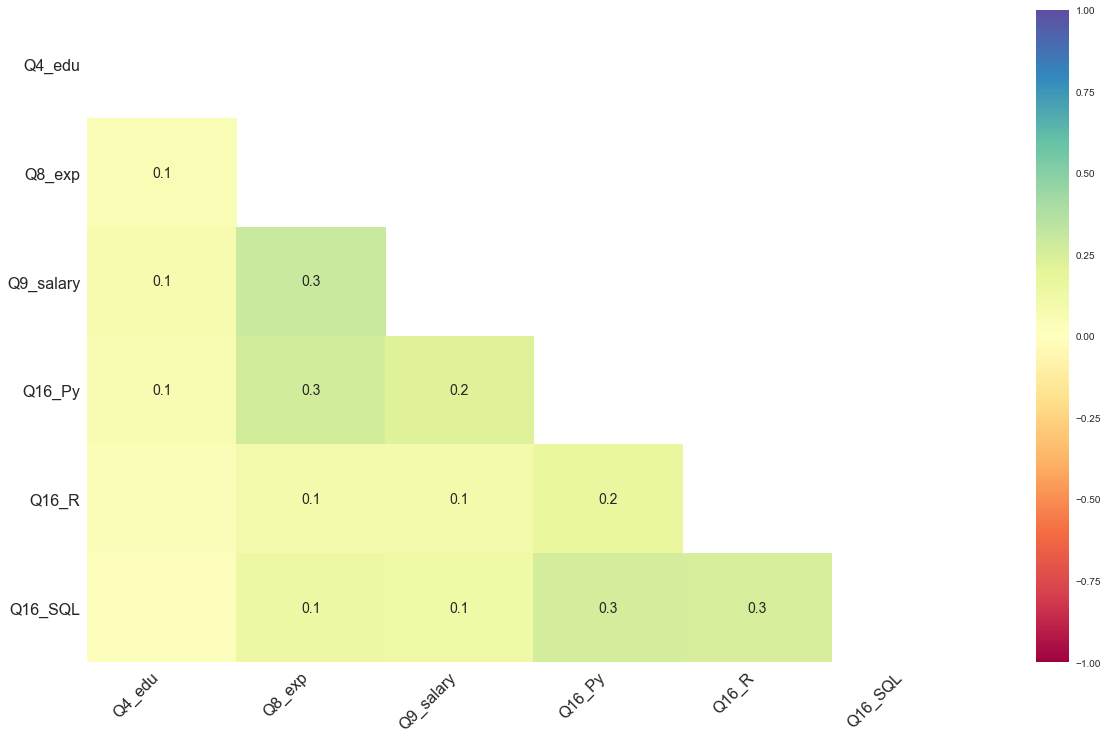

In [29]:
# nullity correlation
ax = mn.heatmap(X_bin, cmap='Spectral')

In [30]:
kag.fillna(0).corr()

Q1_Male    Q2_age  Q3_United States of America  \
Q1_Male                      1.000000  0.033629                    -0.084065   
Q2_age                       0.033629  1.000000                     0.132143   
Q3_United States of America -0.084065  0.132143                     1.000000   
Q3_India                     0.033843 -0.198489                    -0.236578   
Q3_China                    -0.000775 -0.116152                    -0.135024   
Q4_edu                      -0.006602  0.115733                     0.065516   
Q5_eng                       0.061244  0.033090                     0.004552   
Q5_other                    -0.046436  0.120333                     0.115733   
Q5_stat                     -0.052850  0.013775                     0.042172   
Q6_Data Scientist            0.005684  0.019171                     0.035660   
Q6_Software Engineer         0.058761  0.013876                    -0.032322   
Q6_Consultant                0.018565  0.147834                     0.011704   
Q8_exp                       0.050634  0.585056                     0.075847   
Q9_salary                    0.039703  0.346426                     0.337272   
Q16_Py                       0.076258  0.025954                     0.001896   
Q16_R                       -0.048019  0.108691                     0.100921   
Q16_SQL                     -0.006429  0.098681                     0.084695   

                             Q3_India  Q3_China    Q4_edu    Q5_eng  Q5_other  \
Q1_Male                      0.033843 -0.000775 -0.006602  0.061244 -0.046436   
Q2_age                      -0.198489 -0.116152  0.115733  0.033090  0.120333   
Q3_United States of America -0.236578 -0.135024  0.065516  0.004552  0.115733   
Q3_India                     1.000000 -0.129664 -0.059726  0.104907 -0.158682   
Q3_China                    -0.129664  1.000000 -0.062286 -0.012926 -0.000941   
Q4_edu                      -0.059726 -0.062286  1.000000  0.061781 -0.118102   
Q5_eng                       0.104907 -0.012926  0.061781  1.000000 -0.298075   
Q5_other                    -0.158682 -0.000941 -0.118102 -0.298075  1.000000   
Q5_stat                     -0.091178 -0.017227  0.072293 -0.161049 -0.261130   
Q6_Data Scientist           -0.048707 -0.078263  0.107691  0.000788 -0.022195   
Q6_Software Engineer         0.034375 -0.024346 -0.023965 -0.023326 -0.133993   
Q6_Consultant               -0.017741 -0.044611  0.021329  0.024717  0.025679   
Q8_exp                      -0.081214 -0.027371  0.098058  0.015871 -0.002832   
Q9_salary                   -0.180777 -0.098371  0.121327  0.019310  0.061467   
Q16_Py                      -0.012189 -0.004733  0.190415  0.044727 -0.083942   
Q16_R                       -0.022729 -0.101927  0.148231 -0.015744  0.056118   
Q16_SQL                     -0.025277 -0.091329  0.082231 -0.023531 -0.007262   

                              Q5_stat  Q6_Data Scientist  \
Q1_Male                     -0.052850           0.005684   
Q2_age                       0.013775           0.019171   
Q3_United States of America  0.042172           0.035660   
Q3_India                    -0.091178          -0.048707   
Q3_China                    -0.017227          -0.078263   
Q4_edu                       0.072293           0.107691   
Q5_eng                      -0.161049           0.000788   
Q5_other                    -0.261130          -0.022195   
Q5_stat                      1.000000           0.108797   
Q6_Data Scientist            0.108797           1.000000   
Q6_Software Engineer        -0.097683          -0.177971   
Q6_Consultant                0.014233          -0.084477   
Q8_exp                       0.010863          -0.085383   
Q9_salary                    0.042400           0.154968   
Q16_Py                      -0.002297           0.145166   
Q16_R                        0.188669           0.121992   
Q16_SQL                      0.039292           0.120178   

                             Q6_Software Engineer

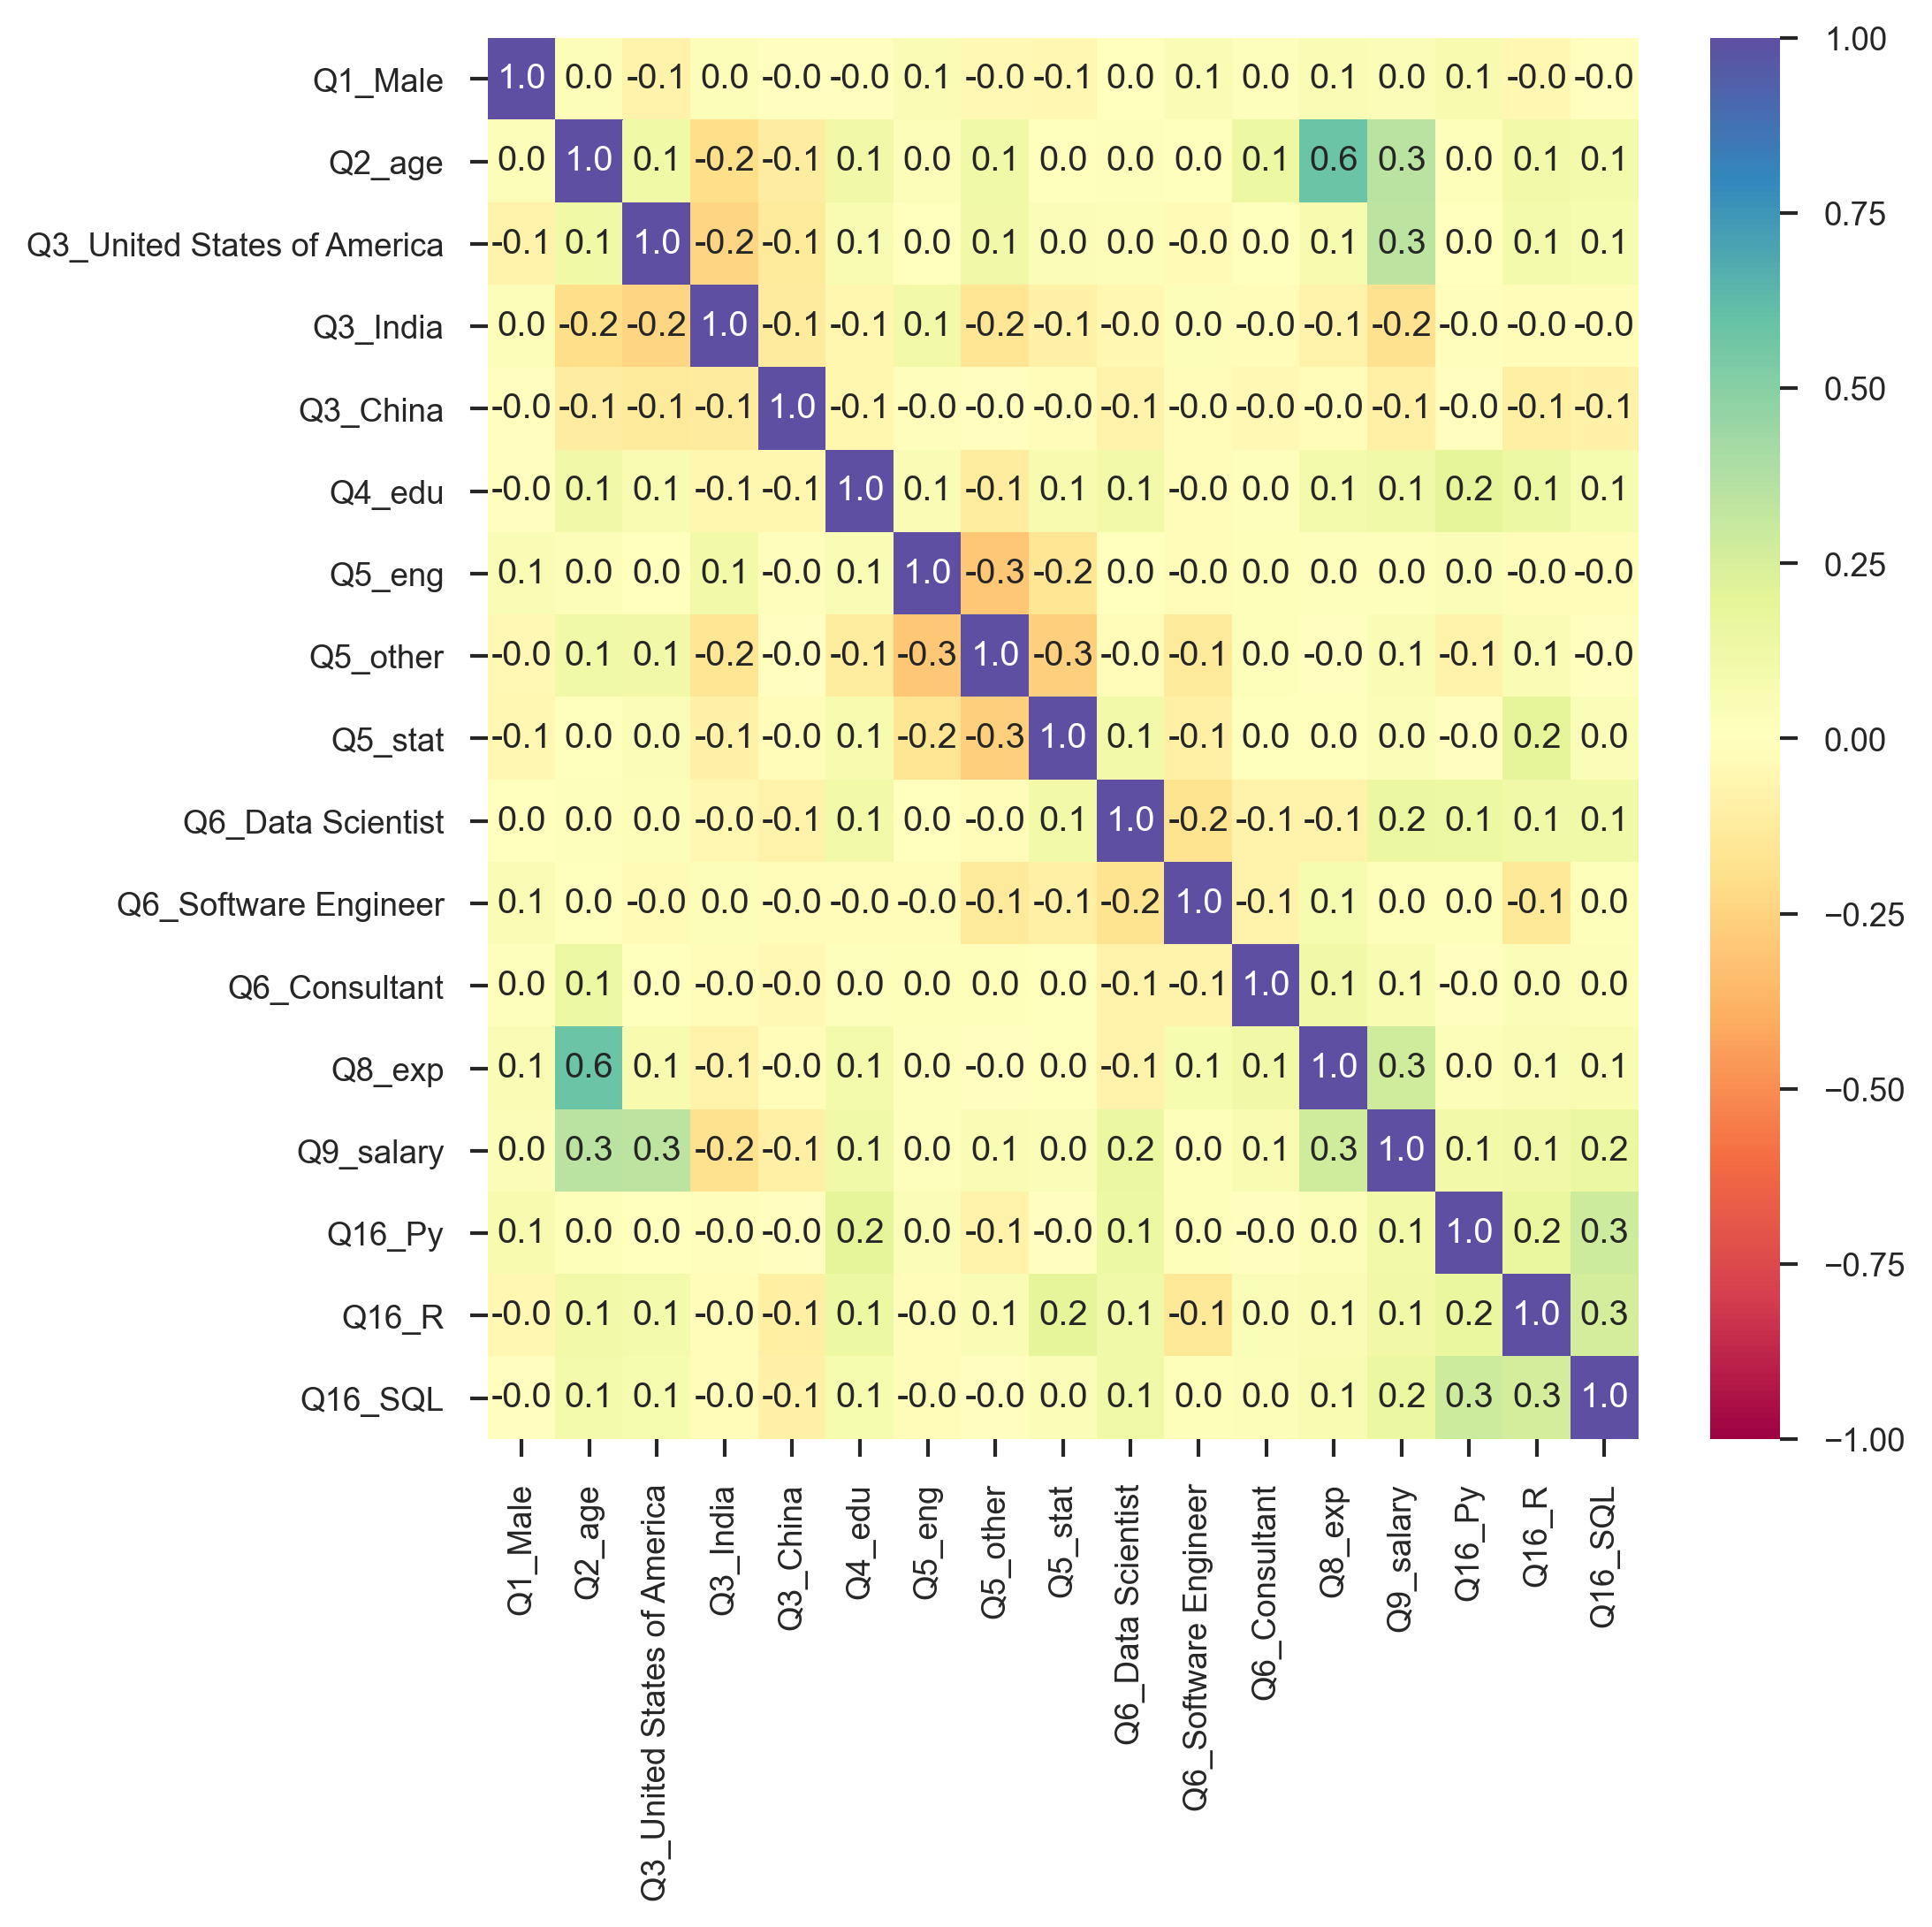

In [31]:
with sns.plotting_context('paper'):
    fig, ax = plt.subplots(figsize=(7,7), dpi=300)
    sns.heatmap(kag.fillna(0).corr(), cmap='Spectral', ax=ax, 
           vmin=-1, vmax=1, annot=True, fmt='.1f')

In [32]:
kag.columns

Index(['Q1_Male', 'Q2_age', 'Q3_United States of America', 'Q3_India',
       'Q3_China', 'Q4_edu', 'Q5_eng', 'Q5_other', 'Q5_stat',
       'Q6_Data Scientist', 'Q6_Software Engineer', 'Q6_Consultant', 'Q8_exp',
       'Q9_salary', 'Q16_Py', 'Q16_R', 'Q16_SQL'],
      dtype='object')

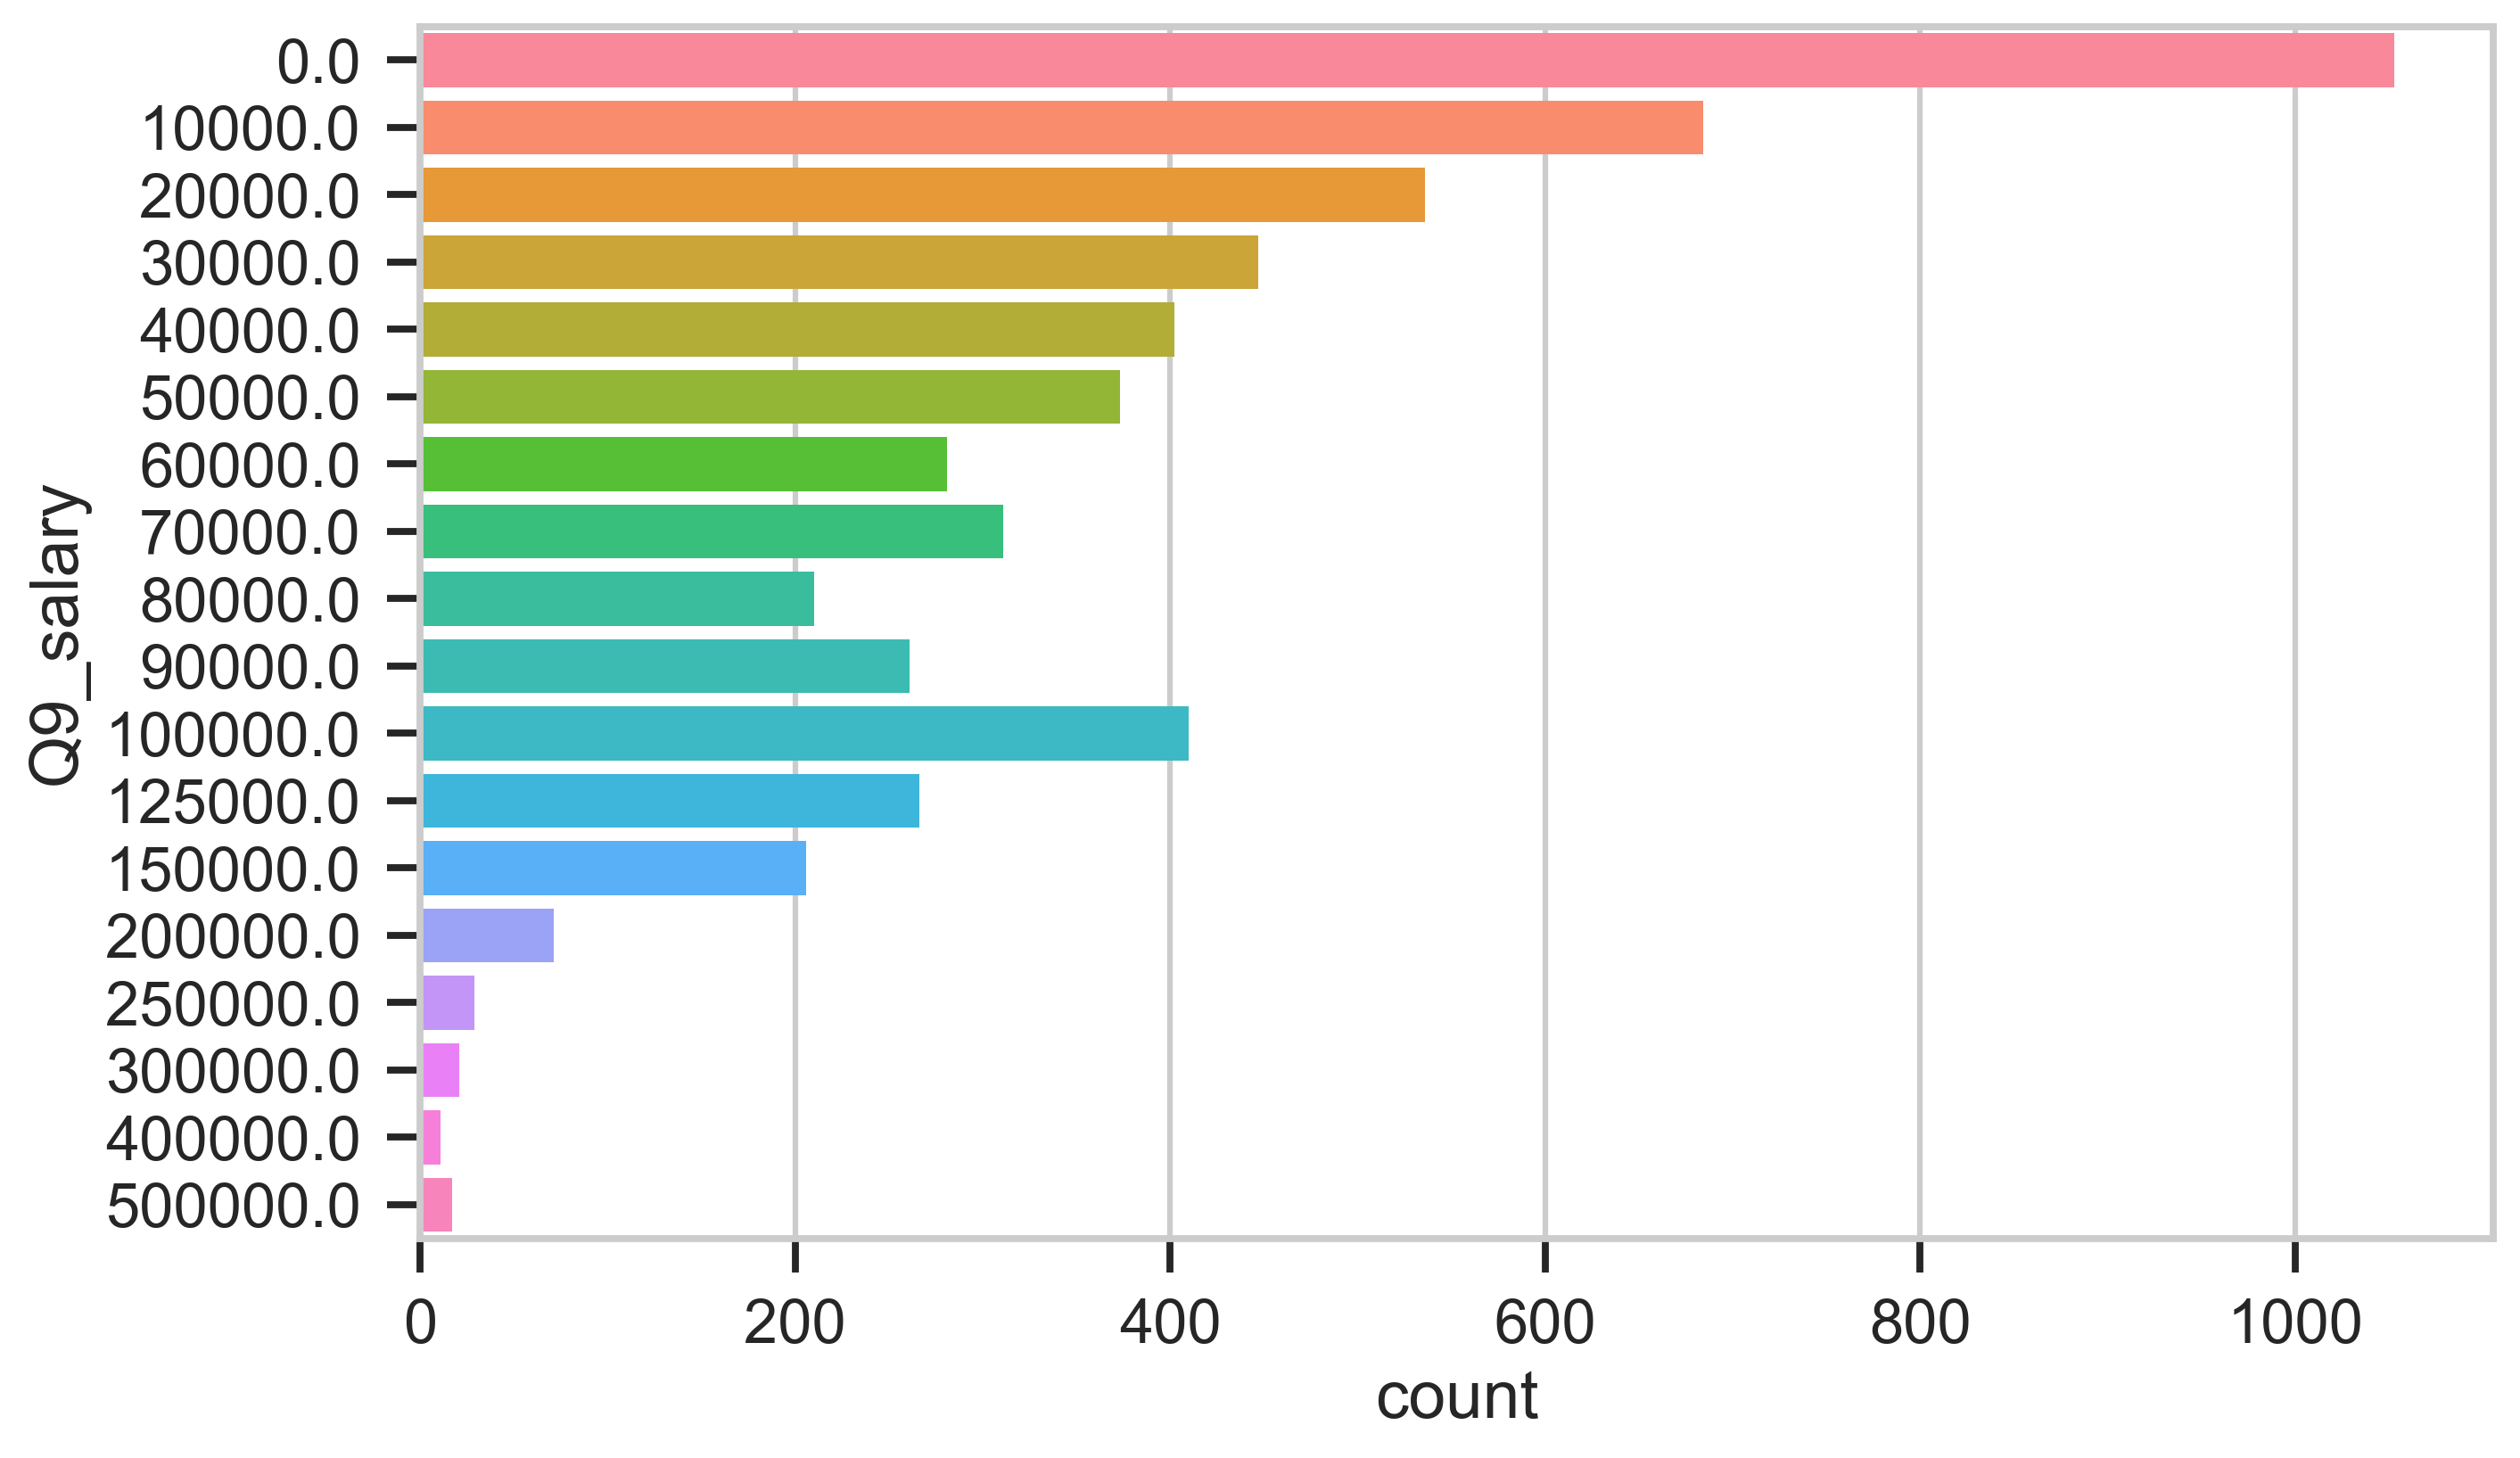

In [34]:
# Counts with Seaborn
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
    _ = sns.countplot(y='Q9_salary', data=X_bin, #palette=color_palette,
                     saturation=1, ax=ax)

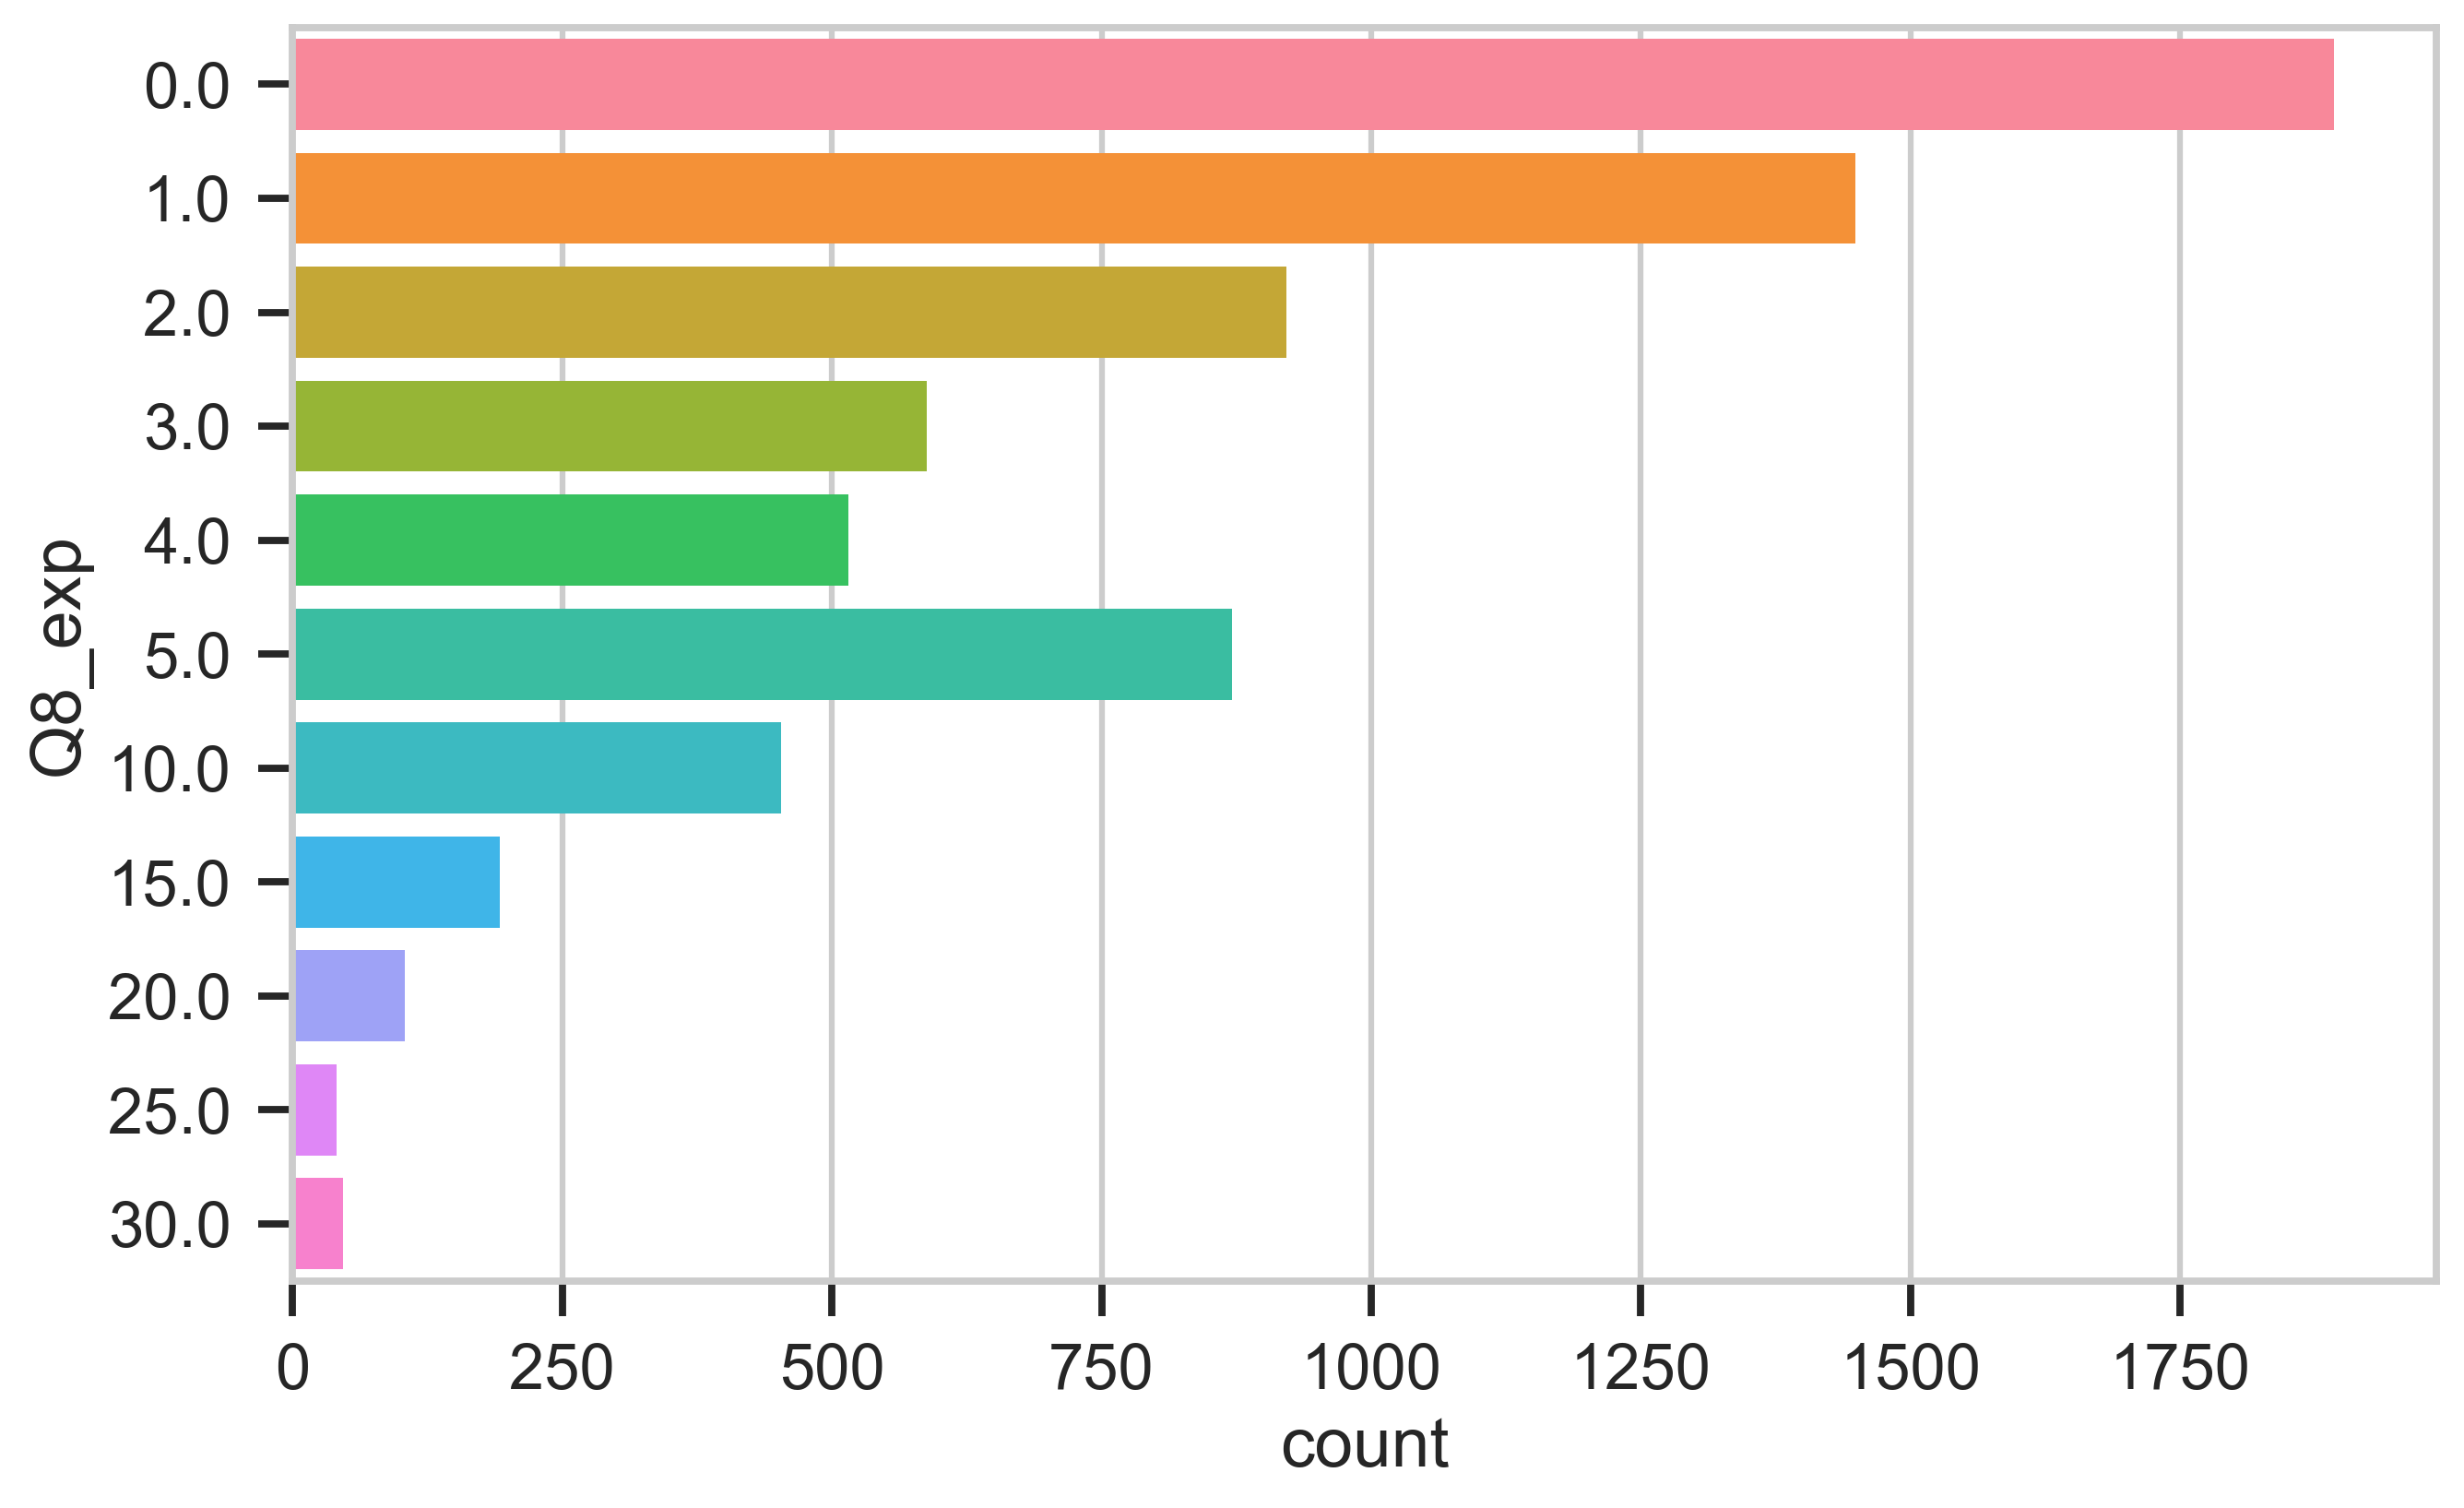

In [36]:
# Counts with Seaborn
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
    _ = sns.countplot(y='Q8_exp', data=X_bin, #palette=color_palette,
                 saturation=1, ax=ax)

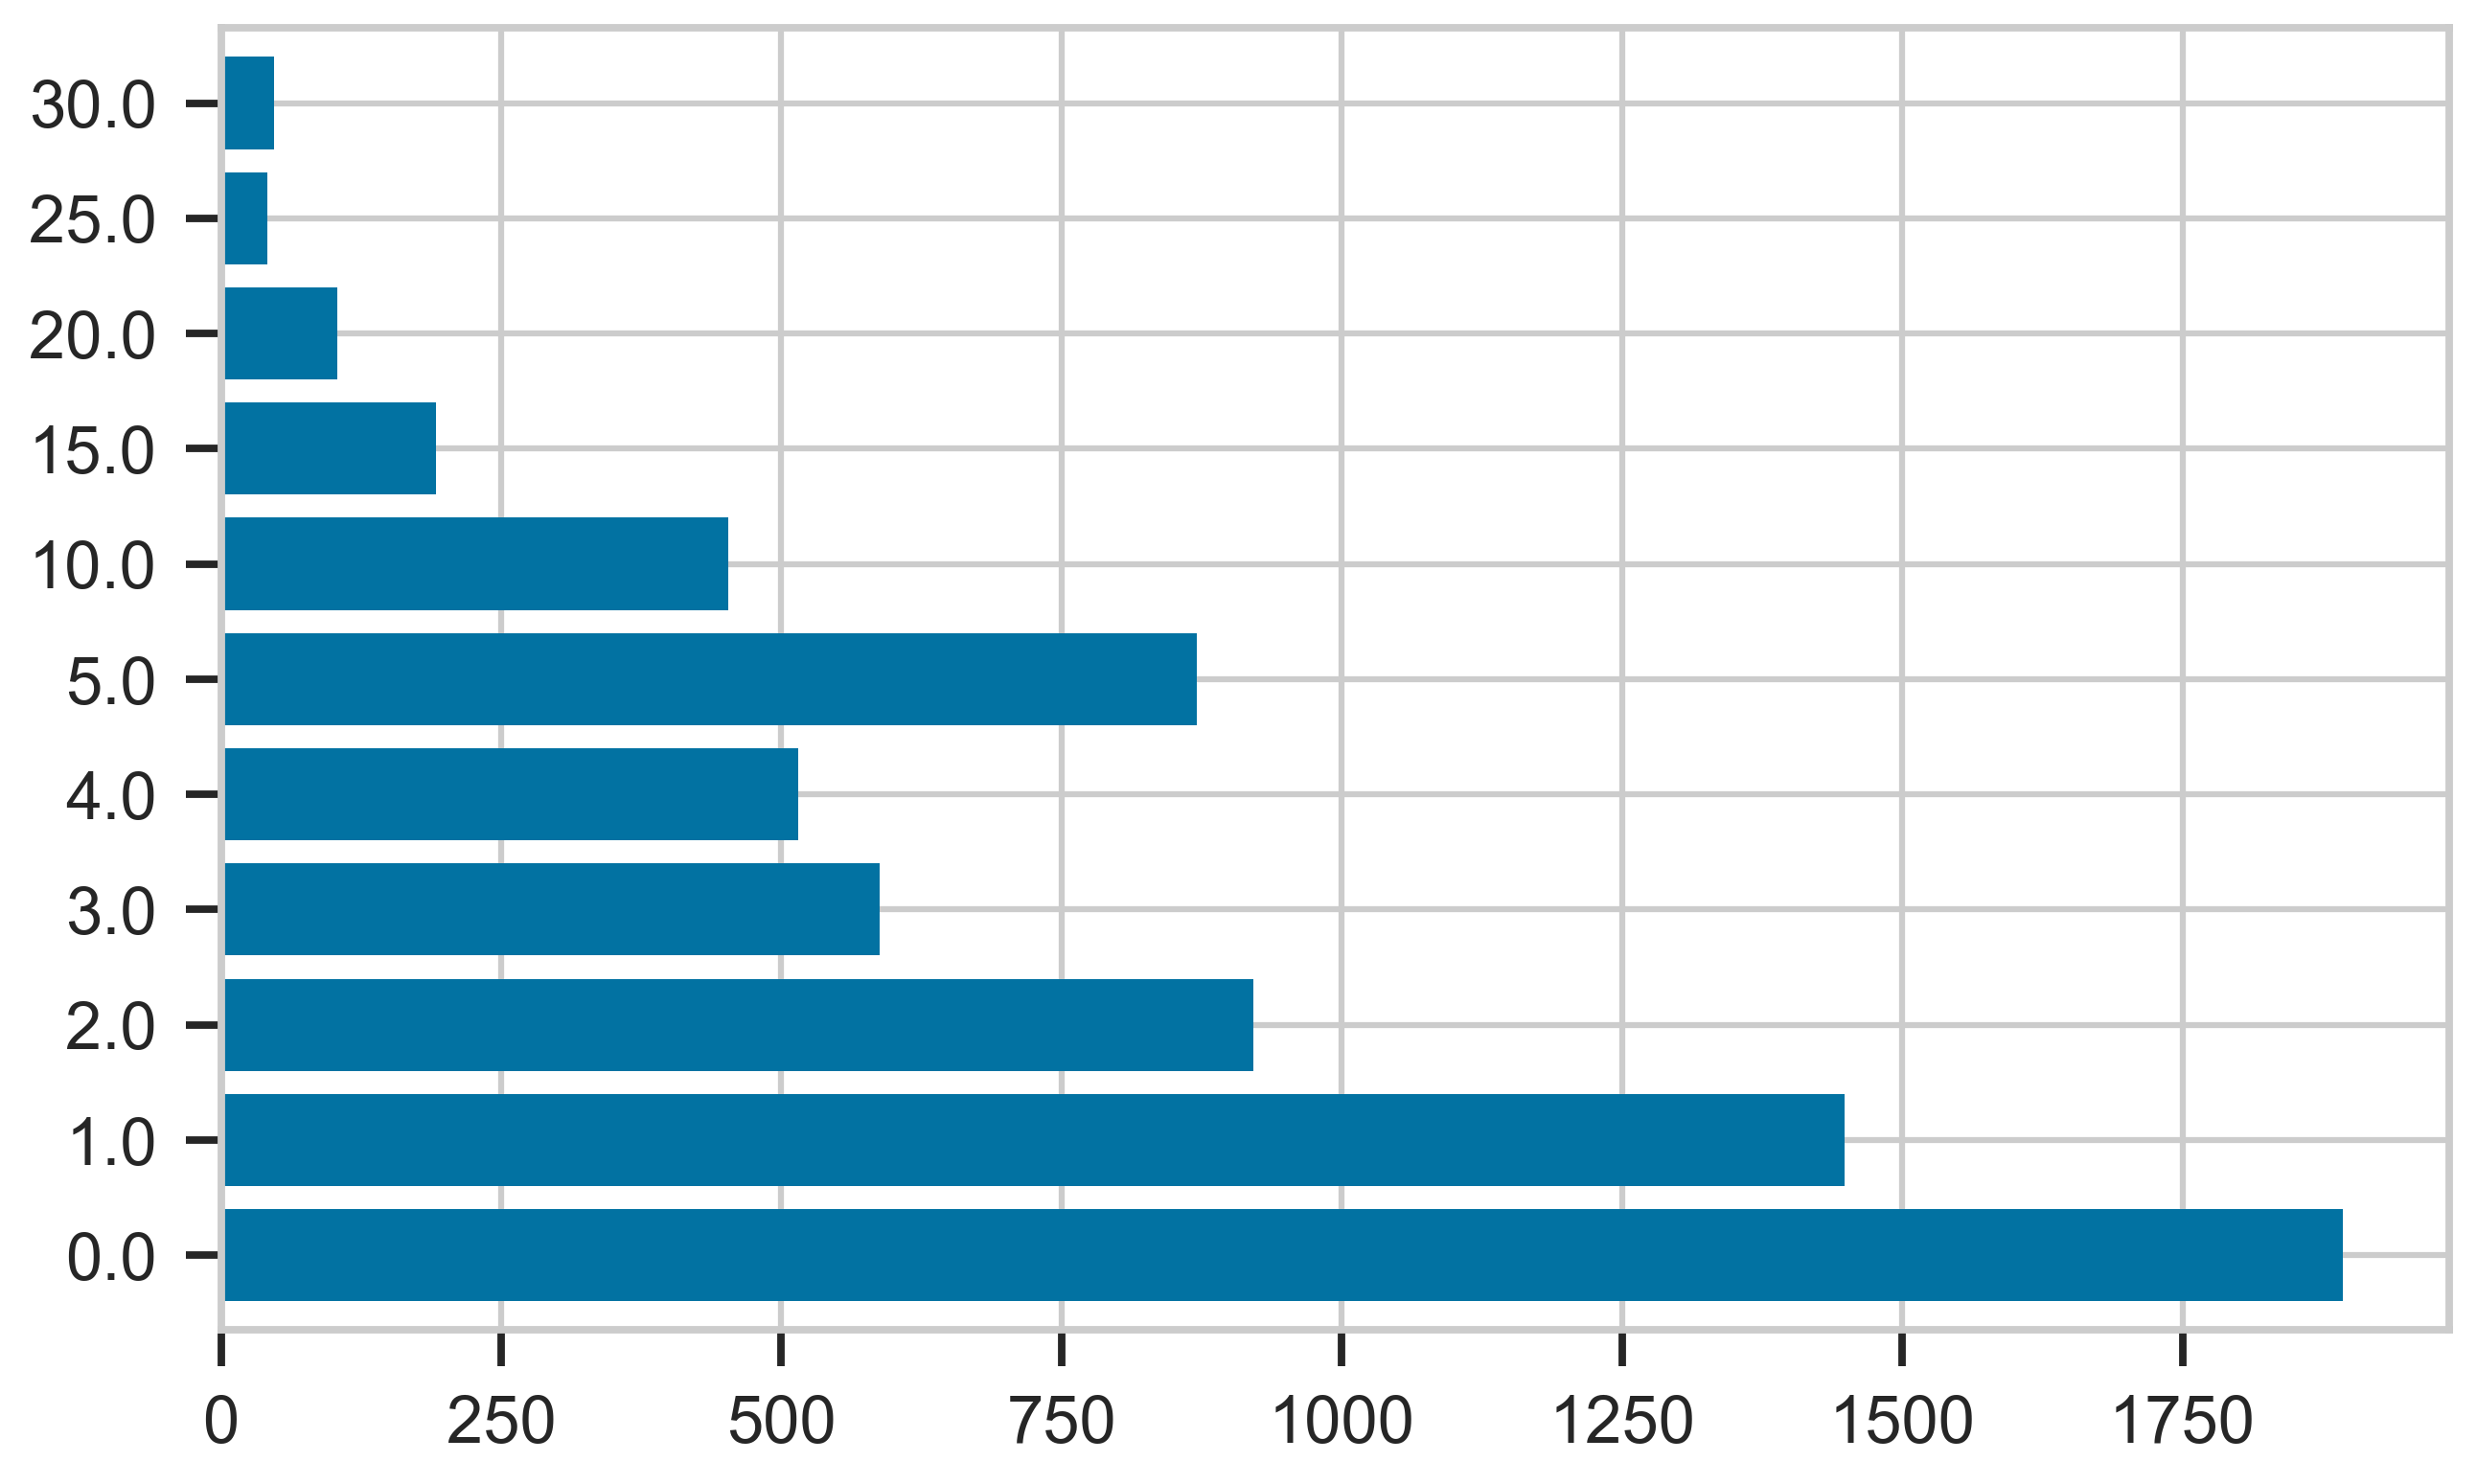

In [37]:
# Or with Pandas
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
    _ = X_bin.Q8_exp.value_counts().sort_index().plot.barh(width=.8, ax=ax)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


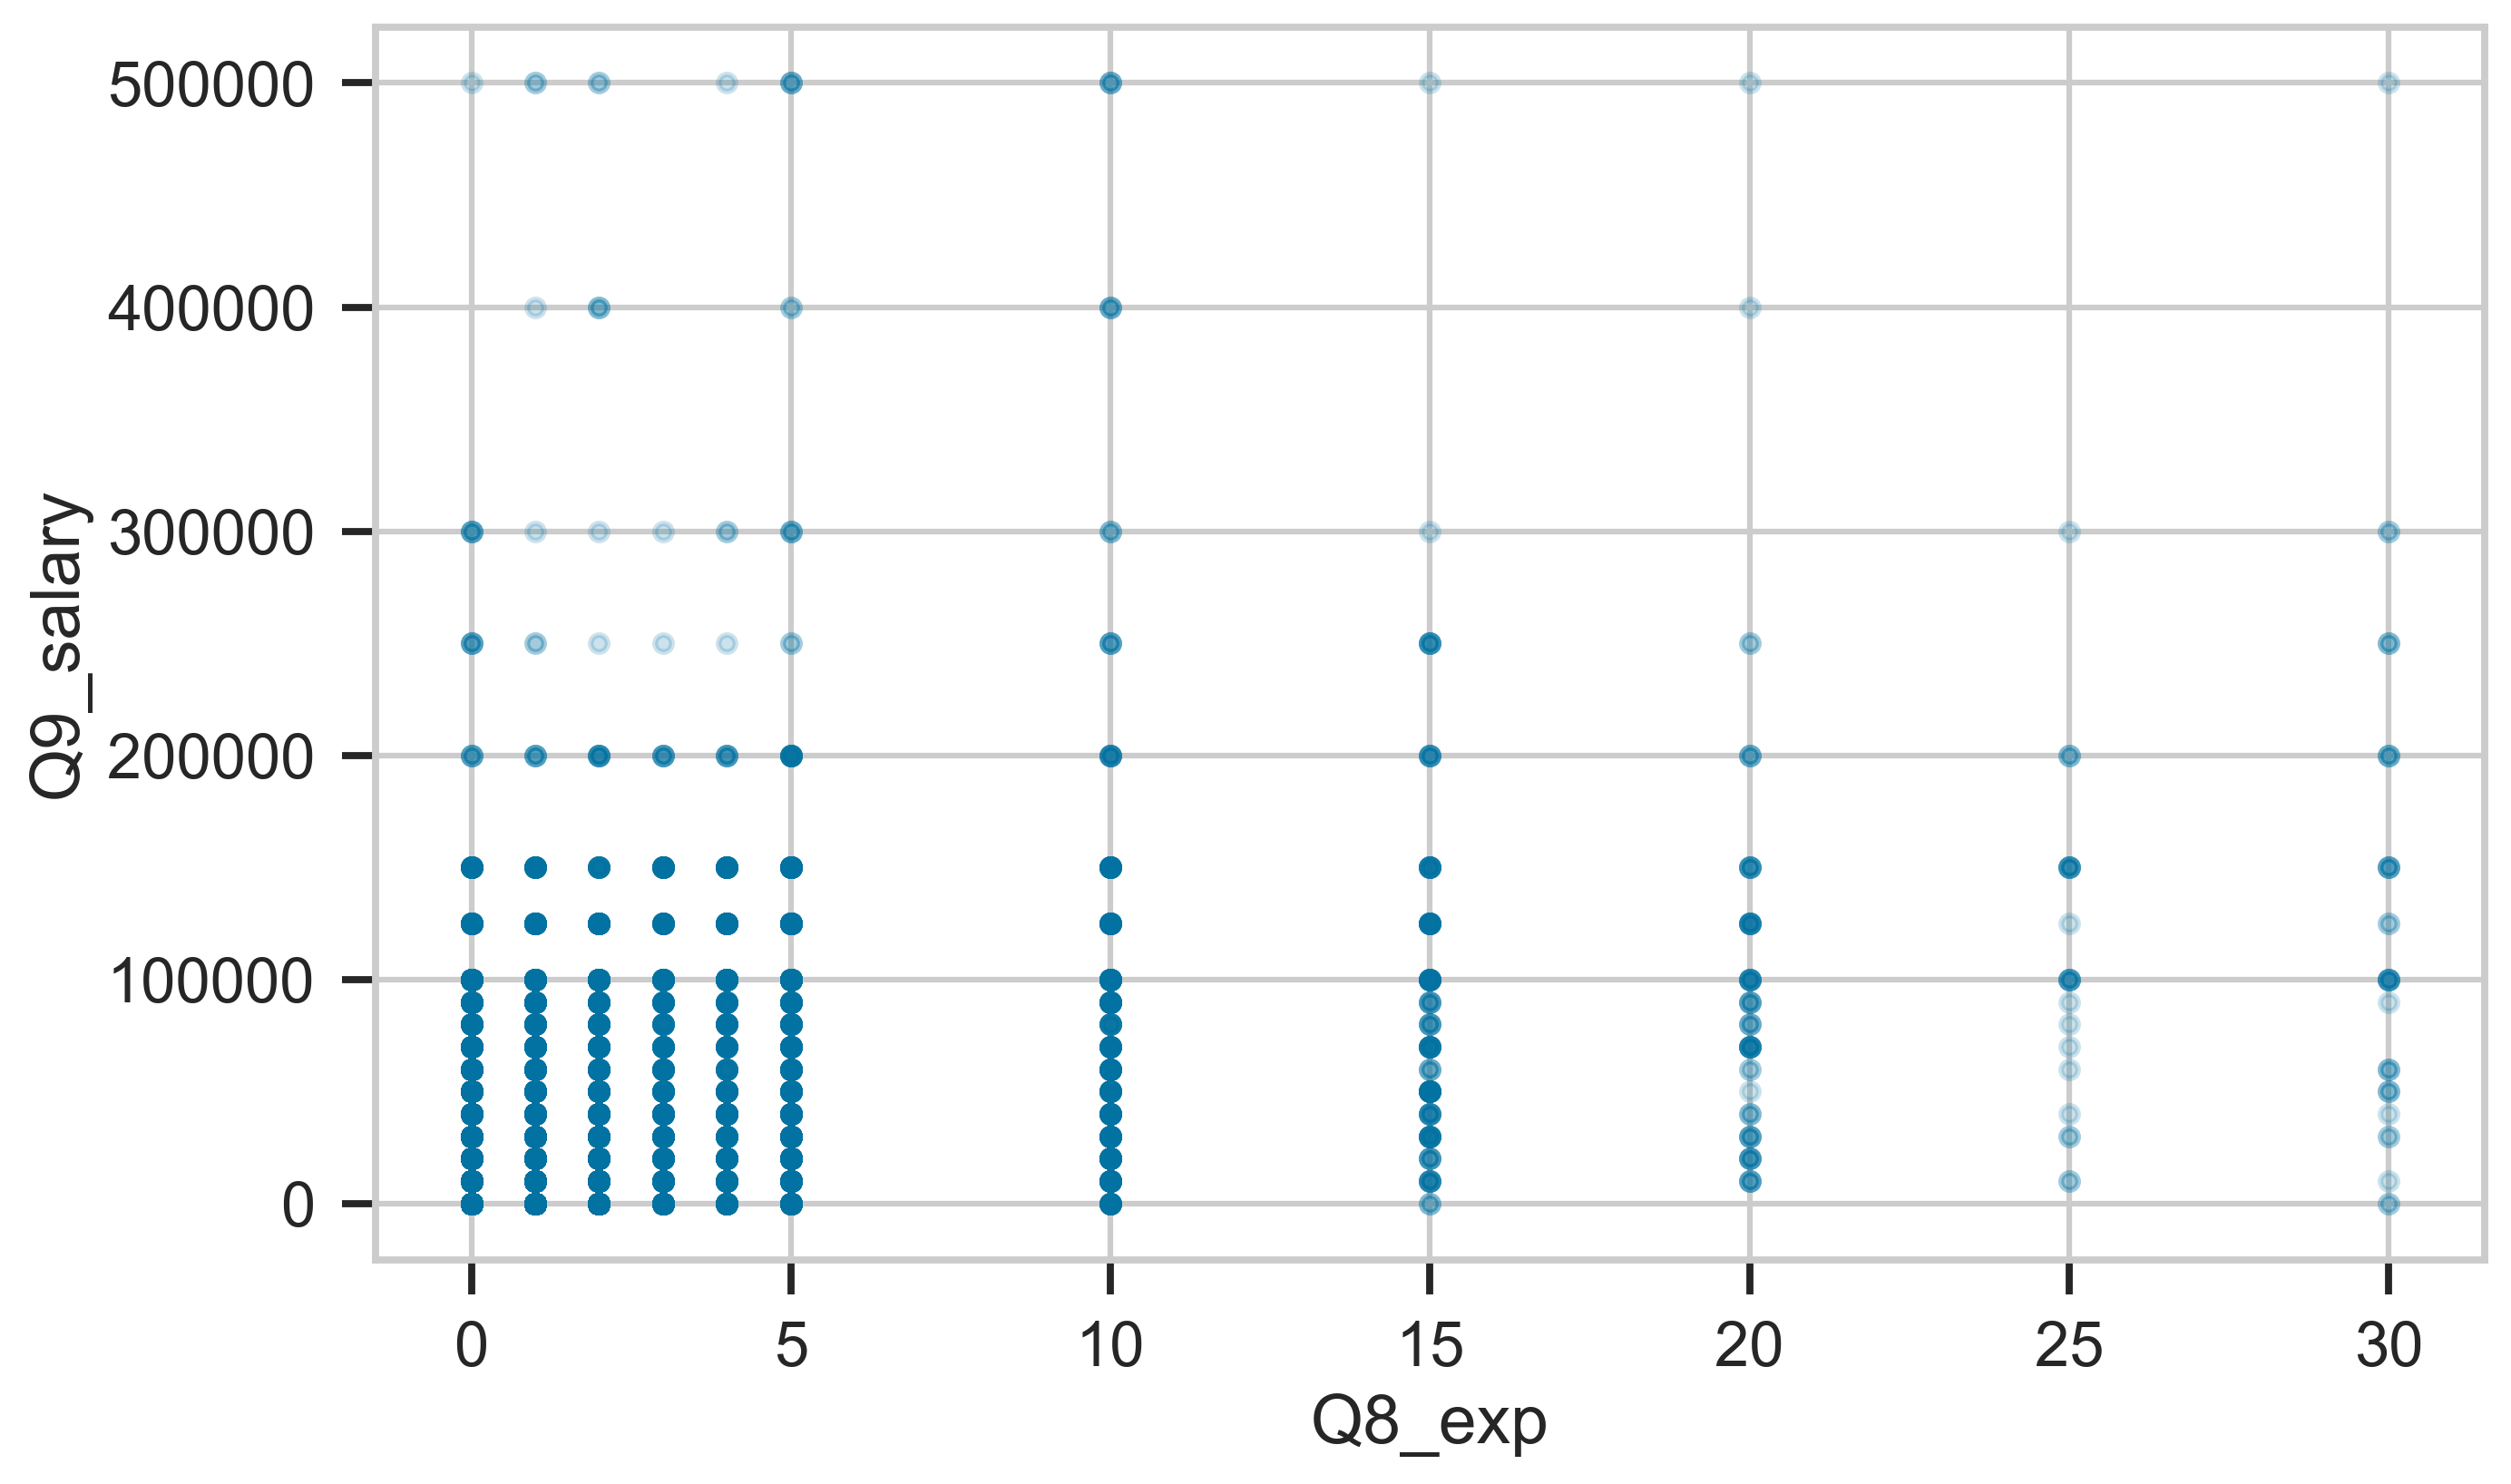

In [38]:
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
    X_bin.plot.scatter(x='Q8_exp', y='Q9_salary', alpha=.2, ax=ax)

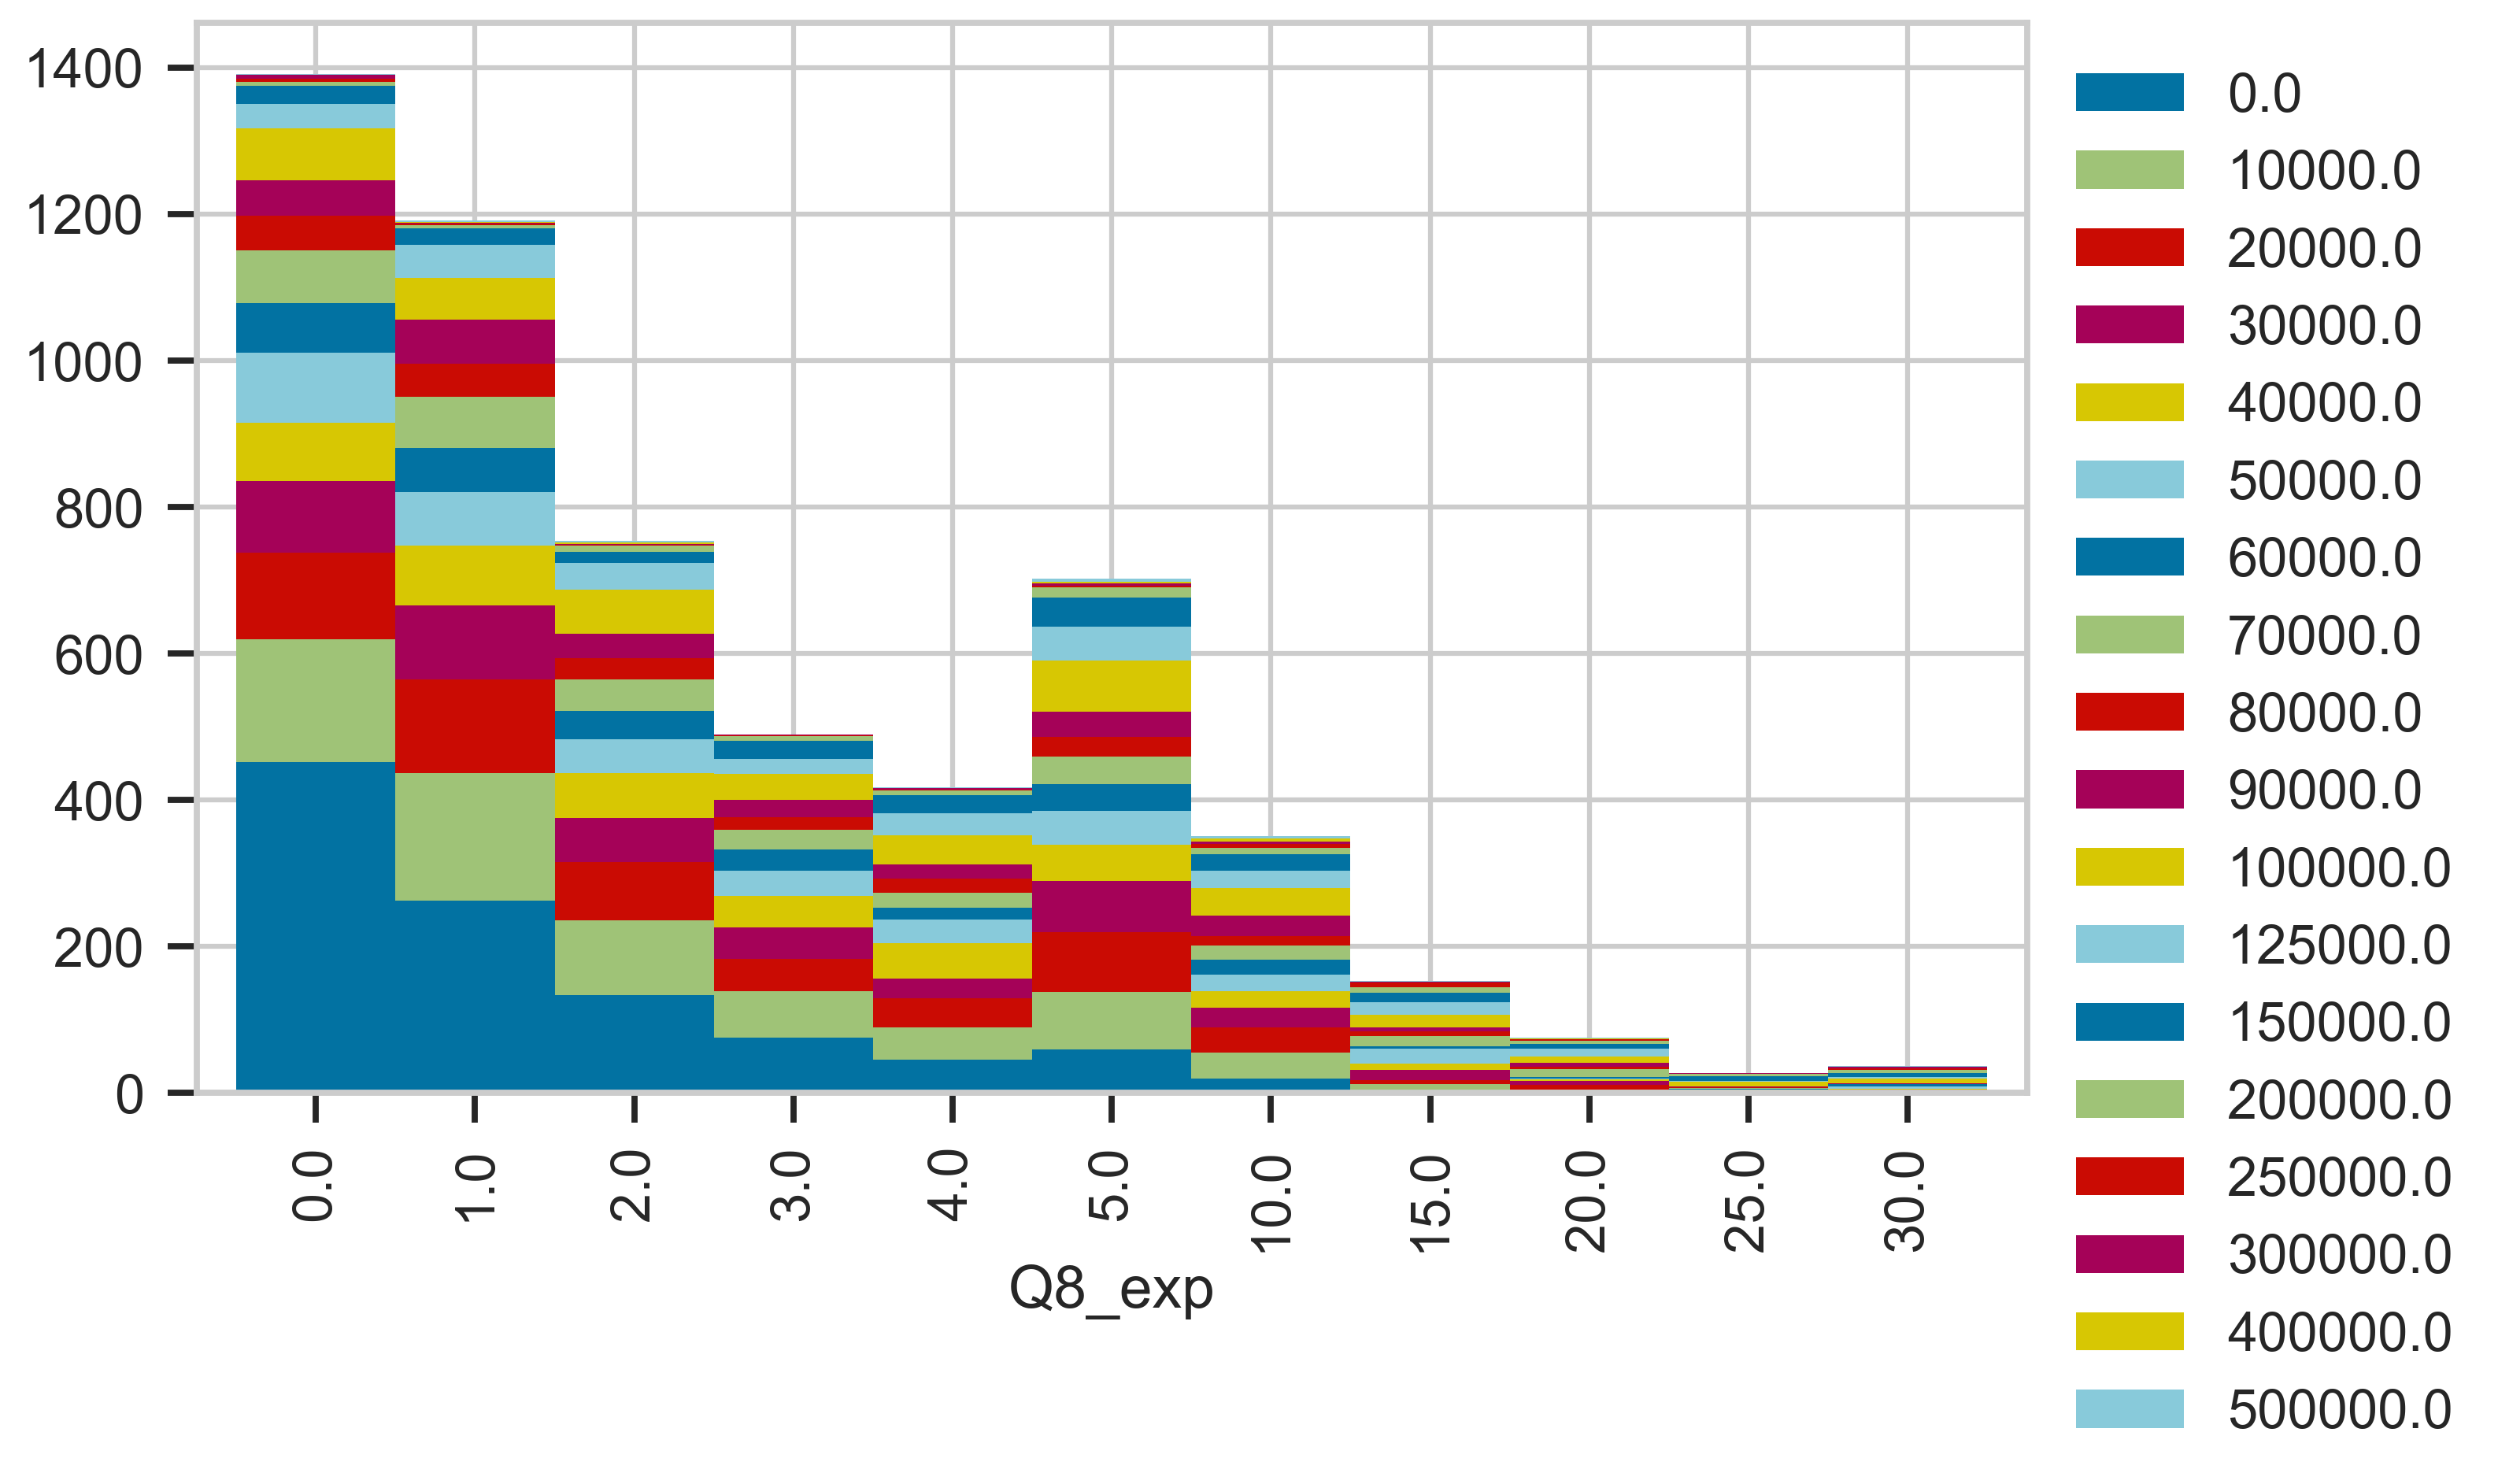

In [39]:
# another example - exp vs salary
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
    (X_bin
        .groupby(['Q8_exp', 'Q9_salary'])
        .size()
        .unstack()
        .plot.bar(stacked=True, width=1, ax=ax)
       .legend(bbox_to_anchor=(1,1))
    )

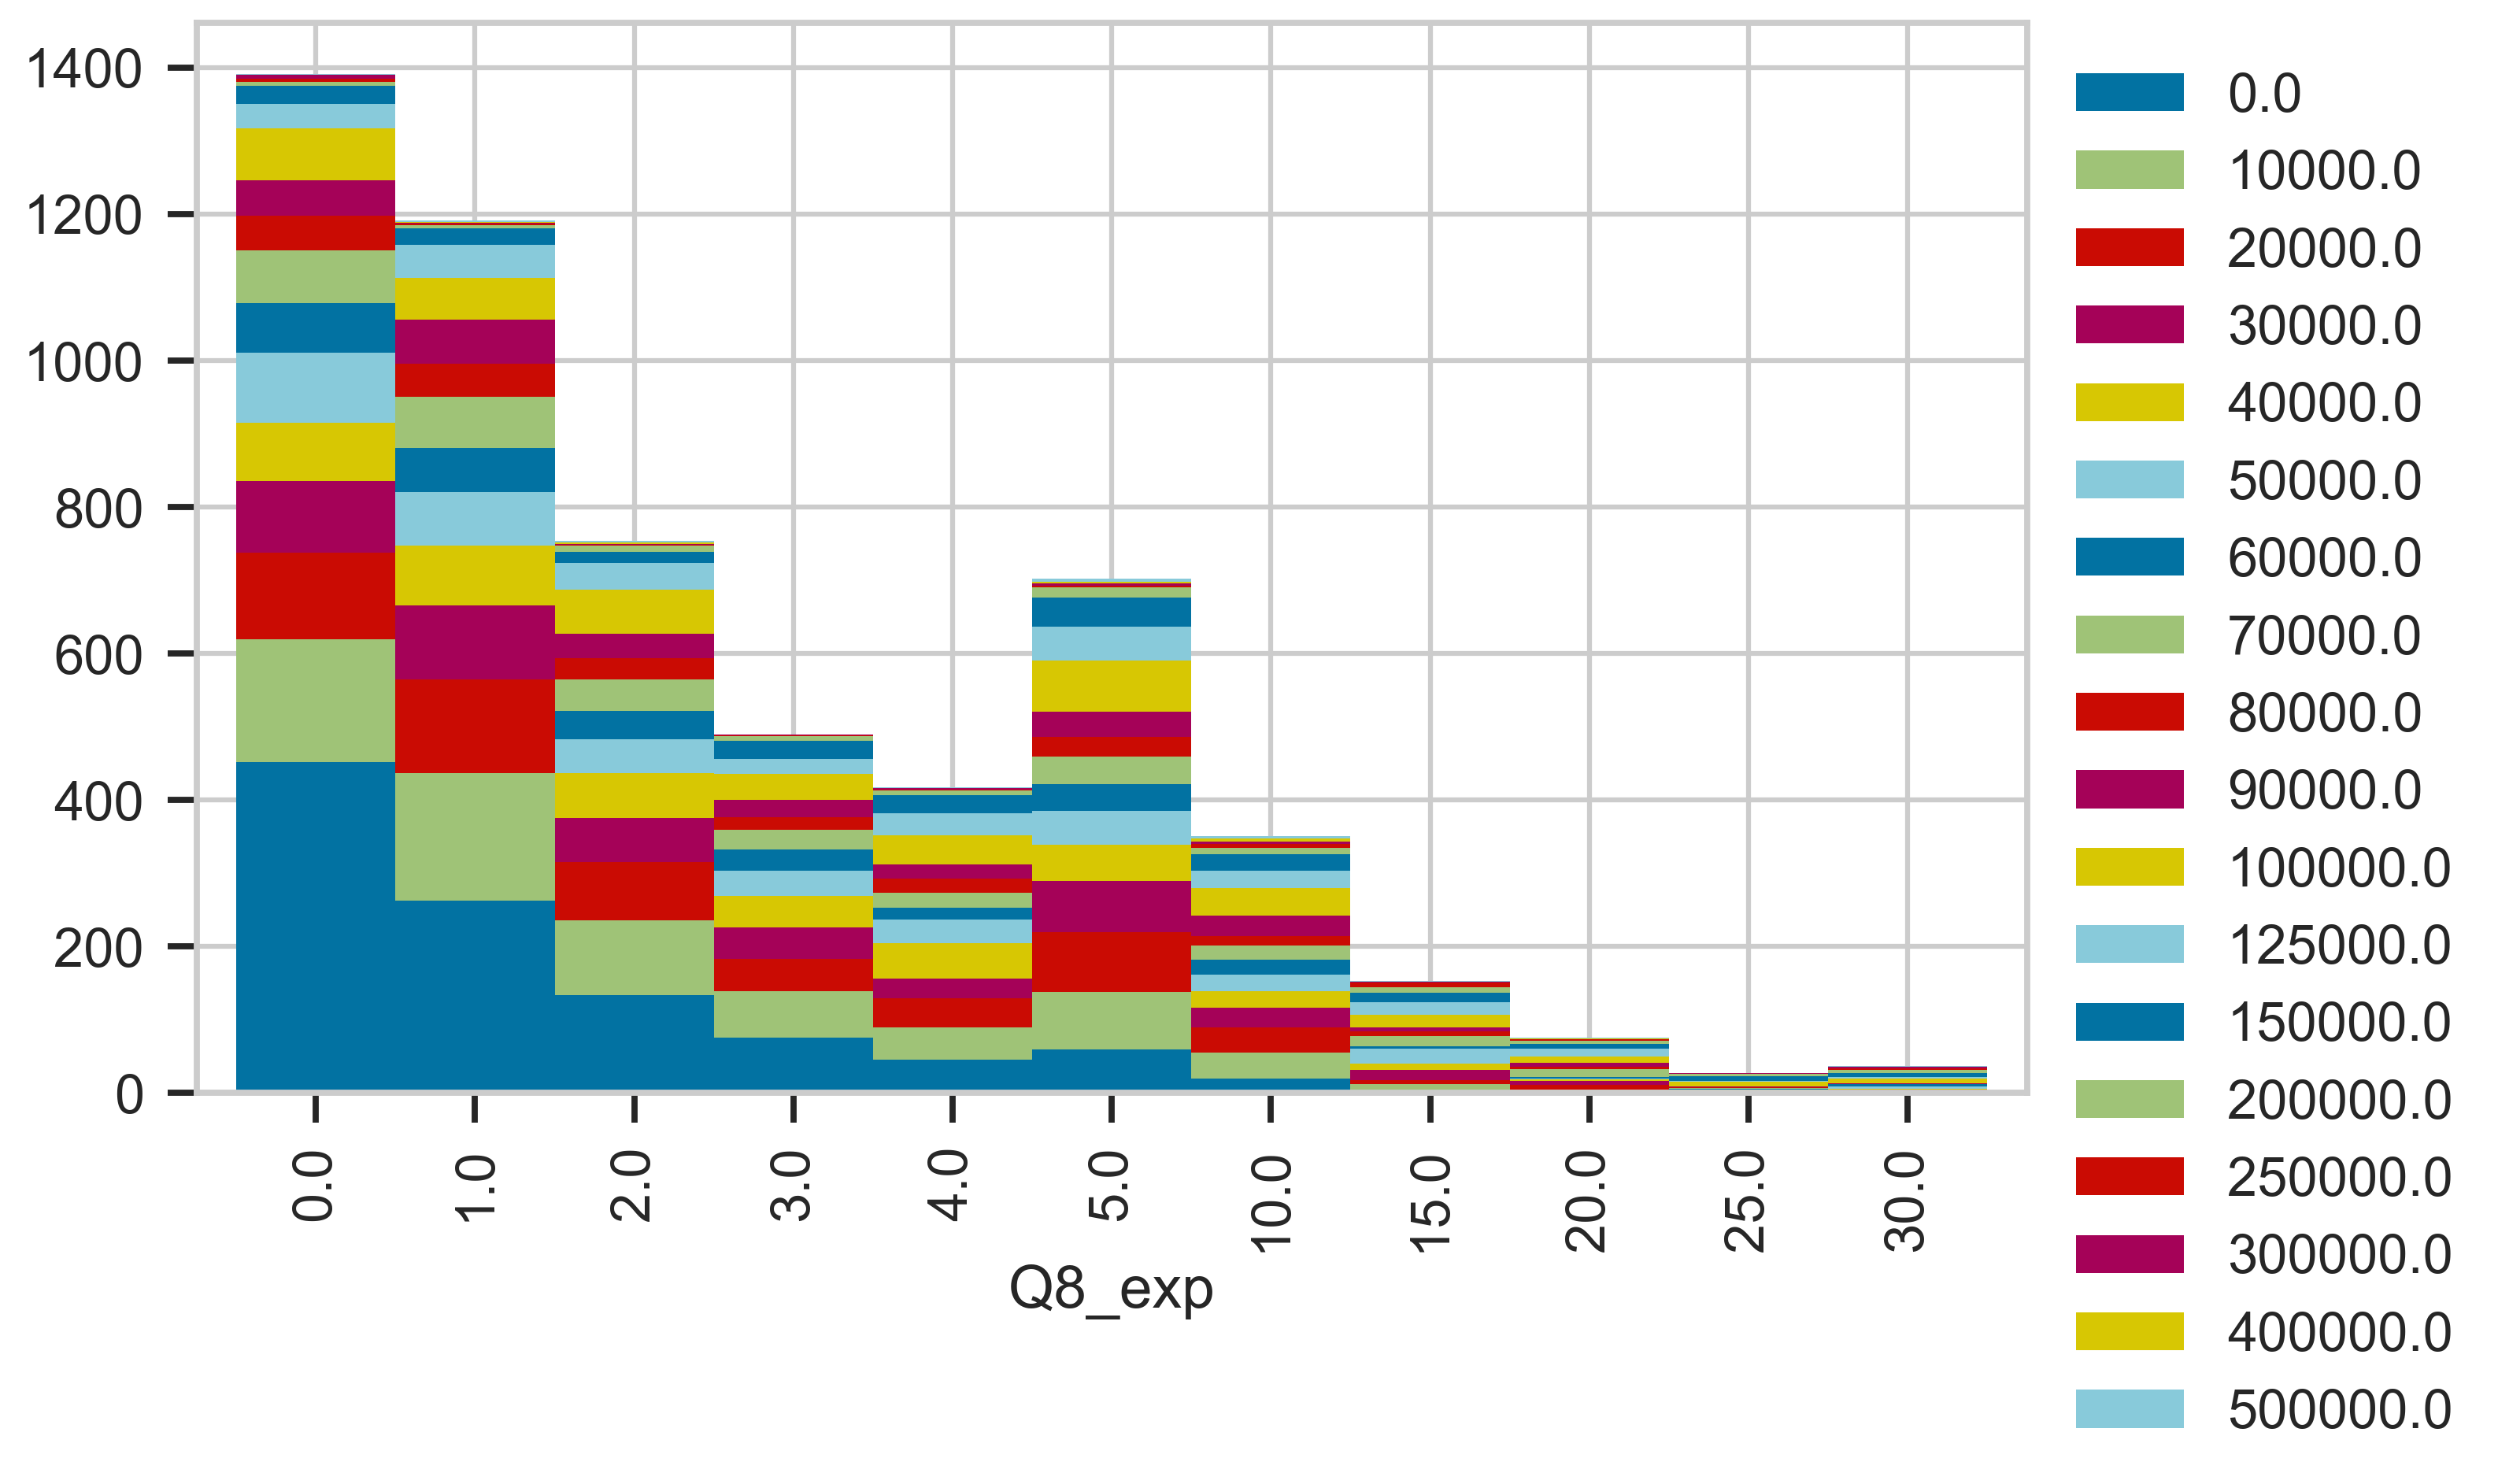

In [40]:
# Can do above with a pivot table as well
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
    (X_bin
        .groupby(['Q8_exp', 'Q9_salary'])
        .size()
        .reset_index()
        .pivot(columns='Q9_salary', index='Q8_exp', values=0)
        .plot.bar(stacked=True, width=1, ax=ax)
        .legend(bbox_to_anchor=(1,1))
    )

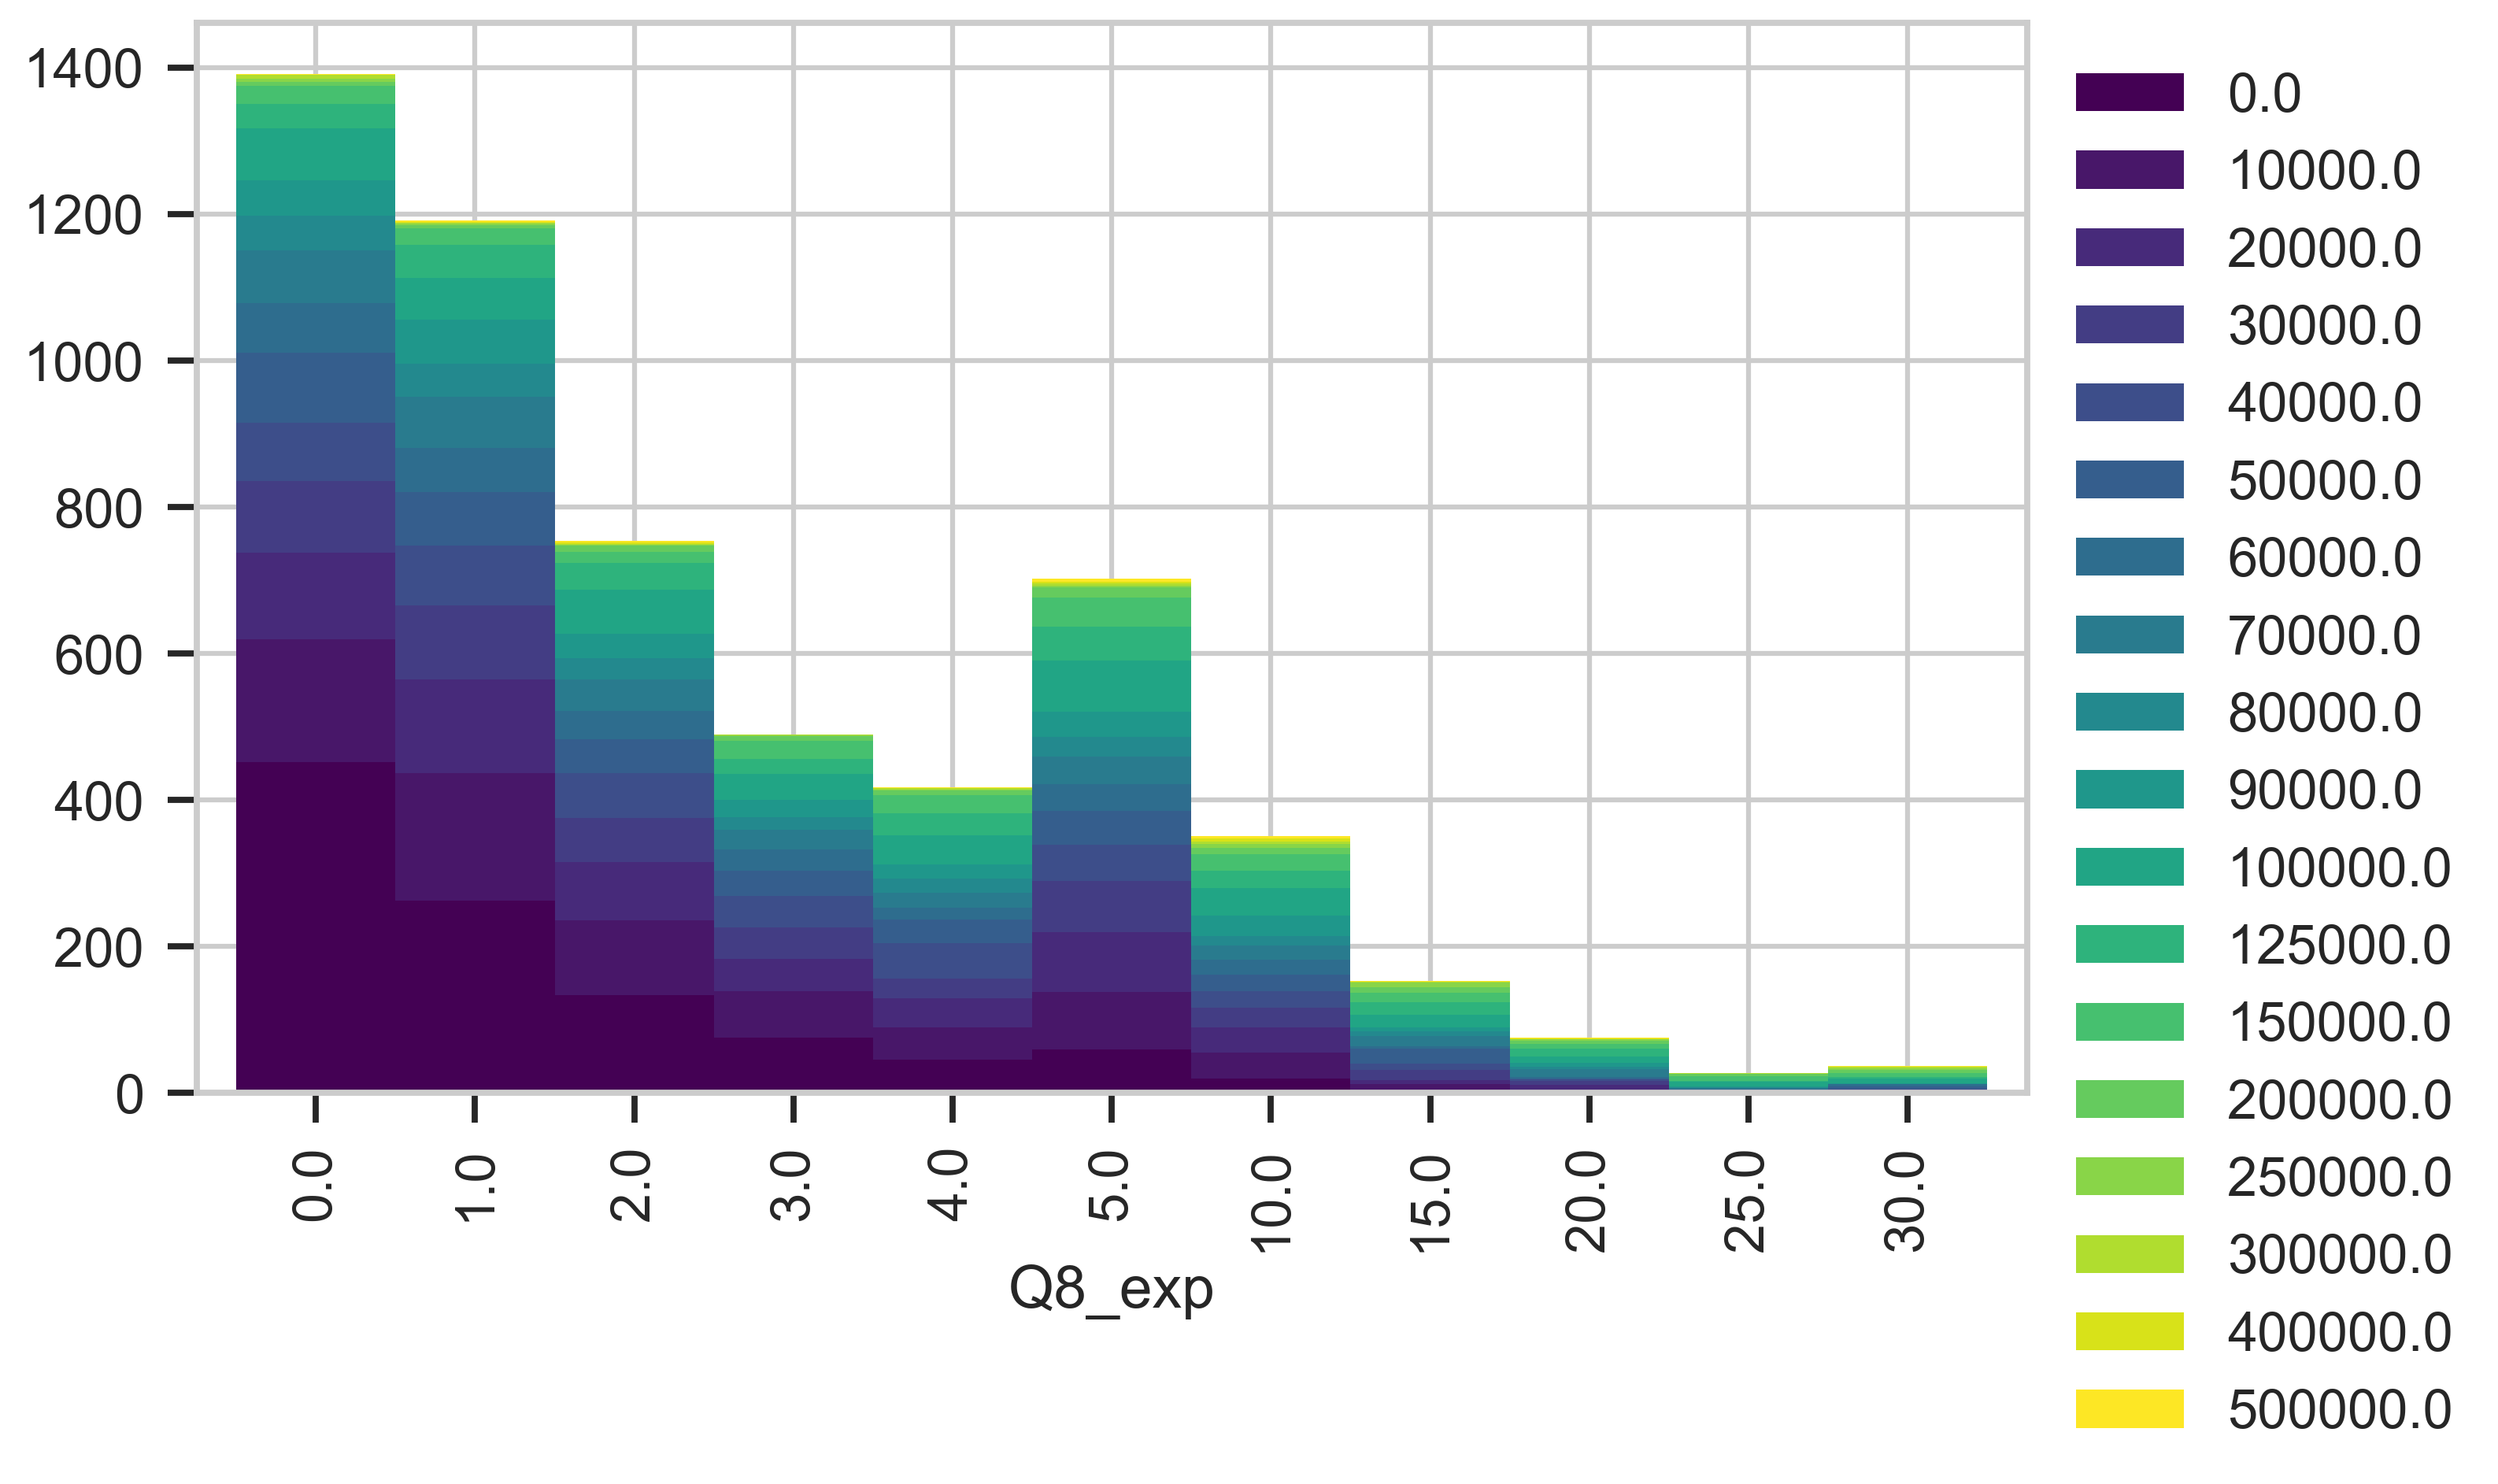

In [41]:
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
    (X_bin
        .groupby(['Q8_exp', 'Q9_salary'])
        .size()
        .unstack()
        .plot.bar(stacked=True, width=1, cmap='viridis', ax=ax)
        .legend(bbox_to_anchor=(1,1))
    )

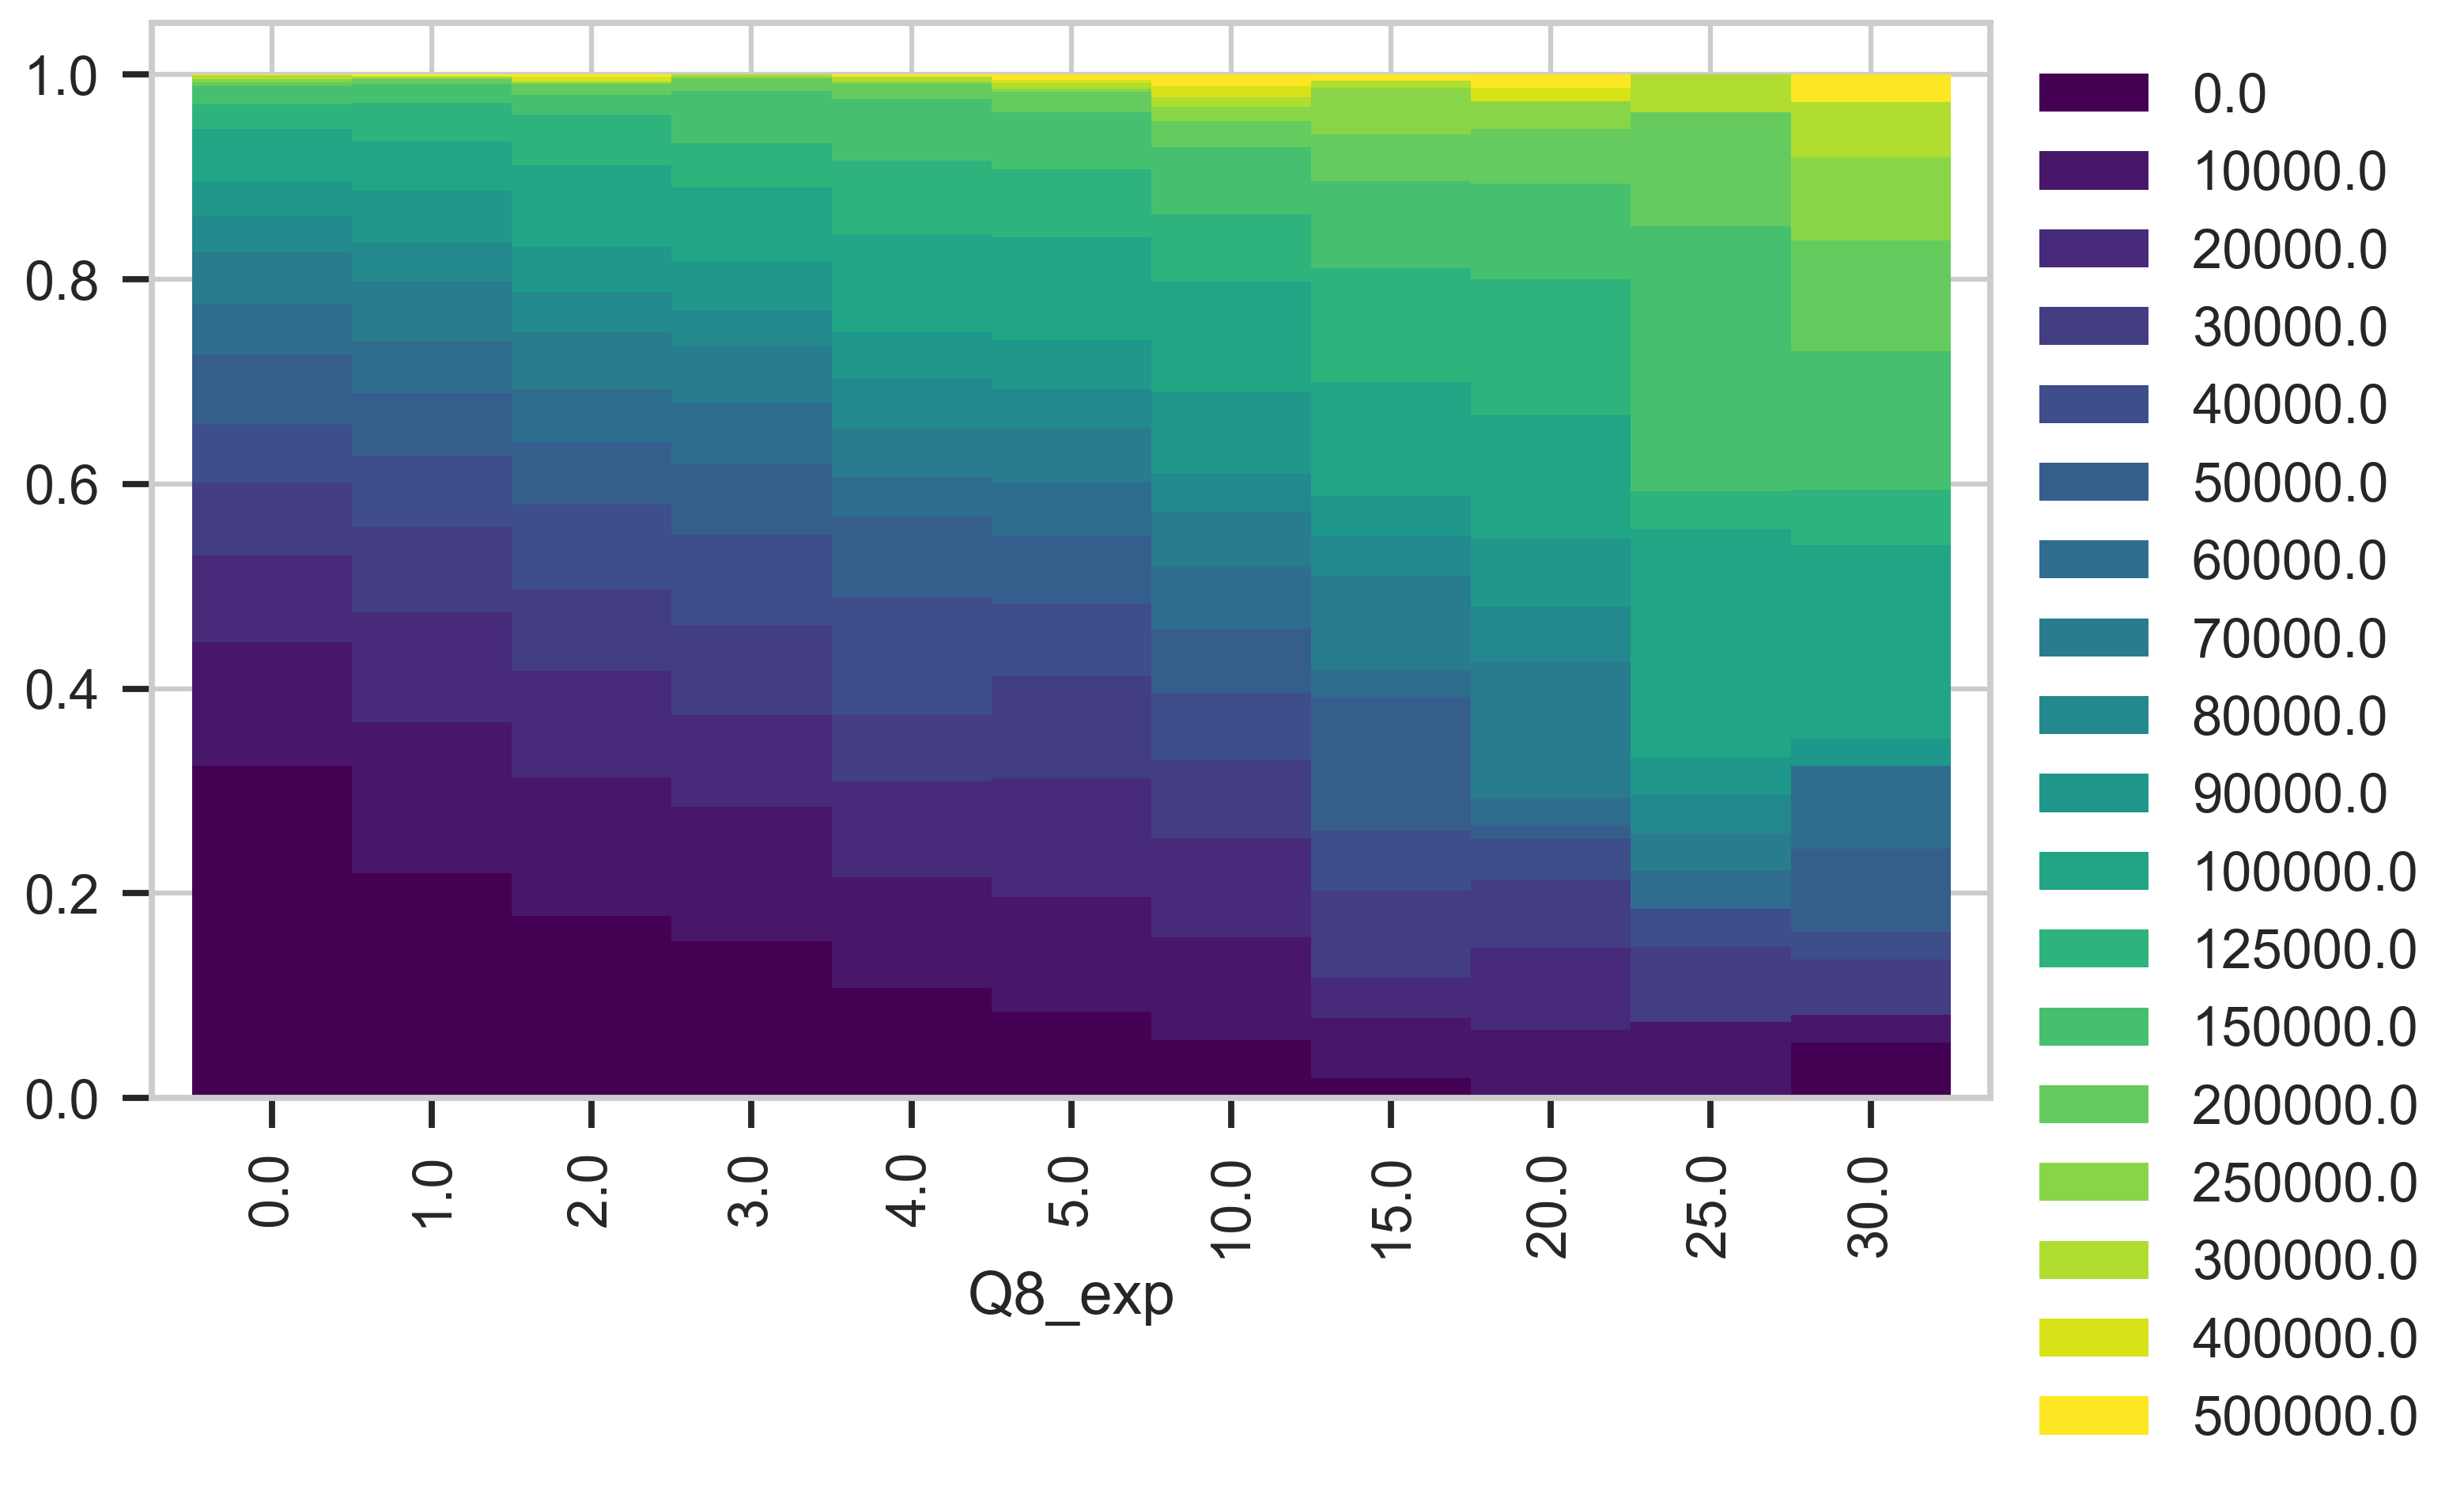

In [42]:
# normalized stacked plot

def div(df):
    return df.div(df.total, axis=0)

with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
    (X_bin
        .groupby(['Q8_exp', 'Q9_salary'])
        .size()
        .unstack()
        .assign(total=lambda df:df.sum(axis=1))
        .pipe(div)
        .drop(columns=['total'])
        .plot.bar(stacked=True, cmap='viridis', ax=ax, width=1)
        .legend(bbox_to_anchor=(1,1))
    )

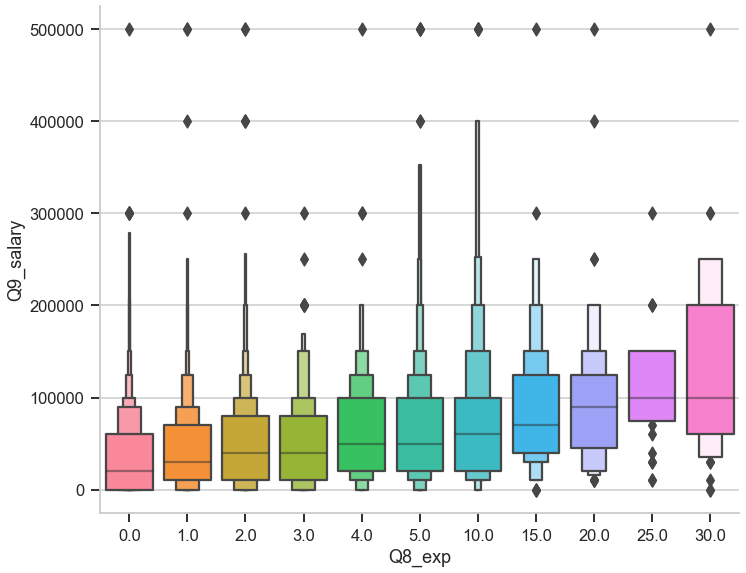

In [44]:
# Compare salary to experience
with sns.plotting_context('talk'):
    sns.catplot(y='Q9_salary', x='Q8_exp', data=X_bin, 
                kind='boxen', height=8, aspect=1.3, #palette=color_palette,
                saturation=1)

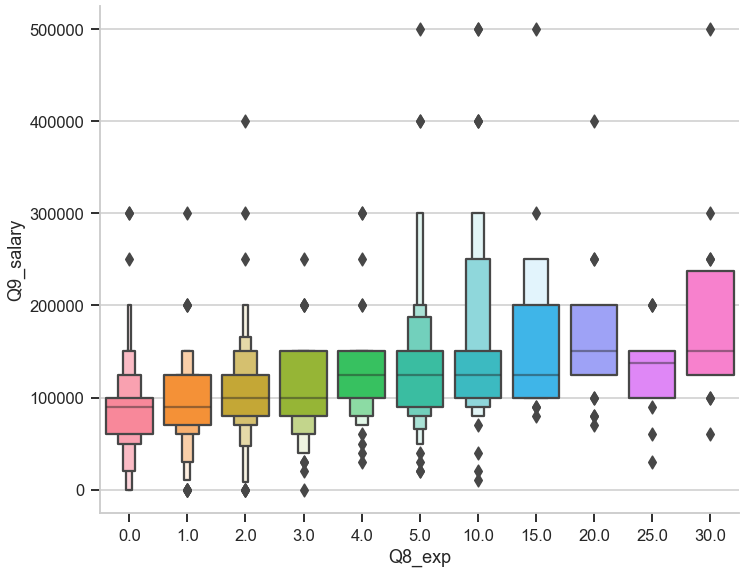

In [46]:
# Just US data
sns_kwargs = dict(#palette=color_palette,
    saturation=1)
with sns.plotting_context('talk'):
    sns.catplot(y='Q9_salary', x='Q8_exp', 
            data=X_bin[X_bin['Q3_United States of America'] == 1],
            kind='boxen', height=8, aspect=1.3, **sns_kwargs)

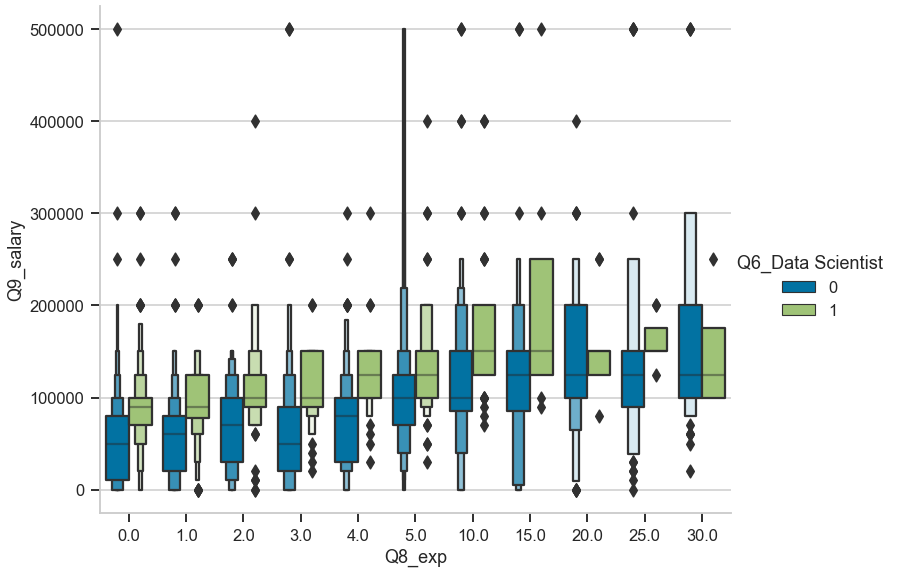

In [47]:
# DS vs SE in US (need to use kag)
with sns.plotting_context('talk'):
    sns.catplot(y='Q9_salary', x='Q8_exp', 
            data=kag[kag['Q3_United States of America'] == 1],
            hue='Q6_Data Scientist',
            kind='boxen', height=8, aspect=1.3, **sns_kwargs)

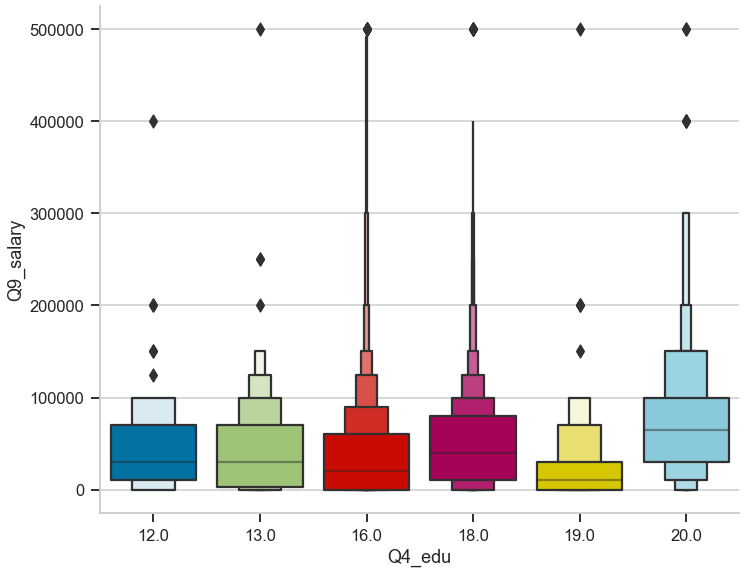

In [48]:
# What about salary vs education?
with sns.plotting_context('talk'):
    sns.catplot(y='Q9_salary', x='Q4_edu', data=X_bin, 
                kind='boxen', height=8, aspect=1.3, **sns_kwargs)

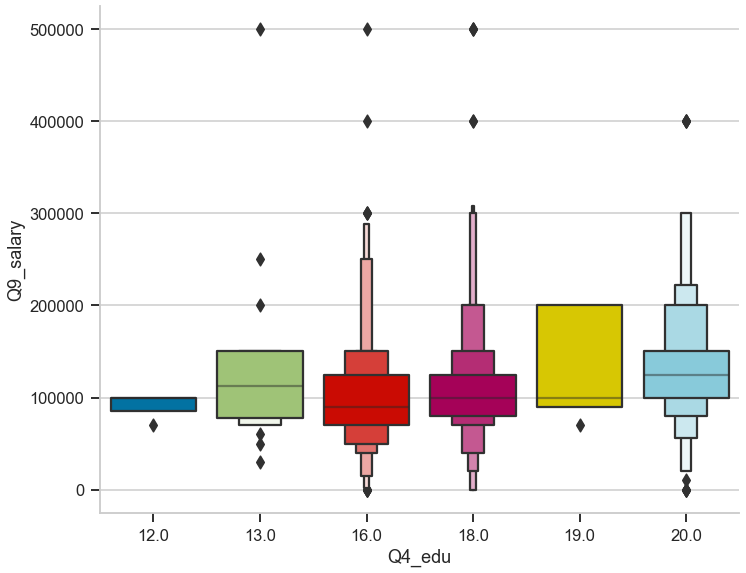

In [49]:
# In the US?
with sns.plotting_context('talk'):
    sns.catplot(y='Q9_salary', x='Q4_edu', 
            data=X_bin[X_bin['Q3_United States of America'] == 1],
            kind='boxen', height=8, aspect=1.3, **sns_kwargs)

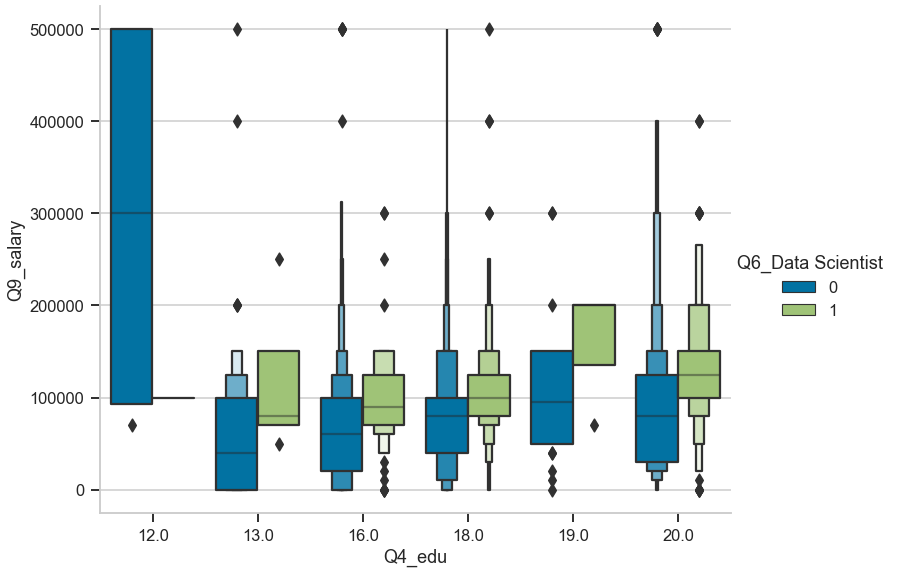

In [50]:
# DS vs SE in US (need to use kag)
with sns.plotting_context('talk'):
    sns.catplot(y='Q9_salary', x='Q4_edu', 
            data=kag[kag['Q3_United States of America'] == 1],
            hue='Q6_Data Scientist',
            kind='boxen', height=8, aspect=1.3, **sns_kwargs)

In [ ]:
# baseline model
from sklearn.dummy import DummyClassifier
dc = DummyClassifier()
dc.fit(X_bin_train.fillna(0), y_bin_train)
dc.score(X_bin_test.fillna(0), y_bin_test)

In [ ]:
with sns.plotting_context('paper'):
    fig, ax = plt.subplots(figsize=(2, 2), dpi=150)
    cm_viz = classifier.ConfusionMatrix(dc, percent=True)
    cm_viz.fit(X_bin_train.fillna(0), y_bin_train)
    cm_viz.score(X_bin_test.fillna(0), y_bin_test)
    cm_viz.poof()

In [ ]:
# classification with Decision Tree
dtc = tree.DecisionTreeClassifier(max_depth=8)
dtc.fit(X_bin_train.fillna(0), y_bin_train)
dtc.score(X_bin_test.fillna(0), y_bin_test)

In [ ]:
with sns.plotting_context('paper'):
    fig, ax = plt.subplots(figsize=(2, 2), dpi=150)
    cm_viz = classifier.ConfusionMatrix(dtc, percent=True)
    cm_viz.fit(X_bin_train.fillna(0), y_bin_train)
    cm_viz.score(X_bin_test.fillna(0), y_bin_test)
    cm_viz.poof()

In [ ]:
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(10,6), dpi=300)
    cr_viz = classifier.ClassificationReport(dtc, cmap=None)
    cr_viz.fit(X_bin_train.fillna(0), y_bin_train)
    cr_viz.score(X_bin_test.fillna(0), y_bin_test)
    cr_viz.poof()

In [ ]:
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
    fi_viz = features.FeatureImportances(dtc)
    fi_viz.fit(X_bin_train.fillna(0), y_bin_train)
    fi_viz.score(X_bin_test.fillna(0), y_bin_test)
    fi_viz.poof()

In [ ]:
dot_data = io.StringIO()
tree.export_graphviz(dtc, out_file=dot_data, feature_names=X_bin.columns, filled=True)
g = pydotplus.graph_from_dot_data(dot_data.getvalue())

In [ ]:
Image(g.create_png())

## Gradient Boosting	Ensemble of Trees, Later Trees make up for Error
	Regularization
	Parallel Processing
	Missing Number Support

In [ ]:
# XGBoost supports missing values!
X_bin.isna().mean()*100

In [ ]:
# default behavior uses all CPU's and we have missing numbers!
# Decision tree got .725813
xgb = xgboost.XGBClassifier(random_state=42)
xgb.fit(X_bin_train, y_bin_train)
xgb.score(X_bin_test, y_bin_test)

In [ ]:
xgb

In [ ]:
print(xgb.get_booster().get_dump()[0])

In [ ]:
import re

def plot_xgb(xgb, title='', size='8,5', num_trees=0):
    g2 = xgboost.to_graphviz(xgb, label=title, labelloc='top', 
            fontname='Gotham', fontsize='16', no_color="#a62e5c", 
            yes_color="#9bc850", size=size, num_trees=num_trees)
    reg = r'([0-9]+([.]([0-9]*)?))'
    for i, line in enumerate(g2.body):
        match = re.search(reg, line)
        if match:
            orig = match.group(1)
            val = '{:.5}'.format(orig)
            g2.body[i] = line.replace(orig, val)
    g2.node_attr={'fontname': 'Gotham'}
    g2.edge_attr={'fontname': 'Gotham'}
    return g2

In [ ]:
# 100 estimators (For multiclass n_classes * estimators trees)
# Score in leaf can be converted to probability
# 1/(1+np.exp(leaf))
plot_xgb(xgb, num_trees=0)

In [ ]:
# Predict position 6
xgb.predict_proba(X_bin_test.iloc[[6]])

In [ ]:
xgb.predict(X_bin_test.iloc[[6]])

In [ ]:
plot_xgb(xgb, num_trees=0)

In [ ]:
# tree 0 - value is -0.067  tree 1 = 0.008  tree 2 = -0.003   t3 = -0.002  t4 = -0.053
X_bin_test.iloc[6], y_bin_test.iloc[6]

In [ ]:
def to_prob(val):
    return 1 / (1+np.exp(val))

tot = -0.067 + .008  - .003 - .002 - 0.053

print(f'Scores: {tot:.3} Prob: {to_prob(tot):.3}')

In [ ]:
xgb.classes_

In [ ]:
x = np.linspace(-10, 10)
plt.plot(x, to_prob(x))
plt.title('Log')

In [ ]:
# overfitting?
xgb.score(X_bin_train, y_bin_train)

In [ ]:
# overfitting?
xgb.score(X_bin_test, y_bin_test)

In [ ]:
# classification with Decision Tree with no depth limit
dtc = tree.DecisionTreeClassifier()
dtc.fit(X_bin_train.fillna(0), y_bin_train)
dtc.score(X_bin_test.fillna(0), y_bin_test)

In [ ]:
# overfitting?
dtc.score(X_bin_train.fillna(0), y_bin_train)

In [ ]:
# evaluation with test set
with sns.plotting_context('paper'):
    fig, ax = plt.subplots(figsize=(2,2), dpi=150)
    cm_viz = classifier.ConfusionMatrix(xgb, percent=True)
    cm_viz.score(X_bin_test, y_bin_test)
    cm_viz.poof()

### Regularization

There is a *regularized* objective function in XGBoost. This function measures the difference between $y$ and $\hat{y}$. 

The $\lambda$ term (``lambda`` or ``reg_lambda``) performs L2 regularization and  penalizes the complexity of the model. This helps to avoid *overfitting*. If the parameter is set to 0, it does normal gradient boosting.

The $\alpha$ term (``alpha`` or ``reg_alpha``) performs L1 regularization. If it is set to 0, it does normal boosting, increasing it penalizes complex models.

In addition, there is *shrinkage*. After each boost step the newly added weights are scaled by a factor, $\eta$ (``eta`` or ``learning_rate``). This makes it more conservative (ie prevent overfitting).

The is also *column subsampling*. This allows each tree to consider different columns, thus further regularizing the model. This is contrilled by ``colsample_by*`` parameters. They have a default value of 1 (use 100% of the columns) and thus use all columns by default.

In [ ]:
# This curve gives us accuracy by default
# lambda - L2 - small weights
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(10,6), dpi=300)
    vc_viz = ms.ValidationCurve(xgboost.XGBClassifier(), 
        n_jobs=-1, ax=ax, param_name='lambda', 
        param_range=np.linspace(0, 1, 10))
    vc_viz.fit(X_bin, y_bin)
    vc_viz.poof()

In [ ]:
# alpha - L1 - sparsity
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(10,6), dpi=300)
    vc_viz = ms.ValidationCurve(xgboost.XGBClassifier(), 
        n_jobs=-1, ax=ax, param_name='alpha', 
        param_range=np.linspace(0, 1, 10))
    vc_viz.fit(X_bin, y_bin)
    vc_viz.poof()

In [ ]:
# learning rate - shrink boosting weights
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(10,6), dpi=300)
    vc_viz = ms.ValidationCurve(xgboost.XGBClassifier(random_state=42),  
        n_jobs=-1, ax=ax, param_name='learning_rate', 
        param_range=np.linspace(0, 1, 10))
    vc_viz.fit(X_bin, y_bin)
    vc_viz.poof()

In [ ]:
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(10,6), dpi=300)
    vc_viz = ms.ValidationCurve(xgboost.XGBClassifier(random_state=42), 
        n_jobs=-1, ax=ax, param_name='learning_rate', 
        param_range=np.linspace(0, .5, 10))
    vc_viz.fit(X_bin, y_bin)
    vc_viz.poof()

In [ ]:
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(10,6), dpi=300)
    vc_viz = ms.ValidationCurve(xgboost.XGBClassifier(random_state=42),  
        n_jobs=-1, ax=ax, param_name='learning_rate', 
        param_range=np.linspace(.1, .5, 10))
    vc_viz.fit(X_bin, y_bin)
    vc_viz.poof()

In [ ]:
# try precision
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(10,6), dpi=300)
    vc_viz = ms.ValidationCurve(xgboost.XGBClassifier(random_state=42),  
        n_jobs=-1, ax=ax, param_name='learning_rate', 
        scoring='precision',
        param_range=np.linspace(.1, .5, 10))
    vc_viz.fit(X_bin, y_bin)
    vc_viz.poof()

In [ ]:
# try precision
enc = preprocessing.LabelEncoder().fit(y_bin)
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(10,6), dpi=300)
    vc_viz = ms.ValidationCurve(xgboost.XGBClassifier(random_state=42),  
        n_jobs=-1, ax=ax, param_name='learning_rate', 
        scoring='precision',
        param_range=np.linspace(.1, .5, 10))
    vc_viz.fit(X_bin, enc.transform(y_bin))
    vc_viz.poof()

In [ ]:

enc = preprocessing.LabelEncoder().fit(y_bin)
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(10,6), dpi=300)
    vc_viz = ms.ValidationCurve(xgboost.XGBClassifier(random_state=42), 
        n_jobs=-1, ax=ax, param_name='learning_rate', 
        scoring='recall',
        param_range=np.linspace(.1, .5, 10))
    vc_viz.fit(X_bin, enc.transform(y_bin))
    vc_viz.poof()

In [ ]:
# look at the numbers
vc_viz.test_scores_mean_

In [ ]:
# look at the numbers
vc_viz.test_scores_mean_.argmax()

In [ ]:
vc_viz.param_range[vc_viz.test_scores_mean_.argmax()]

In [ ]:
# n_estimators - the number of boosting rounds (or trees)
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(10,6), dpi=300)
    vc_viz = ms.ValidationCurve(xgboost.XGBClassifier(), 
        n_jobs=-1, ax=ax, param_name='n_estimators', 
        param_range=range(50, 501, 50))
    vc_viz.fit(X_bin, y_bin)
    vc_viz.poof()

In [ ]:
xgb2 = xgboost.XGBClassifier(random_state=42, n_estimators=1000)
xgb2.fit(X_bin_train, y_bin_train, early_stopping_rounds=50,
        eval_set=[(X_bin_test, y_bin_test)])

In [ ]:
xgb2.best_iteration, xgb2.best_score

In [ ]:
# max_depth - how deep the trees are
# deeper trees allow for more interactions (and complexity)
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(10,6), dpi=300)
    vc_viz = ms.ValidationCurve(xgboost.XGBClassifier(), ax=ax, 
                n_jobs=-1, param_name='max_depth', 
                param_range=range(1, 10))
    vc_viz.fit(X_bin, y_bin)
    vc_viz.poof()

In [ ]:
stumps = xgboost.XGBClassifier(max_depth=1, random_state=42)
stumps.fit(X_bin_train, y_bin_train)
stumps.score(X_bin_test, y_bin_test)

In [ ]:
plot_xgb(stumps, num_trees=0)

In [ ]:
plot_xgb(stumps, num_trees=99)

In [ ]:
# gamma - Controls pruning. Range is [0, infinity]
# Minimum loss reduction required for spliting a leaf
# Higher the value, the higher the regularization (typically correlates w/ max_depth)
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(10,6), dpi=300)
    vc_viz = ms.ValidationCurve(xgboost.XGBClassifier(), 
                n_jobs=-1, ax=ax, 
                param_name='gamma', param_range=[0, .5, 1, 5, 20])
    vc_viz.fit(X_bin, y_bin)
    vc_viz.poof()

In [ ]:
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(10,6), dpi=300)
    vc_viz = ms.ValidationCurve(xgboost.XGBClassifier(), 
                n_jobs=-1, ax=ax, 
                param_name='gamma', param_range=np.linspace(0, 5, 10))
    vc_viz.fit(X_bin, y_bin)
    vc_viz.poof()

In [ ]:
# Column sampling - percent of columns to use in...
# - colsample_bytree - for boosting round
# - colsample_bylevel - for tree level
# - colsample_bynode - for node
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(10,6), dpi=300)
    vc_viz = ms.ValidationCurve(xgboost.XGBClassifier(random_state=42), ax=ax, 
                                n_jobs=-1,
                                param_name='colsample_bytree',
                                param_range=[.1, .3, .5, .7, .9, 1])
    vc_viz.fit(X_bin, y_bin)
    vc_viz.poof()

In [ ]:
# Column sampling - percent of columns to use in...
# - colsample_bytree - for boosting round
# - colsample_bylevel - for tree level
# - colsample_bynode - for node
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(10,6), dpi=300)
    vc_viz = ms.ValidationCurve(xgboost.XGBClassifier(), ax=ax, 
                                n_jobs=-1,
                                param_name='colsample_bylevel',
                                param_range=[0, .3, .5, .7, .9, 1])
    vc_viz.fit(X_bin, y_bin)
    vc_viz.poof()

In [ ]:
# Column sampling - percent of columns to use in...
# - colsample_bytree - for boosting round
# - colsample_bylevel - for tree level
# - colsample_bynode - for node
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(10,6), dpi=300)
    vc_viz = ms.ValidationCurve(xgboost.XGBClassifier(), ax=ax, 
                                n_jobs=-1,
                                param_name='colsample_bynode',
                                param_range=[0, .3, .5, .7, .9, 1])
    vc_viz.fit(X_bin, y_bin)
    vc_viz.poof()

In [ ]:
# subsample - percent of samples (not features) to use for each round
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(10,6), dpi=300)
    vc_viz = ms.ValidationCurve(xgboost.XGBClassifier(random_state=42), ax=ax, 
                                n_jobs=-1,
                                param_name='subsample',
                                param_range=[0.1, .3, .5, .7, .9, 1])
    vc_viz.fit(X_bin, y_bin)
    vc_viz.poof()

In [ ]:
%%time
# if learning rate (default .1) goes down, may need more boosting rounds to fit
# note n_estimators is dependent on other params and should be tuned after or use early_stopping_rounds on .fit
params = {'reg_lambda': [0],  # No effect
          'learning_rate': [.1, .3], # makes each boost more conservative (0 - no shrinkage) 
          'colsample_bylevel': [.3, 1], # use 0, 50%, or 100% of columns in boost step
          'subsample': [.7, 1],
          'gamma': [0, 1],
          'max_depth': [2, 3],
          'random_state': [42],
          'n_jobs': [-1],
          'early_stopping_rounds':[10],
          'n_estimators': [200]}
xgb2 = xgboost.XGBClassifier()
cv = model_selection.GridSearchCV(xgb2,
      params, n_jobs=-1).fit(X_bin, y_bin, eval_set=[(X_bin_test, y_bin_test)] ) 

In [ ]:
cv.best_params_

In [ ]:
# default vs grid
xgb_def = xgboost.XGBClassifier()
xgb_def.fit(X_bin_train, y_bin_train)
xgb_grid = xgboost.XGBClassifier(**cv.best_params_)
xgb_grid.fit(X_bin_train, y_bin_train)
xgb_def.score(X_bin_test, y_bin_test), xgb_grid.score(X_bin_test, y_bin_test)

## XGBoost Classification Evaluation	ROC
  Accuracy
	AUC
	Confusion Matrix
	PR Curve

### Accuracy

In [ ]:
xgb = xgboost.XGBClassifier()
xgb.fit(X_bin_train, y_bin_train)
params = {'colsample_bylevel': 0.3,
 'early_stopping_rounds': 10,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_depth': 2,
 'n_estimators': 200,
 'n_jobs': -1,
 'random_state': 42,
 'reg_lambda': 0,
 'subsample': 0.7}
xgb_grid = xgboost.XGBClassifier(**params)
xgb_grid.fit(X_bin_train, y_bin_train)
xgb.score(X_bin_test, y_bin_test), xgb_grid.score(X_bin_test, y_bin_test)

In [ ]:
metrics.accuracy_score(y_bin_test, xgb_grid.predict(X_bin_test))

### AUC

In [ ]:
xgb_grid.predict(X_bin_test)

In [ ]:
metrics.roc_auc_score(y_bin_test, xgb_grid.predict(X_bin_test))

In [ ]:
enc = preprocessing.LabelEncoder().fit(y_bin_test)
metrics.roc_auc_score(enc.transform(y_bin_test),
                      enc.transform(xgb_grid.predict(X_bin_test)))

In [ ]:
dtc = tree.DecisionTreeClassifier(max_depth=8)
dtc.fit(X_bin_train.fillna(0), y_bin_train)

with sns.plotting_context('notebook'):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6), dpi=300)
    roc_viz = classifier.ROCAUC(xgb_grid, ax=ax1, micro=False)
    roc_viz.score(X_bin_test, y_bin_test)
    roc_viz.finalize()
    roc_viz2 = classifier.ROCAUC(dtc, ax=ax2, micro=False)
    roc_viz2.score(X_bin_test.fillna(0), y_bin_test)
    roc_viz2.finalize()

### Confusion Matrix

In [ ]:
with sns.plotting_context('paper'):
    fig, ax = plt.subplots(figsize=(2,2), dpi=150)
    cm_viz = classifier.ConfusionMatrix(xgb_grid, percent=True)
    cm_viz.score(X_bin_test, y_bin_test)
    cm_viz.poof()

### Class Prediction Error

In [ ]:
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(12,6), dpi=300)
    cm_viz = classifier.ClassPredictionError(xgb_grid, ax=ax)
    cm_viz.score(X_bin_test, y_bin_test)
    cm_viz.poof()

### Classification Report
* Precision - What is the cost for a false positive?
* Recall - What is the cost for false negative (failing to predict positive)?

In [ ]:
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(10,6), dpi=300)
    cm_viz = classifier.ClassificationReport(xgb_grid, ax=ax)
    cm_viz.score(X_bin_test, y_bin_test)
    cm_viz.poof()

### Sklearn Metrics

In [ ]:
enc = preprocessing.LabelEncoder().fit(y_bin_test)
metrics.precision_score(enc.transform(y_bin_test),
                      enc.transform(xgb_grid.predict(X_bin_test)))

In [ ]:
enc = preprocessing.LabelEncoder().fit(y_bin_test)
metrics.r2_scoref1_score(enc.transform(y_bin_test),
                      enc.transform(xgb_grid.predict(X_bin_test)))

### PR Curve

In [ ]:
enc = preprocessing.LabelEncoder().fit(y_bin_test)

# need to encode target! (yellowbrick/sklearn issue)
with sns.plotting_context('notebook'):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6), dpi=300)
    roc_viz = classifier.PRCurve(xgboost.XGBClassifier(**params), ax=ax1)
    roc_viz.fit(X_bin_train, enc.transform(y_bin_train))
    roc_viz.score(X_bin_test, enc.transform(y_bin_test))
    roc_viz.finalize()
    roc_viz2 = classifier.PRCurve(tree.DecisionTreeClassifier(), ax=ax2)
    roc_viz2.fit(X_bin_train.fillna(0), enc.transform(y_bin_train))
    roc_viz2.score(X_bin_test.fillna(0), enc.transform(y_bin_test))
    roc_viz2.finalize()

## Learning Curve: Do we have enough data? 

In [ ]:
params = {'colsample_bylevel': 0.3,
 'early_stopping_rounds': 10,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_depth': 2,
 'n_estimators': 200,
 'n_jobs': -1,
 'random_state': 42,
 'reg_lambda': 0,
 'subsample': 0.7}

with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(10,6), dpi=300)
    lc_viz = ms.LearningCurve(xgboost.XGBClassifier(
        **params),train_sizes=[0.01  , 0.325, 0.55 , 0.775, 1.   ],)
    lc_viz.fit(X_bin, y_bin)
    lc_viz.poof()

In [ ]:
# Underfit - Stagnant CV
from sklearn import dummy
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(10,6), dpi=300)
    lc_viz = ms.LearningCurve(dummy.DummyClassifier(),
         train_sizes=[0.01  , 0.325, 0.55 , 0.775, 1.   ],)
    lc_viz.fit(X_bin, y_bin)
    lc_viz.poof()

In [ ]:
# Overfit - High training, big gap
from sklearn import dummy
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(10,6), dpi=300)
    lc_viz = ms.LearningCurve(tree.DecisionTreeClassifier(),
         train_sizes=[0.01  , 0.325, 0.55 , 0.775, 1.   ],)
    lc_viz.fit(X_bin.fillna(0), y_bin)
    lc_viz.poof()

## Interpreting Results	Predicting Results
	Feature Importance
	LIME for individual interpretation
	Tree visualization

In [ ]:
params  = {'colsample_bylevel': 0.3,
 'early_stopping_rounds': 10,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_depth': 2,
 'n_estimators': 200,
 'n_jobs': -1,
 'random_state': 42,
 'reg_lambda': 0,
 'subsample': 0.7}
xgb_grid = xgboost.XGBClassifier()
xgb_grid.fit(X_bin_train, y_bin_train, early_stopping_rounds=70, eval_set=[(X_bin_test, y_bin_test)])

In [ ]:
# importance_type - weight - # times a feature appears in a tree
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(10,6), dpi=300)
    xgboost.plot_importance(xgb_grid, ax=ax, importance_type='weight')

In [ ]:
# importance_type - cover - weighted # of times a feature is 
# used for a split (weighted by # samples affected)
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(10,6), dpi=300)
    xgboost.plot_importance(xgb_grid, ax=ax, importance_type='cover')

In [ ]:
# importance_type - gain - average training loss reduction when
# feature used
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(10,6), dpi=300)
    xgboost.plot_importance(xgb_grid, ax=ax, importance_type='gain')

In [ ]:
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
    fi_viz = features.FeatureImportances(xgb_grid)
    fi_viz.fit(X_bin, y_bin)
    fi_viz.poof()

In [ ]:
for col, val in sorted(zip(X_bin.columns, xgb_grid.feature_importances_),
    key=lambda x:x[1], reverse=True)[:4]:
    print(f'{col:10}{val:10.3f}')

In [ ]:
# xgbfir (Feature Interactions Reshaped)
# Gain: Total gain of each feature or feature interaction
# FScore: Amount of possible splits taken on a feature or feature interaction
# wFScore: Amount of possible splits taken on a feature or feature interaction weighted by the probability of the splits to take place
# Average wFScore: wFScore divided by FScore
# Average Gain: Gain divided by FScore
# Expected Gain: Total gain of each feature or feature interaction weighted by the probability to gather the gain
import xgbfir
xgbfir.saveXgbFI(xgb_grid, feature_names=X_bin.columns, OutputXlsxFile='/tmp/fir.xlsx')
pd.read_excel('/tmp/fir.xlsx')

In [ ]:
pd.read_excel('/tmp/fir.xlsx', sheet_name='Interaction Depth 1')

In [ ]:
pd.read_excel('/tmp/fir.xlsx', sheet_name='Interaction Depth 2')

In [ ]:
# Partial Dependence Plots - Uses Monte Carlo method for marginal effect of feature on outcome
# See if relationship is linear, monotonic, or more complex
# Assumes independence
# https://github.com/SauceCat/PDPbox/issues/51 - No support for NA!
from pdpbox import pdp
feature = 'Q8_exp'
pdep = pdp.pdp_isolate(xgb_grid, X_bin.dropna(), X_bin.columns, feature)
fig, axes = pdp.pdp_plot(pdep, feature, plot_lines=True, plot_params={'font_family': 'Gotham'})

In [ ]:
sns_kwargs = dict(palette=color_palette, saturation=1)
with sns.plotting_context('talk'):
    sns.catplot(y='se',
                x='Q8_exp', 
                kind='boxen', height=8, aspect=1.3,
                data = X_bin.assign(se=y_bin),
                **sns_kwargs
               )

In [ ]:
feature = 'Q4_edu'
pdep = pdp.pdp_isolate(xgb_grid, X_bin.dropna(), X_bin.columns, feature, n_jobs=-1)
fig, axes = pdp.pdp_plot(pdep, feature, plot_lines=True, plot_params={'font_family': 'Gotham'})

In [ ]:
feature = 'Q9_salary'
pdep = pdp.pdp_isolate(xgb_grid, X_bin.dropna(), X_bin.columns, feature, n_jobs=-1)
fig, axes = pdp.pdp_plot(pdep, feature, plot_lines=True, plot_params={'font_family': 'Gotham'})

In [ ]:
# Partial Dependence Plots
# Q16_R only has 1 and NaN
# https://github.com/SauceCat/PDPbox/issues/51 - No support for NA!
feature = 'Q16_R'
pdep = pdp.pdp_isolate(xgb_grid, X_bin.dropna(), X_bin.columns, feature)#, n_jobs=1)
fig, axes = pdp.pdp_plot(pdep, feature, plot_lines=True, plot_params={'font_family': 'Gotham'})

In [ ]:
# requires matplotlib < 3
features = ['Q4_edu', 'Q8_exp']
pint = pdp.pdp_interact(model=xgb_grid, dataset=X_bin.dropna(), 
                        model_features=X_bin.columns, features=features, n_jobs=-1)
fig, ax_dict = pdp.pdp_interact_plot(pint, feature_names=features, plot_type='contour',
                     plot_pdp=True)

In [ ]:
# requires matplotlib < 3
features = ['Q9_salary', 'Q4_edu']
pint = pdp.pdp_interact(model=xgb_grid, dataset=X_bin.dropna(), 
                        model_features=X_bin.columns, features=features)
fig, ax_dict = pdp.pdp_interact_plot(pint, feature_names=features, plot_type='grid', 
                                     figsize=(12,8), plot_pdp=True)

In [ ]:
# Alternate scikit implementation
from sklearn.inspection import partial_dependence, plot_partial_dependence

xgb_sk = xgboost.XGBClassifier(random_state=42)
xgb_sk.fit(X_bin_train.get_values(), y_bin_train)
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
    plot_partial_dependence(xgb_sk, X_bin.fillna(0).get_values(),  
                            ['Q8_exp', 'Q4_edu', 'Q9_salary'],
                            feature_names=list(X_bin.columns),
                           fig=fig) 

In [ ]:
# note that the scale is different (pdpbox uses quantiles)
xgb_sk = xgboost.XGBClassifier(random_state=42)
xgb_sk.fit(X_bin_train.get_values(), 
           y_bin_train)

with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(8, 6), dpi=300)
    plot_partial_dependence(xgb_sk, X_bin.fillna(0).get_values(), [('Q4_edu', 'Q8_exp' )], 
                            feature_names=list(X_bin.columns),
                           fig=fig)

In [ ]:
# plot in 3D
from sklearn.inspection import partial_dependence, plot_partial_dependence
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
xgb_sk = xgboost.XGBClassifier(random_state=42)
xgb_sk.fit(X_bin_train.get_values(), 
           y_bin_train)
res, axes = partial_dependence(xgb_sk, X_bin.fillna(0), features=[5, 9])
x, y = np.meshgrid(axes[0], axes[1])
z = res[0].T
ax.plot_surface(x, y, z)
ax.set_xlabel(X_bin.columns[5])
ax.set_ylabel(X_bin.columns[9])
_ = ax.set_zlabel('Partial dependence')


### LIME

In [ ]:
# LIME - Local interpretable model-agnostic explanations
# learns a linear model around an instance (using close samples that are weighted)
# not global
#
# will get an error if you trained the model on a pandas dataframe instead of 
# an np.array (https://github.com/dmlc/xgboost/issues/2334)
params = {'colsample_bylevel': 0.3,
 'early_stopping_rounds': 10,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_depth': 2,
 'n_estimators': 200,
 'n_jobs': -1,
 'random_state': 42,
 'reg_lambda': 0,
 'subsample': 0.7}
xgb_lime = xgboost.XGBClassifier(**params)
xgb_lime.fit(X_bin.fillna(0).as_matrix(), y_bin.as_matrix())
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_bin.fillna(0).values,
    feature_names=X_bin.columns,
    class_names=['Data Scientist', 'Software Engineer']
)

pos = 0
exp = explainer.explain_instance(X_bin.fillna(0).iloc[pos].values, 
                                 xgb_lime.predict_proba)
_ = exp.show_in_notebook()

In [ ]:
pos = 8

exp = explainer.explain_instance(X_bin.fillna(0).iloc[pos].values, 
                                 xgb_lime.predict_proba)
_ = exp.show_in_notebook()


### SHAP (SHapley Additive exPlantations)
Shoule be *globally* consistent and accurate

In [72]:
# Shapley value
# From game theory, indicates how to distribute attribution of label
shap.initjs()

In [73]:
# make sure you initialize the js side
shap_ex = shap.TreeExplainer(xgb_grid)
vals = shap_ex.shap_values(X_bin)

In [74]:
X_bin.iloc[[0, 8]]

Q1_Male  Q2_age  Q3_United States of America  Q3_India  Q3_China  Q4_edu  \
3         0      30                            1         0         0    18.0   
30        0      25                            0         0         0    16.0   

    Q5_eng  Q5_other  Q5_stat  Q8_exp  Q9_salary  Q16_Py  Q16_R  Q16_SQL  
3        0         0        0     0.0        0.0     NaN    1.0      NaN  
30       0         0        0     2.0    10000.0     1.0    NaN      NaN

In [75]:
xgb_grid.predict(X_bin.iloc[[0, 8]])

array(['Data Scientist', 'Software Engineer'], dtype=object)

In [76]:
# use matplotlib if having js issues
# blue - DS
# red - SE
shap.force_plot(shap_ex.expected_value, 
               vals[0,:], X_bin.iloc[0])#, matplotlib=True,)

In [77]:
# blue - DS
# red - SE
shap.force_plot(shap_ex.expected_value, 
               vals[8,:], X_bin.iloc[8])#, matplotlib=True,)

In [78]:
# blue - DS
# red - SE
shap.initjs()
shap.force_plot(shap_ex.expected_value, vals[:100], X_bin.iloc[:100])

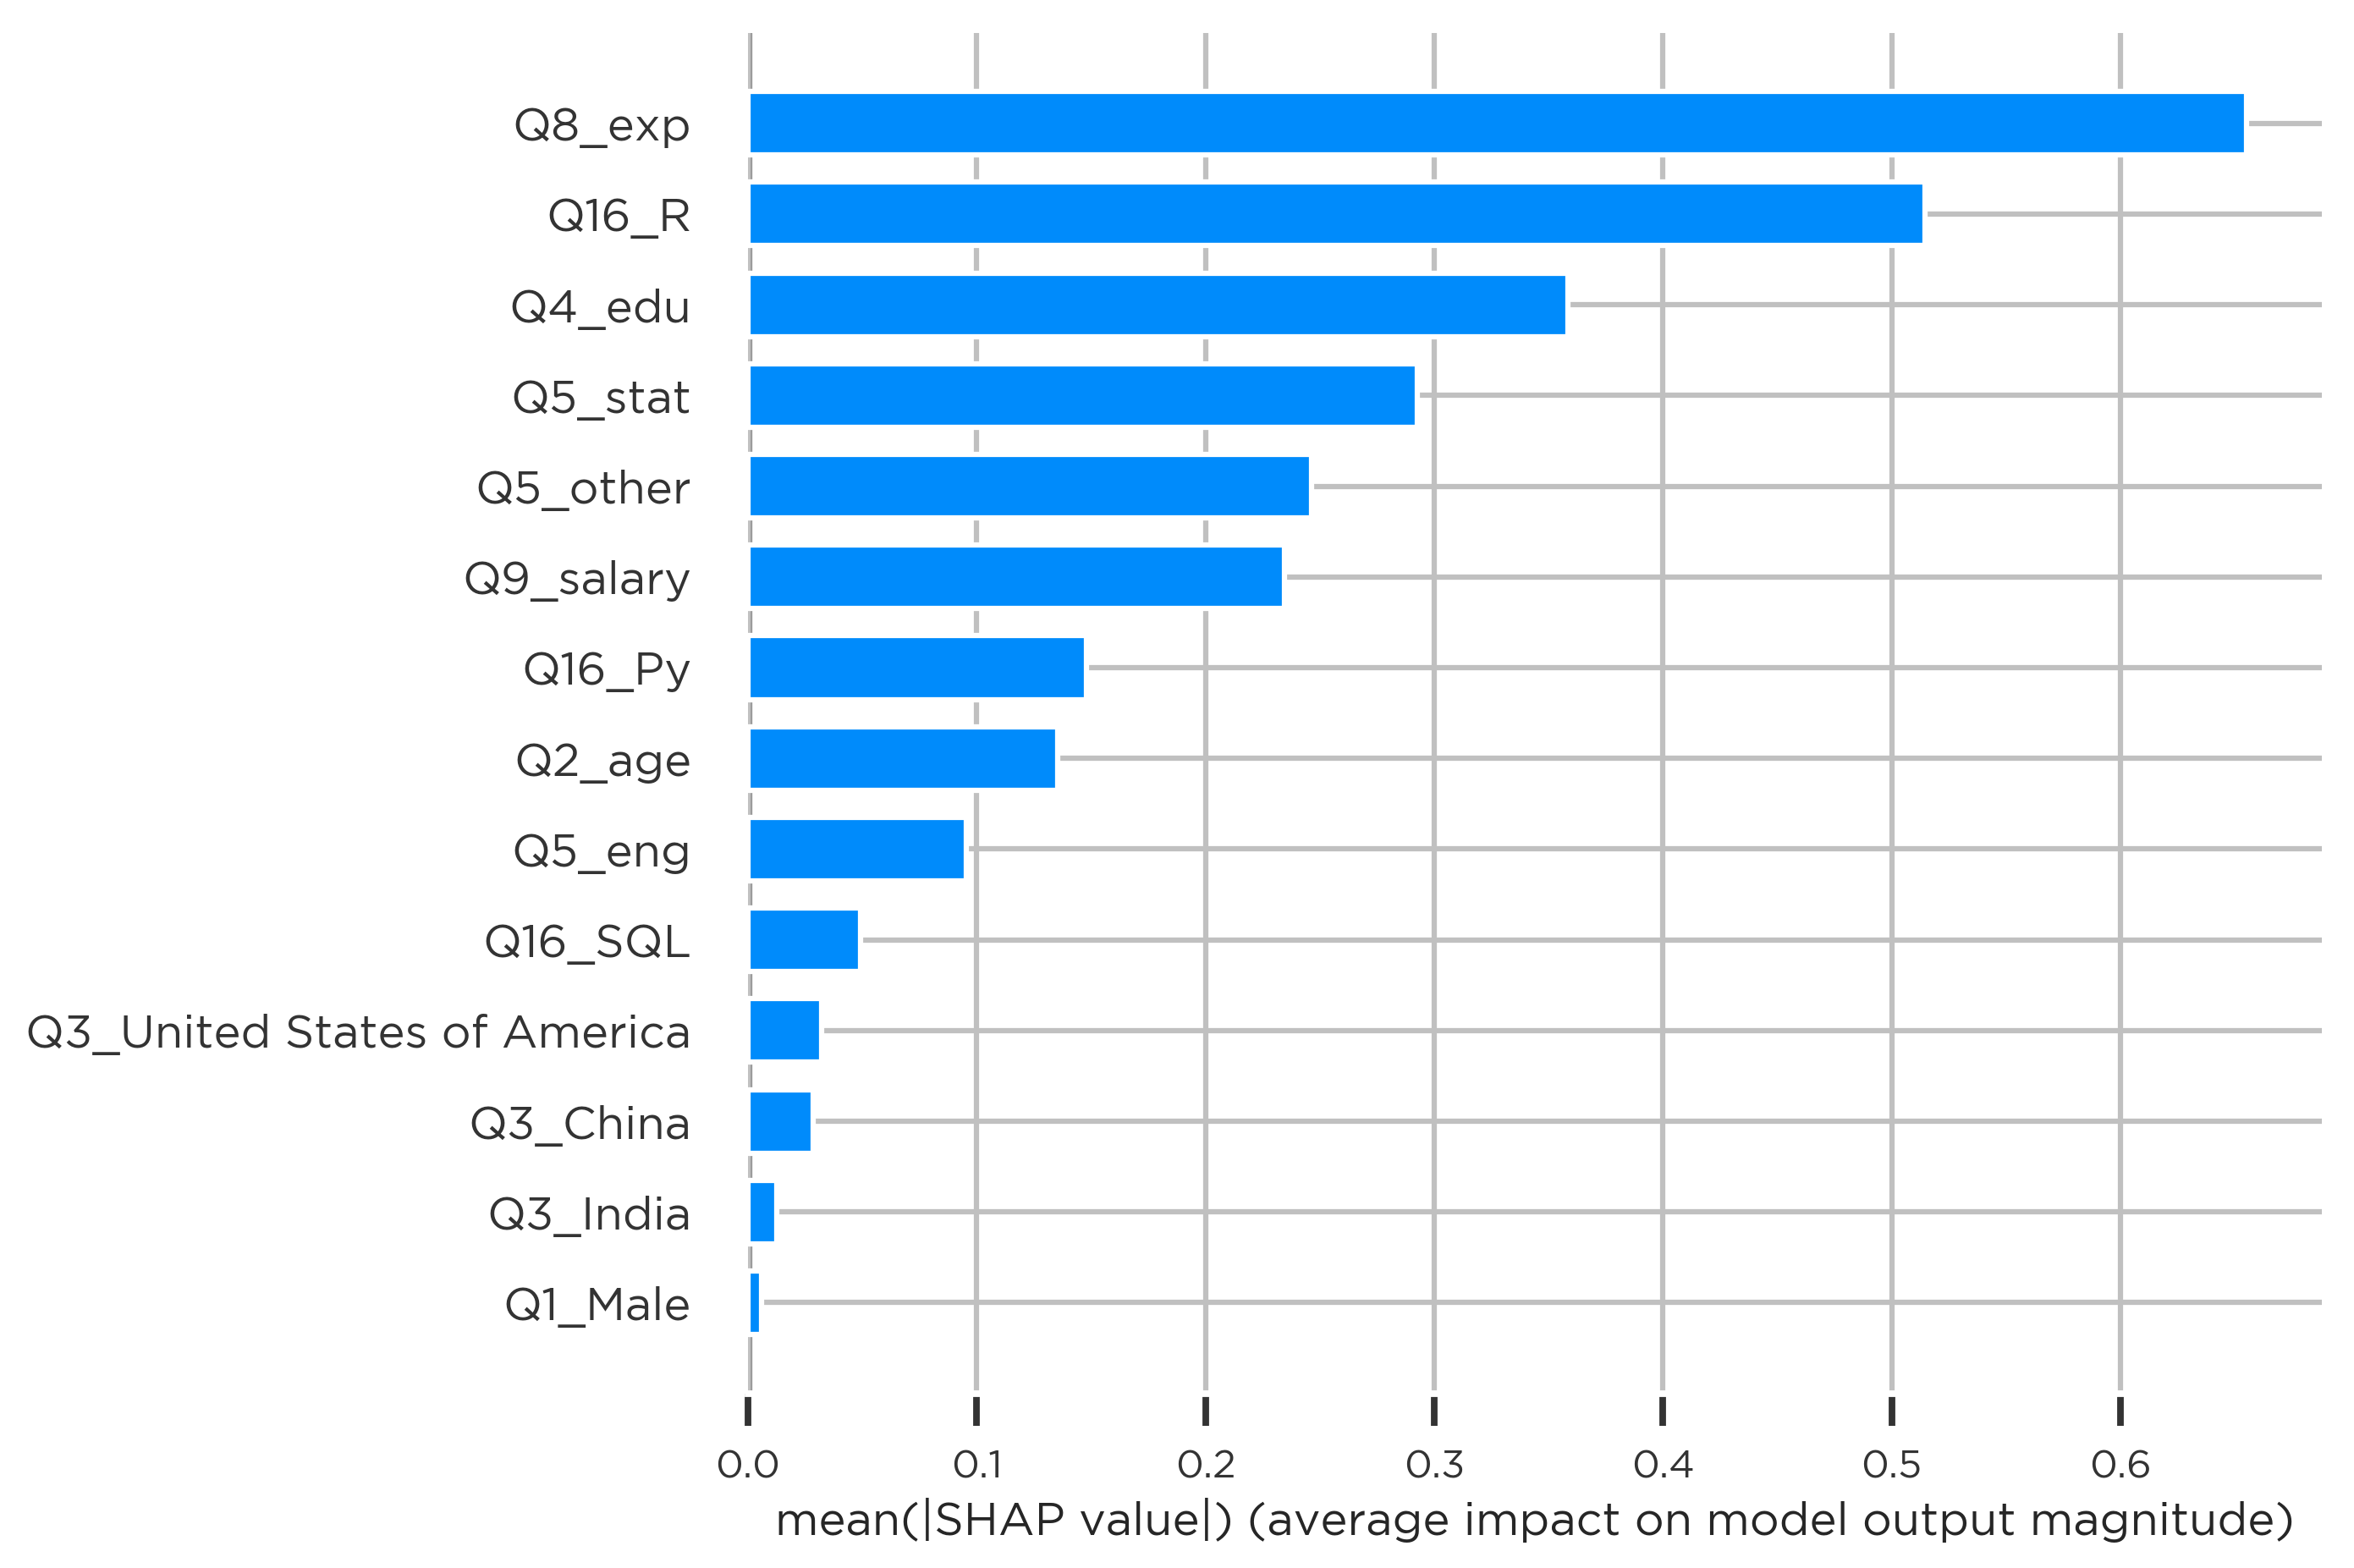

In [79]:
# Summarizes above. Wider variance in SHAP -> More important to model
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(10,6), dpi=300)
    shap.summary_plot(vals, X_bin, plot_type='bar')

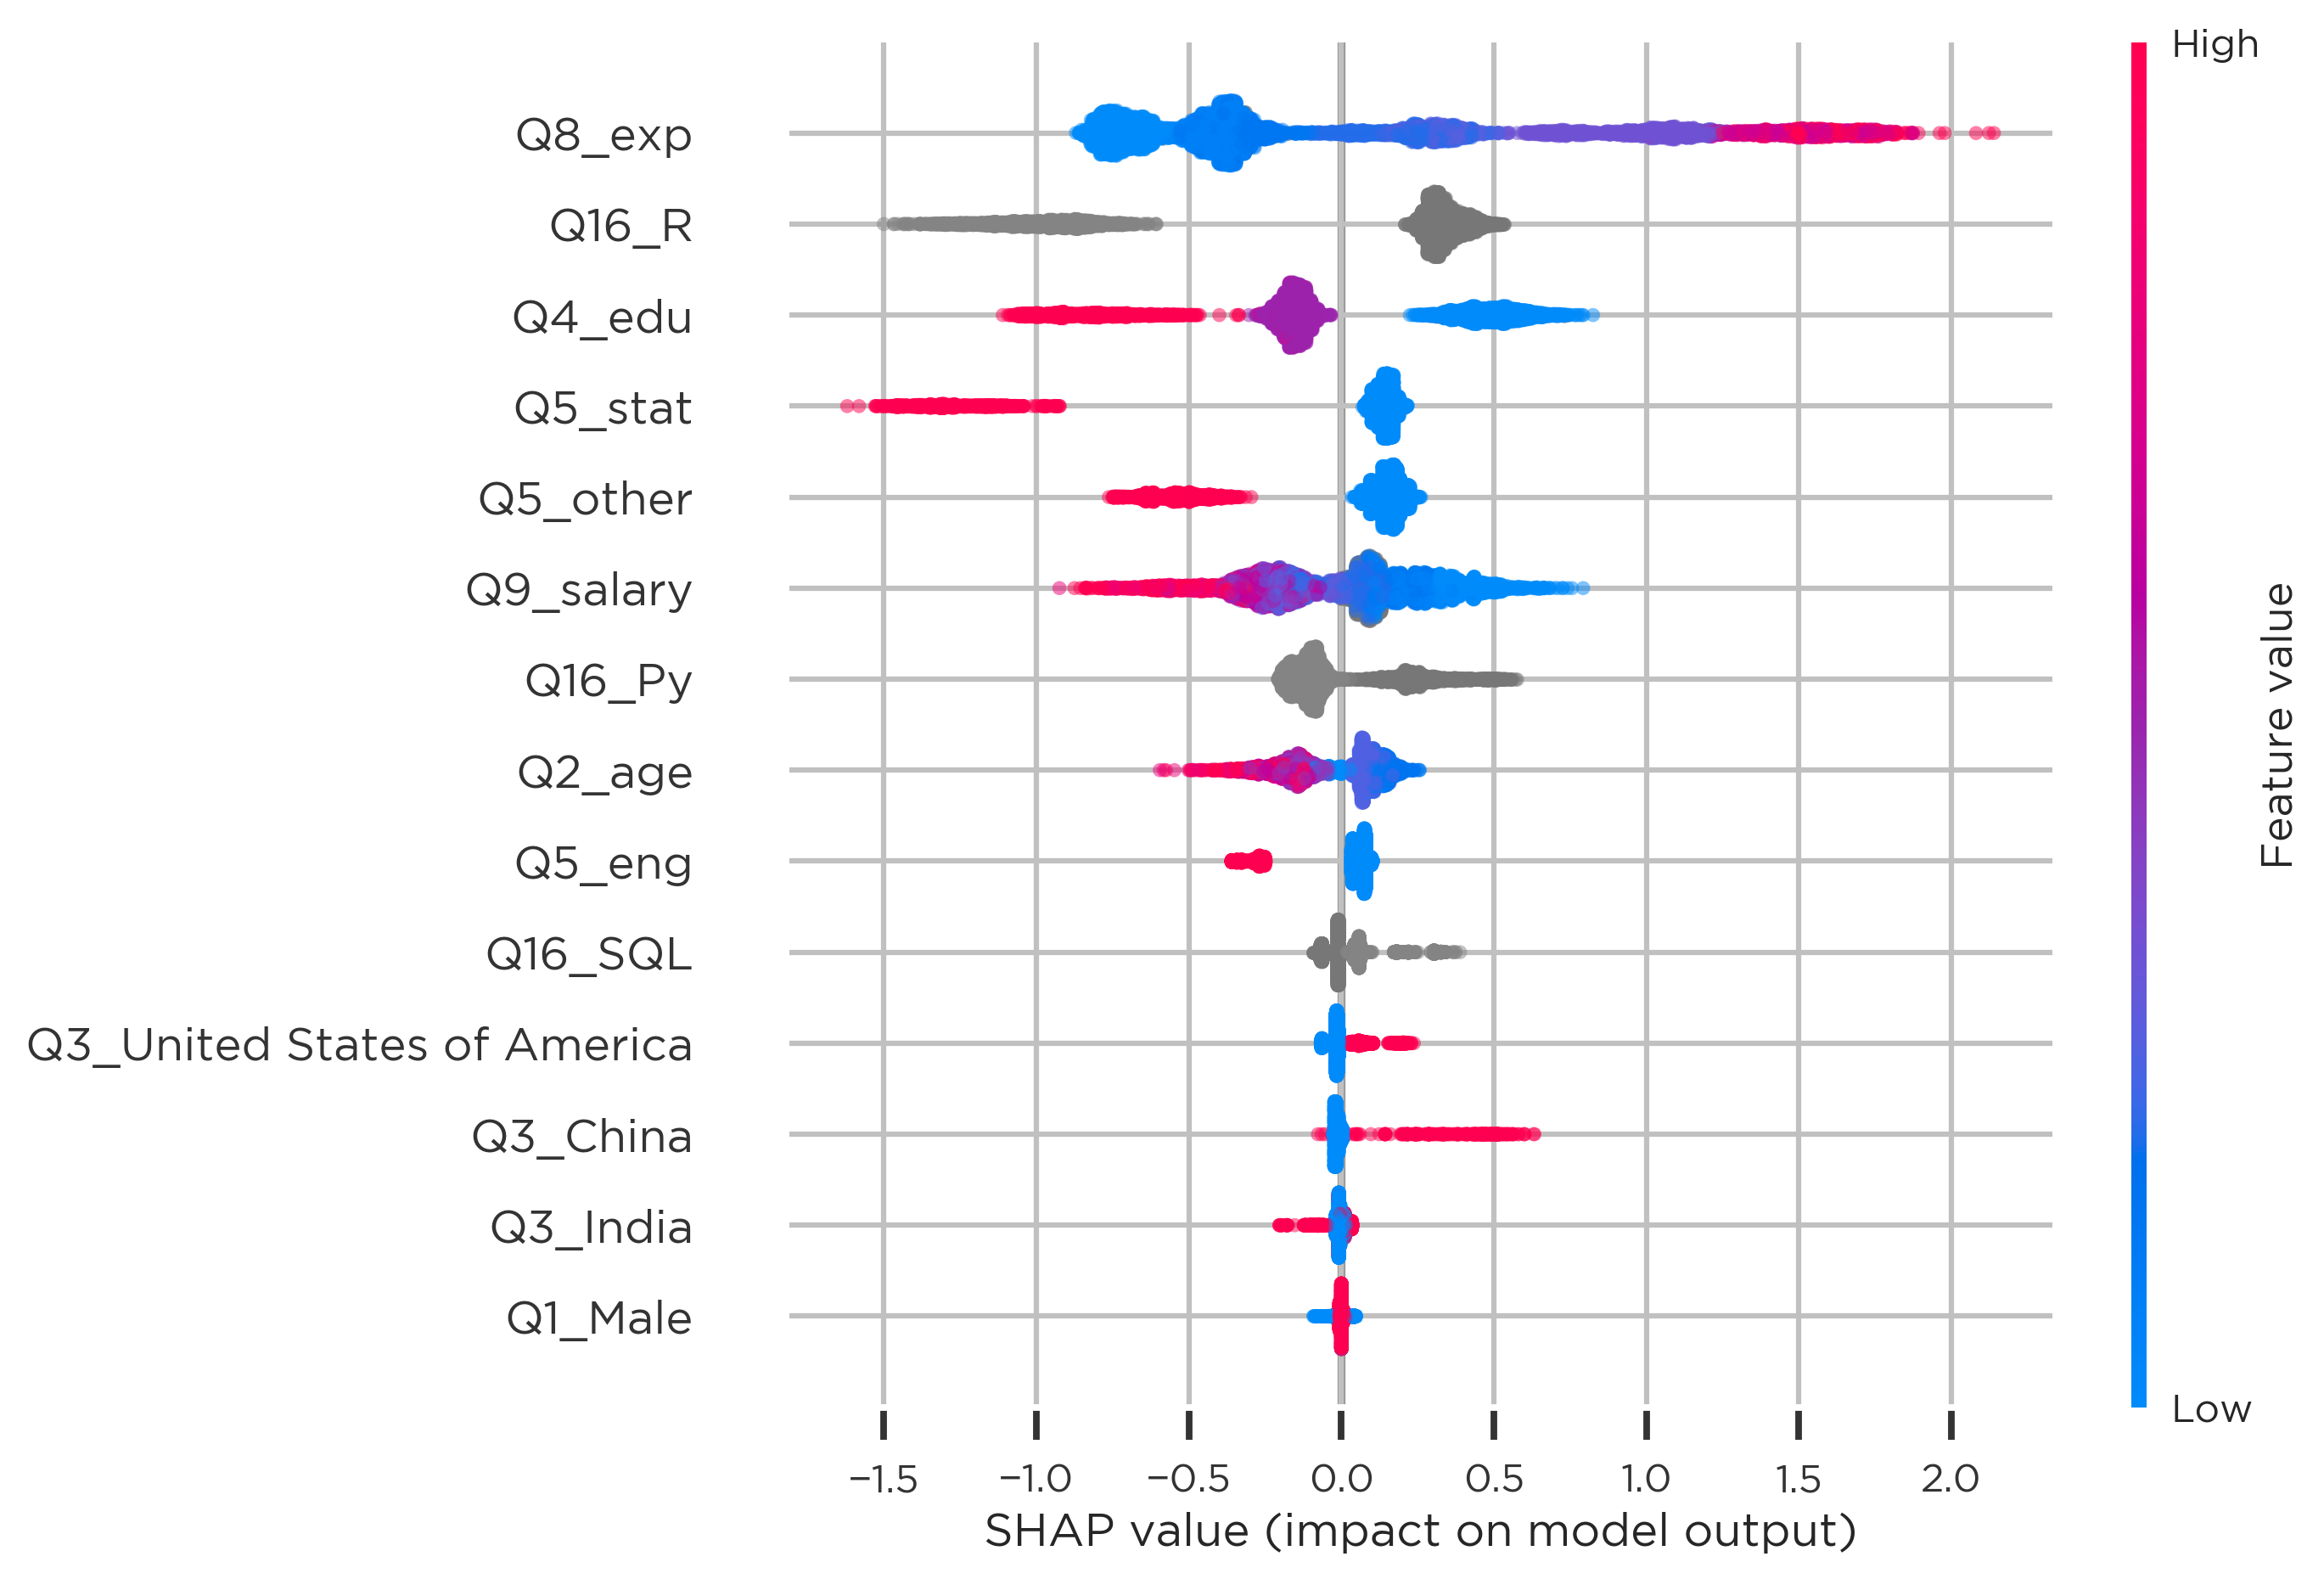

In [80]:
# In this case color is not label, but value of feature
# Higher SHAP - more SE
# High exp - raises SE
# Low R - raises DS - R only has NaN and 1, considers 1 to be "low"
# High Edu - raises DS

with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(10,6), dpi=300)
    shap.summary_plot(vals, X_bin, alpha=.5)

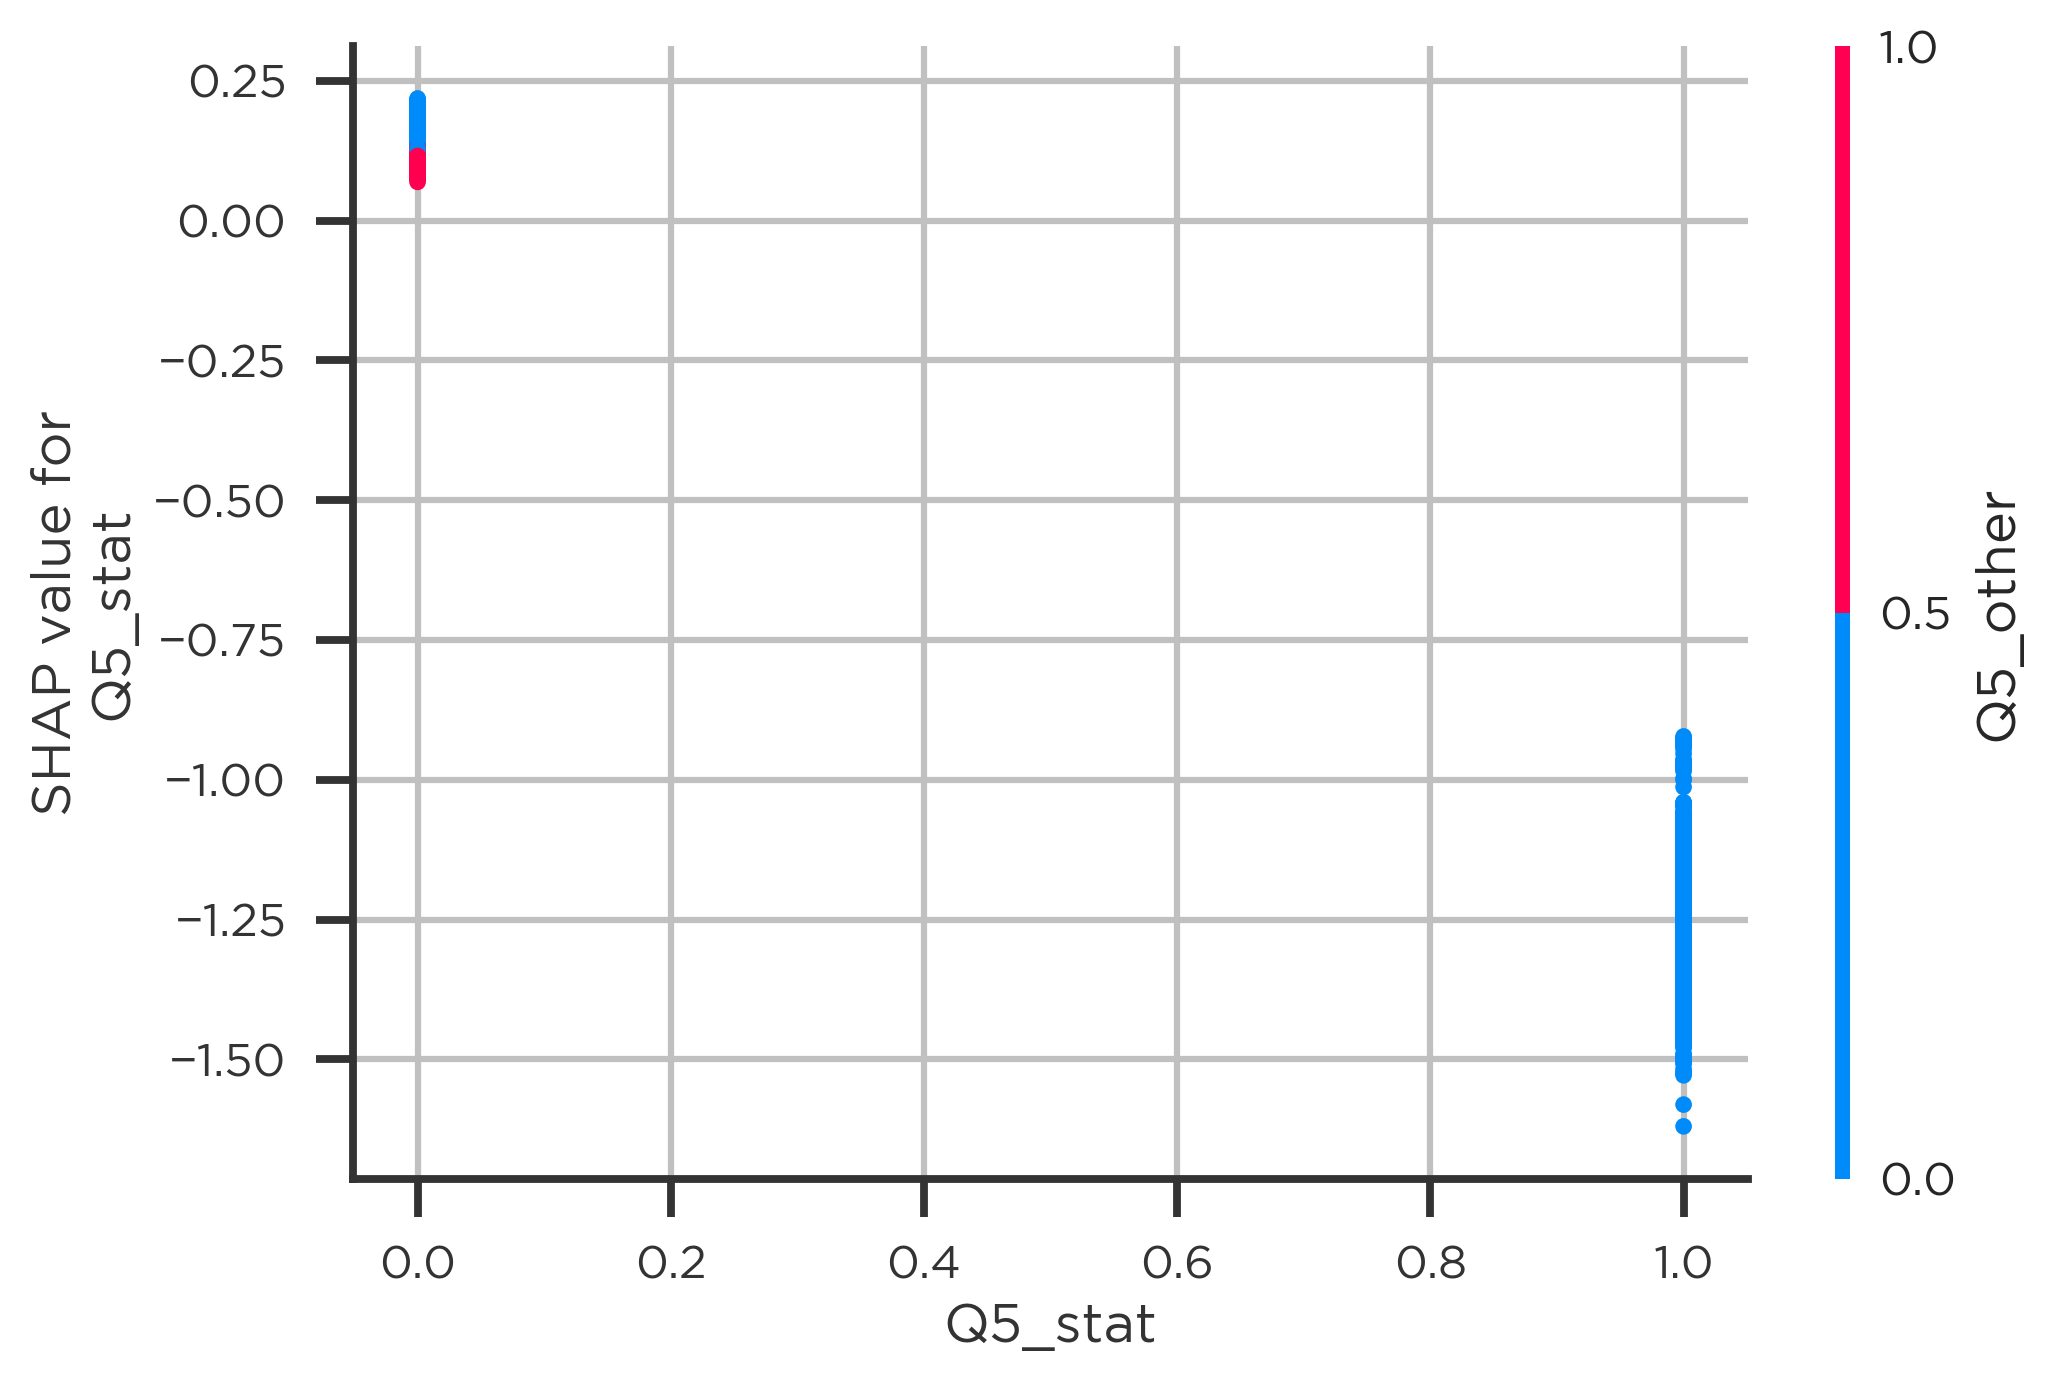

In [81]:
# Q5_stat indicates large (stats grad) tends toward DS
# automatically choses Q5_other
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(10,6), dpi=300)
    shap.dependence_plot('Q5_stat', vals, X_bin, alpha=1)

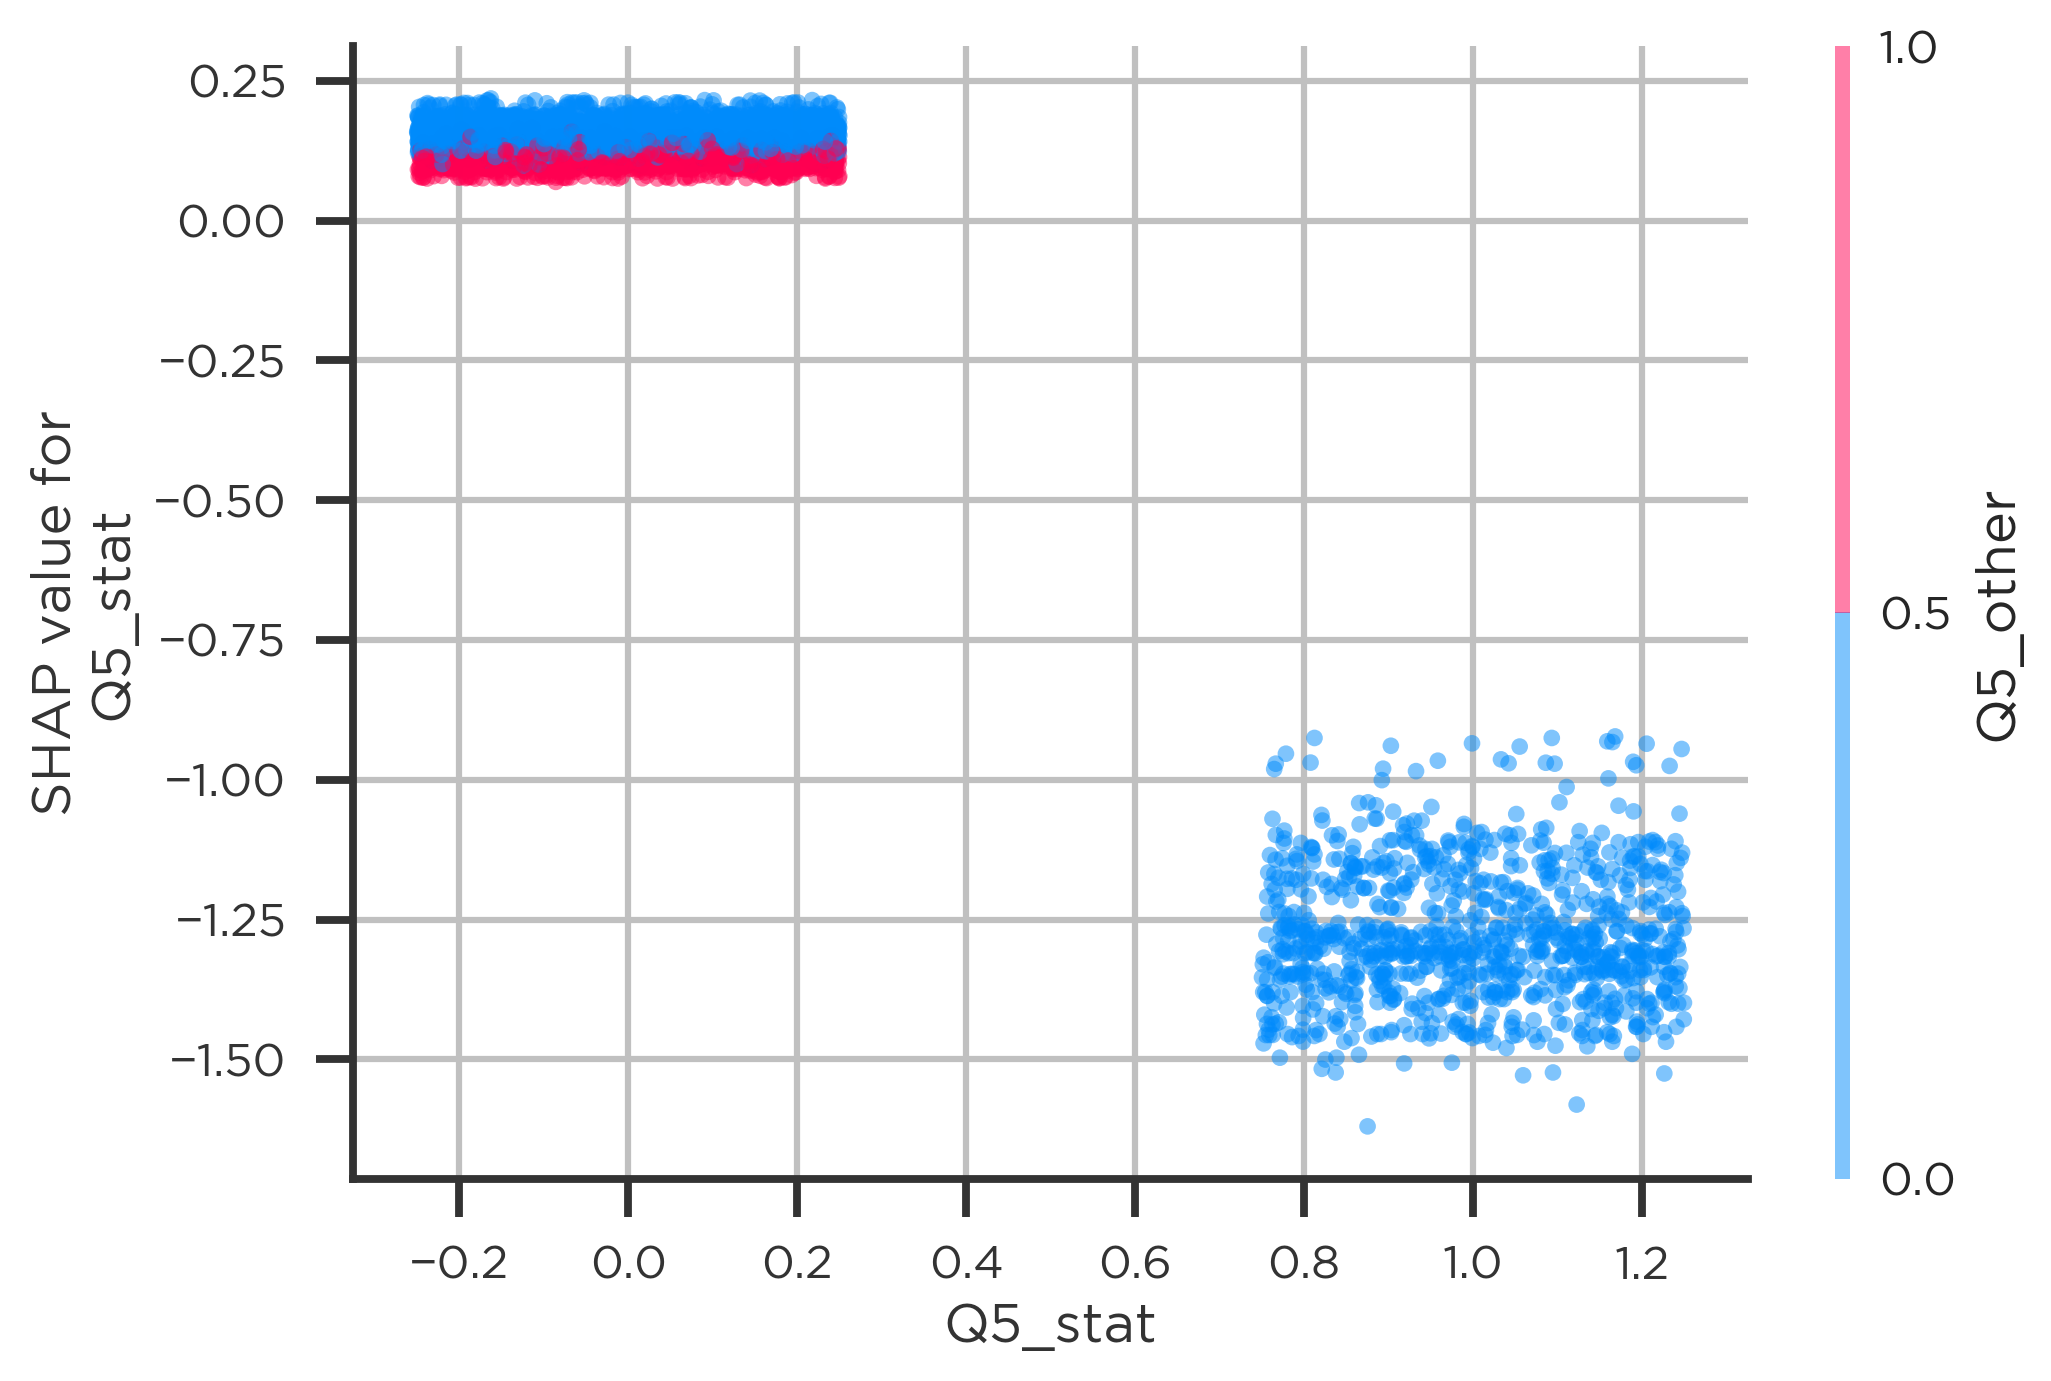

In [82]:
# Q5_stat indicates large (stats grad) tends toward DS
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(10,6), dpi=300)
    shap.dependence_plot('Q5_stat', vals, X_bin, alpha=.5, x_jitter=.5)

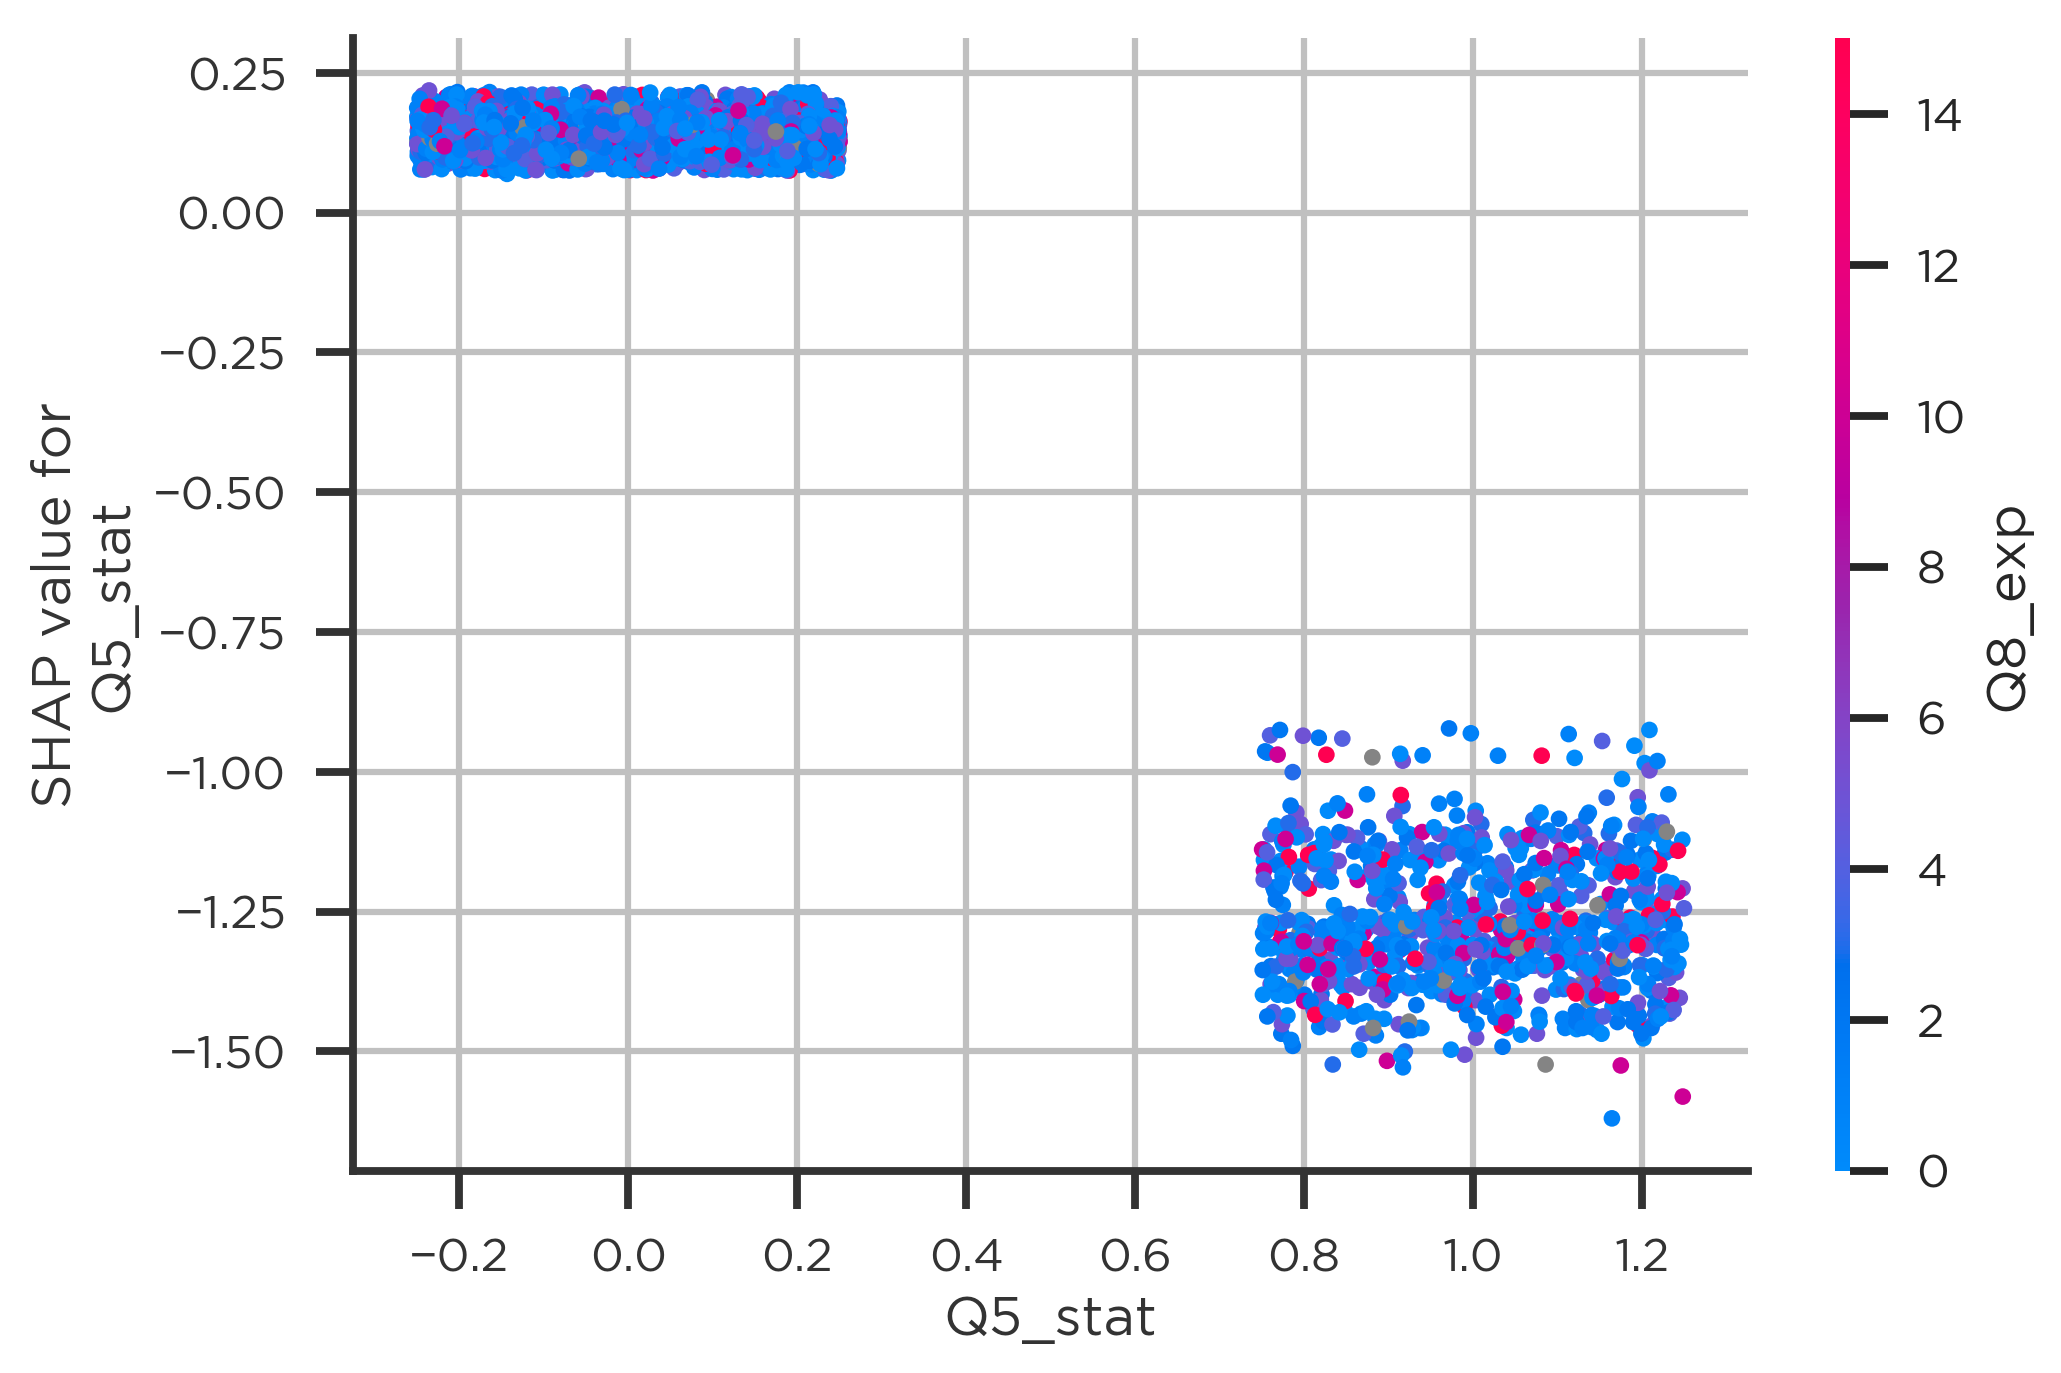

In [83]:
# Q5_stat indicates large (stats grad) tends toward DS
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(10,6), dpi=300)
    shap.dependence_plot('Q5_stat', vals, X_bin, alpha=1,
                        interaction_index='Q8_exp', x_jitter=.5)

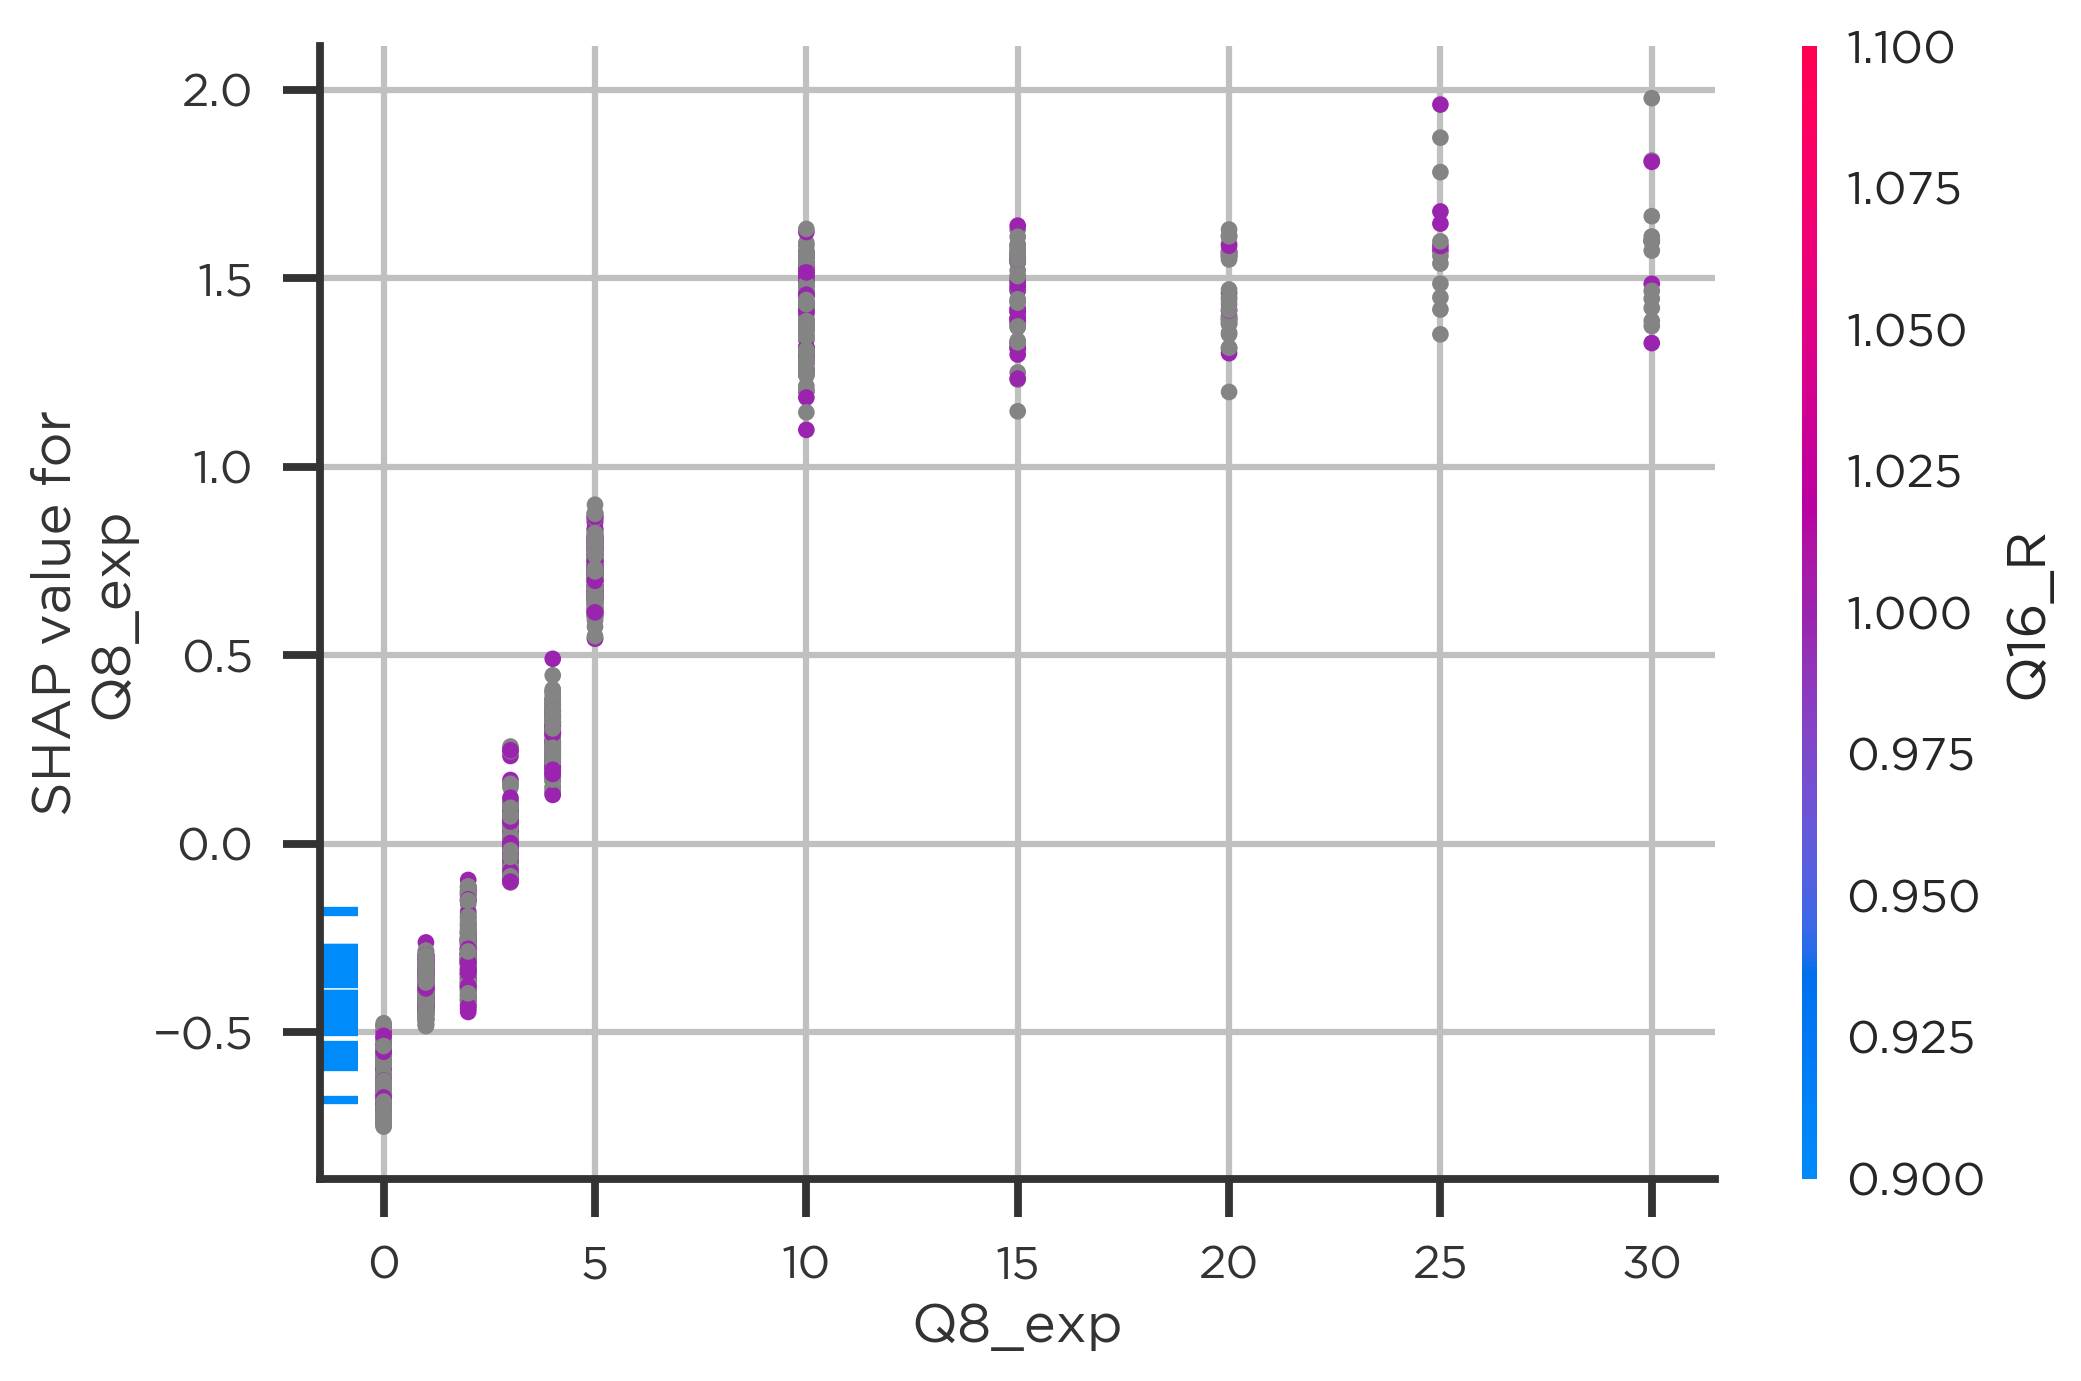

In [84]:
# Q8_exp indicates more exp -> SE
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(10,6), dpi=300)
    shap.dependence_plot('Q8_exp', vals, X_bin, alpha=1)

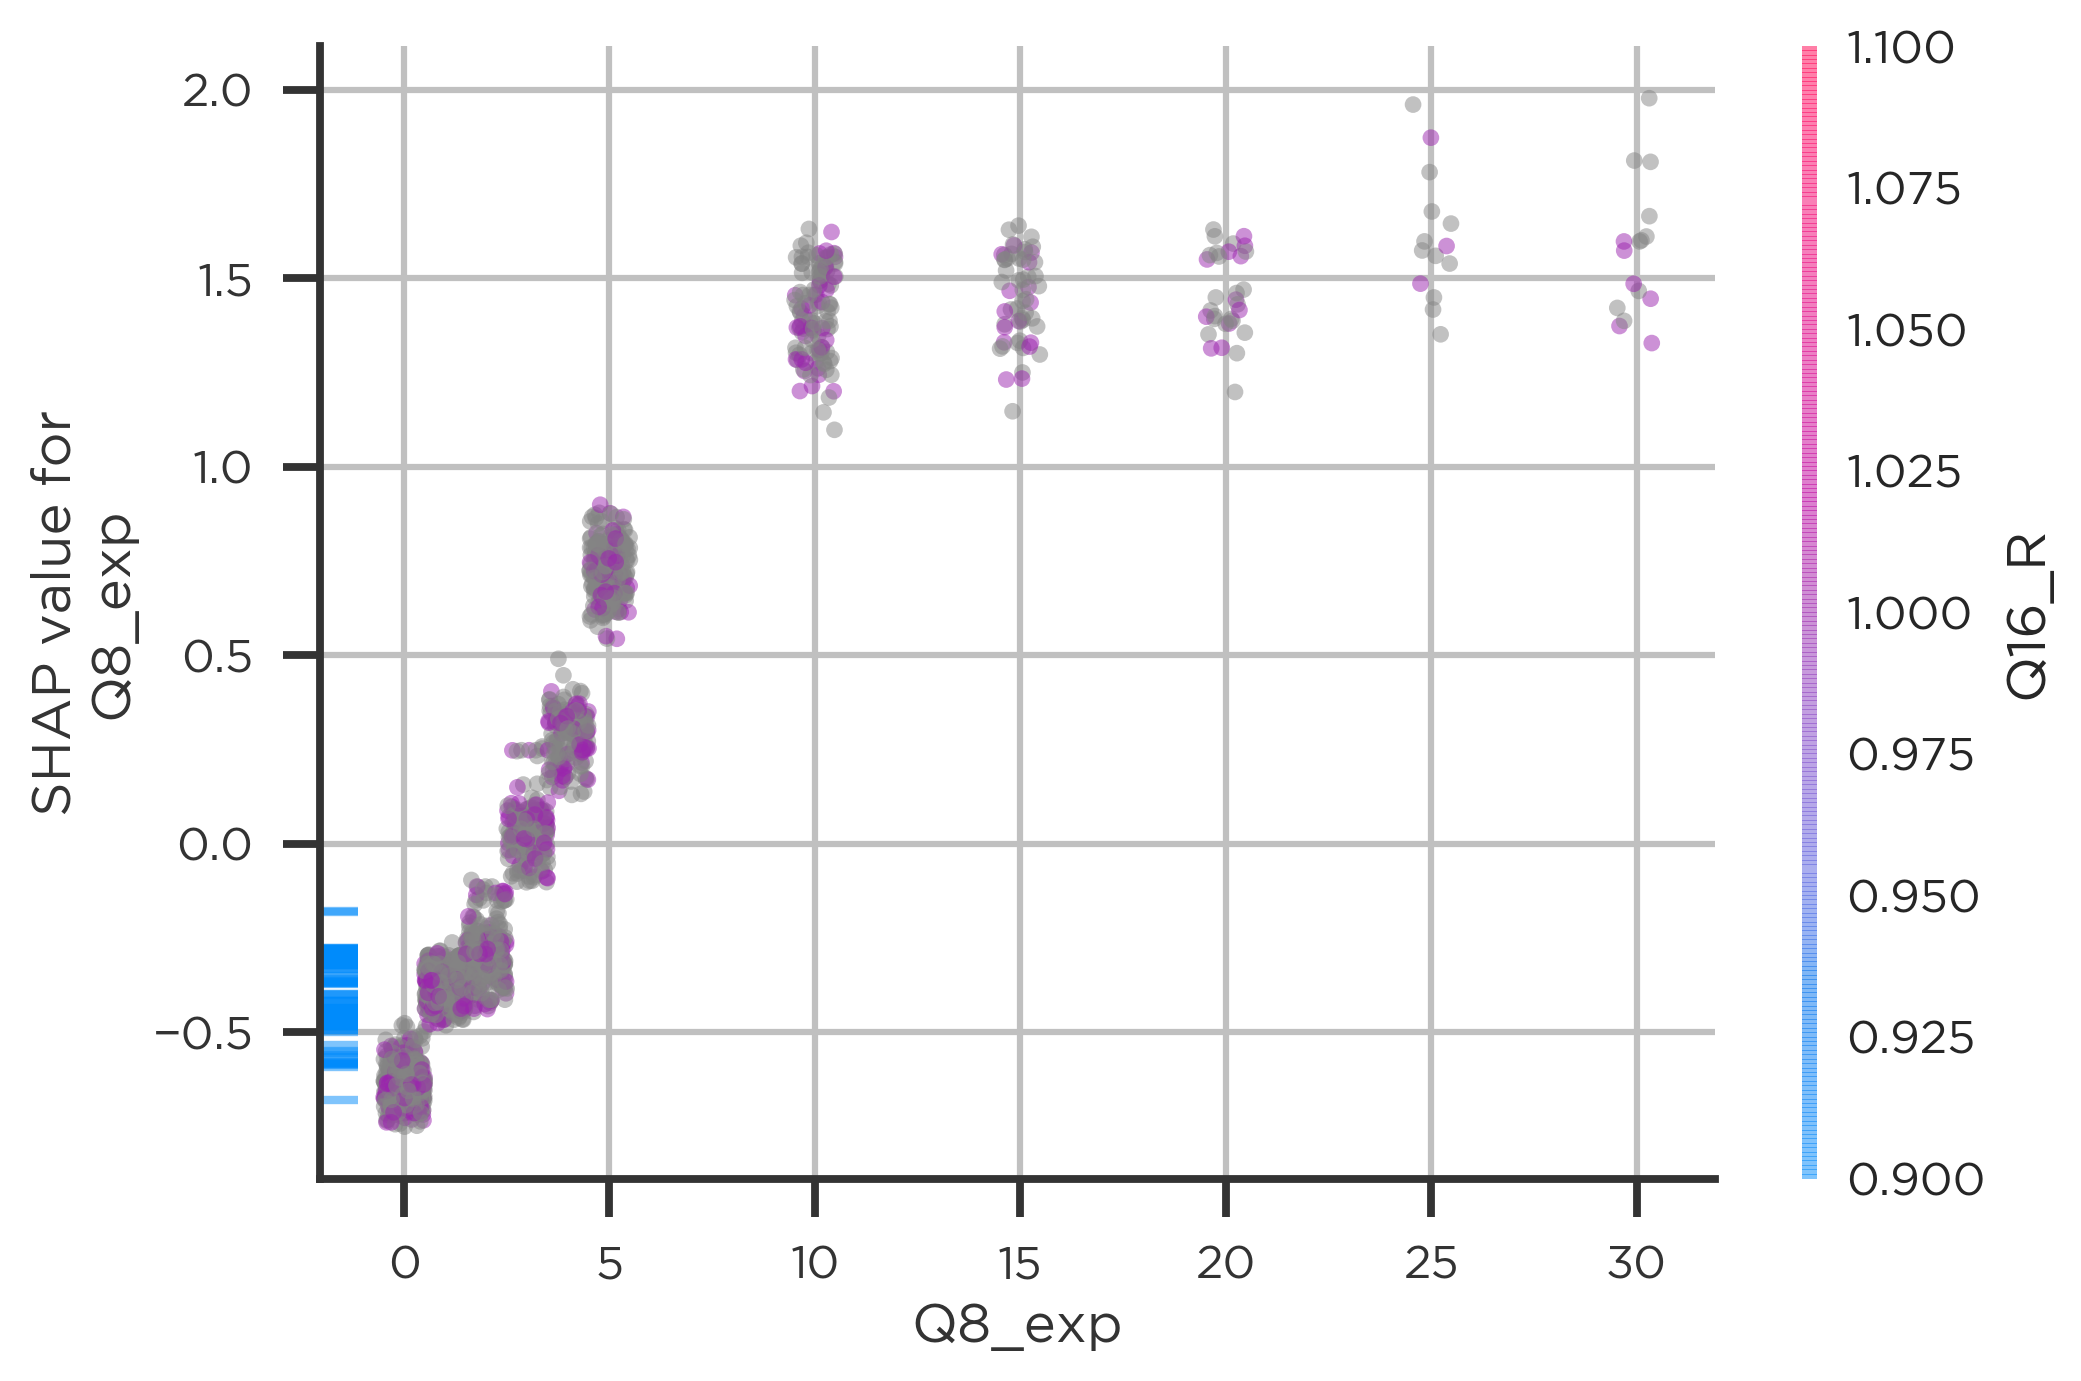

In [85]:
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(10,6), dpi=300)
    shap.dependence_plot('Q8_exp', vals, X_bin, alpha=.5, x_jitter=4)

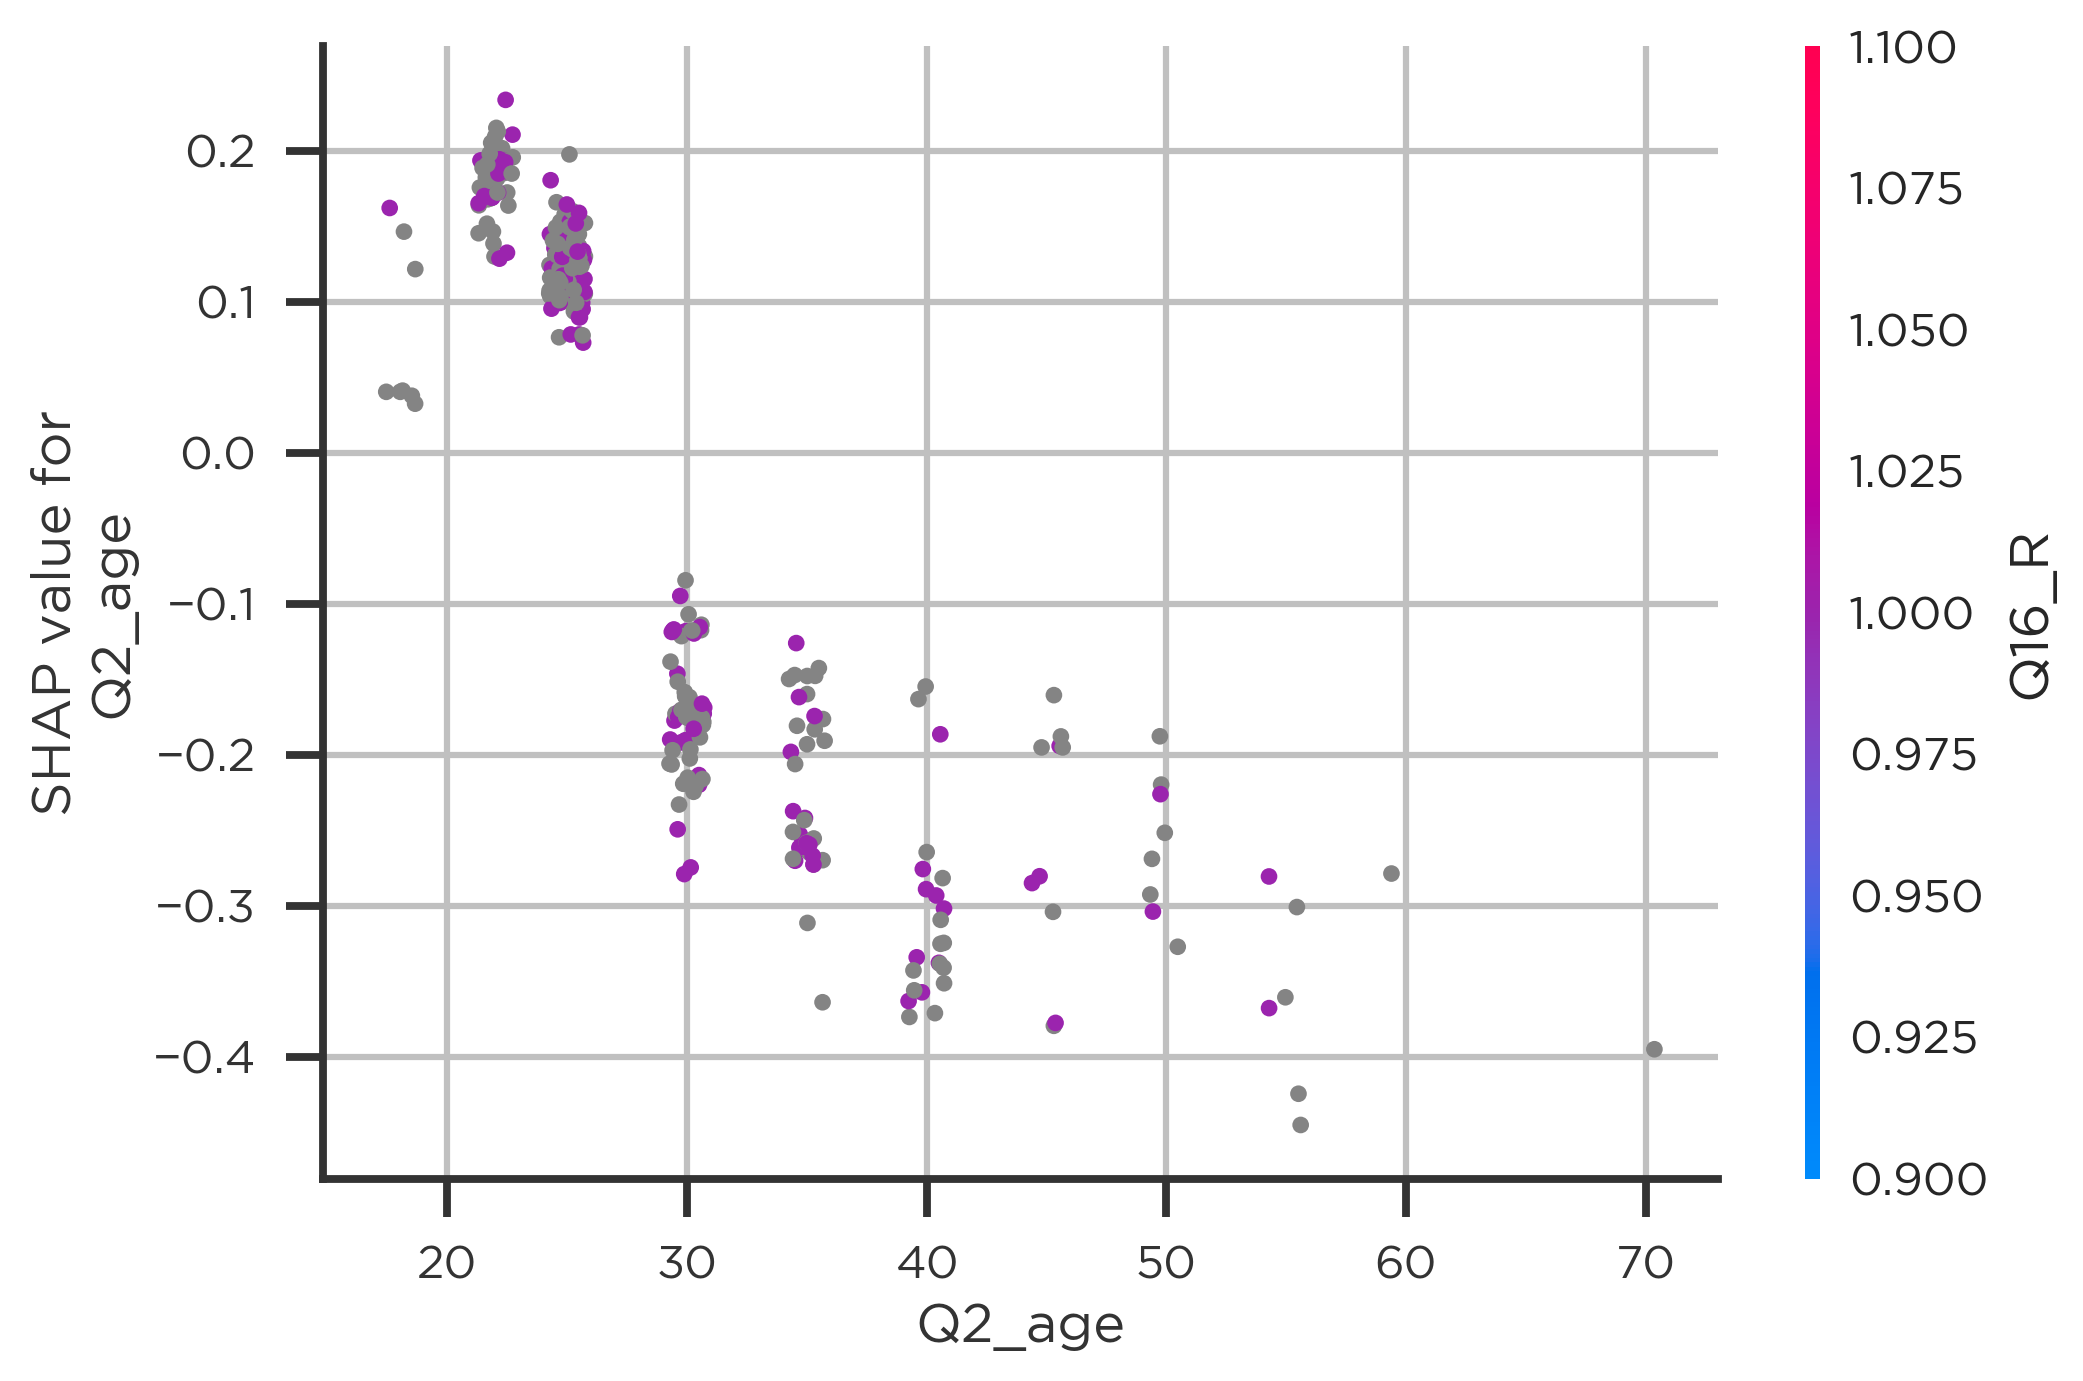

In [86]:
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(10,6), dpi=300)
    shap.dependence_plot('Q2_age', vals[:1000], X_bin.iloc[:1000], alpha=1, x_jitter=.5)